# Table of Contents

* Editor preface
* Overview
* Initial encounter threshold
* Encounter distribution graphs & charts per area
* Appendix

## Editor Preface

I found myself wanting to get back to speedruns of Dragon Quest III, but felt like there were some gaps of knowledge that would be incredibly useful to be aware of. So before I was going to come back, I wanted to really understand some things better, for which encounter formations is a gigantic area of importance. This type of data analysis around encounter thresholds is both interesting to me and is actually valuable - simply being aware of both the probabilities of encounter distributions and all *possible* encounter formations is a very helpful weapon in a player's arsenal when trying to plan how to handle situations. 

Thanks for reading! Certainly everything presented here may not be bulletproof, but the methodology and mining techniques are relatively straightforward. Any questions or observations, contact me at:
* @cleartonic
* twitch.tv/cleartonic
* discord.gg/cleartonic

Or on the Dragon Quest RTA Discord:
* discord.gg/HvZHycp

## Overview

This notebook will review aspects of encounters in Dragon Quest III related to encounter formation probabilities. The goal of the analysis is primarily to best understand the distribution of encounters in areas related to the standard RTA (real time attack) route, with some additional areas out of curiousity. 

#### Encounter mechanics

First, we'll discuss a few things about encounters to set the context for the data & analysis:
* Encounters are triggered when a threshold (2-byte RAM address 0x00F796) reaches 0. 
  * Depletion occurs while walking in areas with encounters (dungeons & overworld primarily), by which a starting value is set upon a number of actions. In simplest terms, a value is set, the player walks around, depleting that value to zero, then a battle occurs. Encounters are not frame-based to trigger.
  * Encounter starting values are set by actions such as triggering a battle (thereby setting the next starting value), entering a new area/screen transition, or using the lamp of darkness (common RTA strategy). 
* While encounters are not frame-based to trigger, the formations are frame-based. Every frame will yield a different encounter depending on the area. 
  * The world map (both light & dark world) in DQIII are aligned in a tile grid format, where encounters will adhere to the grid for all possible formations for that given tile. For dungeons, simply the entire floor adheres to the same set of formations, and may overlap with others in the same dungeon. The below images/data will illustrate where the encounters take place. Generically, these areas referred to as the 'encounter zone'. 
* Overworld encounters do not vary by tile in which they are triggered, and only adhere to the encounter zone grid system. That is, there is no uneven distribution for encounter based on if the tile is a forest, mountain, plains, swamp, etc. 
* Dungeons have varying amounts of encounter areas with set formations. For example, Najimi Tower's first two floors are the same encounter zone, then change. Many dungeons are like this. 
* As evidenced by the data below, there appears to be two main ways encounters draw:
  * Case 1 - Encounters take place in pre-set formations per area, and do not deviate (for example, 1x SkyDragon 7x Metaly in Garuna Tower)
  * Case 2 - Encounters are dynamically generated by taking certain enemies (but not all!) in an encounter zone and populating the fight, limited by the space available on the battle screen. (for example, 2x Garuda 2x VenomMoth 1x Metaly, or 3x VenomMoth 3x Metaly, etc.) 
  * What's interesting is that the probabilities and distribution of overall Case 1 vs. Case 2 change drastically per encounter zone, evident in the data views below. 
    * Further, some monsters and formations will never appear between Case 1 and 2. For example, near Samanosa Shrine, the player can fight 1 Liquid Metal Slime (Case 1) that only shows up alone. There are many Case 2 encounters with other enemies, but Liquid Metal Slime will *never* appear with the other enemies in a Case 2 encounter. If nothing else, this activity alone gives credence to this analysis, which is to understand and assess all *actual* encounters per encounter zone, and not based on some extended analysis. 

#### Data retrieval methodology

There exist a handful of resources on encounters in DQIII, but none about their probability of occurring. The methodology was quite simple - after confirming the above points regarding how encounters draw, brute-force log encounters. 

A lua script was developed to log these encounters. For every area logged, which includes the unique intersection of map type, encounter zone, and time of day, the script logged 10,000 encounters. For example, right outside Aliahan after starting the game would be map type "Overworld", encounter zone "Aliahan", time of day "Day". 

In sum, a total of 144 areas were logged. The script took about 140 minutes per area, which was using Bizhawk version 2.2 at unthrottled speed, and ranged between 180-240fps. 3 computers were set up to run these scripts. Combined run time would calculate to roughly 336 hours of mostly non-manual script running. 
* One may question the significance of the threshold of using 10k encounters. This will be discussed below in an appendix example, but essentially one area was checked with 60k encounters with 6 different sub-data sets generated (at 10k each), then these were compared against each other. All 6 had less than .1% variance to eachother for formation probabilities, which lead to confidence in the 10k threshold.

Finally, there was no attempt to pull apart the assembly code to back in to encounter methodology based on some internal game-code methodology. Given some of the strangeness in probabilities with specific case 1/2 formations (discussed above), estimating based on the game code would both be incredibly cumbersome to unearth, and potentially unaccurate unless the code was 100% translated correctly. From the organizer's standpoint, logging encounters based on what happens in a live RTA setting is most important, and is thus simulated at length here.

#### Results

Every unique encounter zone, map type and time (day/night) combination will be detailed below. When applicable for areas that have day/night (only light world, overworld), the results will be shown next to each other (which further valides the views, as most areas have very similar (or the exact same) day/night distributions). The results will be shown by overworld (land), overworld (sea), then dungeons. Some additional commentary will be given in special areas, such as when metals (Metal Slime & Liquid Metal Slime) appear, and what the overall probability of encountering one is. 

This primarily will serve as an informative resource to those who RTA this game. There is no modeling or speculative purpose of this analysis- it is simply designed to best understand the probabilities behind encounters, when they occur. Much is already understood about how the game sets encounter thresholds and techniques used to reduce encounters (such as resetting an area, using Tiptoe/Shinobi Feet, or forcing an encounter in a less-threatening area). The goal here is to understand more about encounters themselves. 

Again, this notebook is designed to primarily follow encounters that occur within the RTA. This notebook will be updated based on further findings/requests for specific areas.

There exist many resources out there for DQIII information, some of which may have captured some of this before. However, for this information regarding encounter distribution, the organizer felt that verifiability of the processes used for information found elsewhere was weak or unspoken, and a full, clean analysis was worthwhile. 

Finally, for those unfamiliar, results herein are displayed via Python code, which access the underlying data file and pull the stats/graphs for each specific area. 

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns
from IPython.display import Image, Markdown, display
pd.options.display.max_rows = 999

In [2]:
df_master = pd.read_csv('data/dq3-encounter_analytic.csv', dtype={"index": int, "Map Type": str, "Area Code": int, "Zone": str, "Time": str, "Formation": str, "Formation_j": str})
df_walks = pd.read_csv('enka_level/dq3_encounter_walks_master.csv').drop('Unnamed: 0', axis = 1)
df_walks.columns = [['count','area']]

In [28]:
%%capture
## TEMP FOR TESTING OVERWORLD
df = df_master.copy()
#df = df_master.loc[(df_master['Map Type'] == "Overworld") & (df_master['Zone'] == "Aliahan")]
##

maptypes_list = df['Map Type'].unique().tolist()

In [4]:
daynightlist = ['Samanosa (2)','Baharata (3)','Silver Orb Shrine','Kazave','Lamia Shrine','Samanosa (1)','Romaly','Samanosa (4)','Desert','Dhama (1)','Reeve','To Kandar 2','Edinbear','Isis','Tedanki','Baharata (1)','Dhama (2)','Merchant Town','Aliahan','Necrogond','Portoga','Baharata (2)','To Samanosa Shrine','To Magic Ball','Samanosa (3)','To Assalam']

In [5]:
def return_daynight(df_first, maptype, zone):
    df_list = []
    for daynight in ['Day','Night']:
        df_temp = df_first.loc[(df['Map Type'] == maptype) & (df_first['Zone'] == zone) & (df_first['Time'] == daynight)]
        df_query = pd.DataFrame(df_temp['Formation'].value_counts())
        df_query_j = pd.DataFrame(df_temp['Formation_j'].value_counts())
        df_query = df_query.reset_index()
        df_query_j = df_query_j.reset_index()
        df_query_both = pd.concat([df_query, df_query_j], axis=1)
        df_query_both.columns = ['Formation', 'Count', 'Formation_j', 'Count 2']
        df_query_both = df_query_both[['Formation','Formation_j','Count']]
        df_query_both['%'] = df_query_both['Count']/df_query_both['Count'].sum()
        df_query_both = df_query_both[0:10]
        df_list.append(df_query_both)
    return df_list
  
def return_df(df_temp, maptype, zone):
    df_temp = df_temp.loc[(df_temp['Map Type'] == maptype) & (df_temp['Zone'] == zone)]
    df_query = pd.DataFrame(df_temp['Formation'].value_counts())
    df_query_j = pd.DataFrame(df_temp['Formation_j'].value_counts())
    df_query = df_query.reset_index()
    df_query_j = df_query_j.reset_index()
    df_query_both = pd.concat([df_query, df_query_j], axis=1)
    df_query_both.columns = ['Formation', 'Count', 'Formation_j', 'Count 2']
    df_query_both = df_query_both[['Formation','Formation_j','Count']]
    df_query_both['%'] = df_query_both['Count']/df_query_both['Count'].sum()
    df_query_both = df_query_both[0:10]
    return df_query_both

In [6]:
#plot.set_xticklabels(plot.get_xticklabels(), rotation=-45, ha='left')

def plot_two(df_day, df_night, maptype, zone, language):
    sns.set_style('ticks')
    sns.set_context(font_scale=1.4)
    fig, (ax1, ax2) = plt.subplots(ncols=2)
    fig.set_size_inches(16, 6)
    if language == 'en':
        mpl.rcParams['font.sans-serif'] = ['Roboto']
        mpl.rcParams['font.serif'] = ['Roboto']
        sns.set_style("whitegrid",{"font.sans-serif":['Roboto', 'Arial']})
        sns.barplot(x=df_day['Formation'],y=df_day['%'],ax=ax1, palette="Blues_r").set_title('Day')
        sns.barplot(x=df_night['Formation'],y=df_night['%'],ax=ax2, palette="Greens_r").set_title('Night')
    elif language == 'jp':
        mpl.rcParams['font.sans-serif'] = ['SimHei']
        mpl.rcParams['font.serif'] = ['SimHei']
        sns.set_style("whitegrid",{"font.sans-serif":['simhei', 'Arial']})
        sns.barplot(x=df_day['Formation_j'],y=df_day['%'],ax=ax1, palette="Blues_r").set_title('日')
        sns.barplot(x=df_night['Formation_j'],y=df_night['%'],ax=ax2, palette="Greens_r").set_title('夜')
    else:
        print("Language error - check argument.")
    for ax in fig.axes:
        mpl.pyplot.sca(ax)
        plt.xticks(rotation=45, ha='right')
    plt.subplots_adjust(top=.8)
    #fig.suptitle(maptype+" - "+zone)
    plt.show()
    
def plot_one(df_query, maptype, zone, language):
    sns.set_style('ticks')
    sns.set_context(font_scale=1.4)
    fig, ax = plt.subplots(ncols=1)
    fig.set_size_inches(16, 6)
    if language == 'en':
        mpl.rcParams['font.sans-serif'] = ['Roboto']
        mpl.rcParams['font.serif'] = ['Roboto']
        sns.set_style("whitegrid",{"font.sans-serif":['Roboto', 'Arial']})
        sns.barplot(x=df_query['Formation'],y=df_query['%'], palette="Blues_r")
    elif language == 'jp':
        mpl.rcParams['font.sans-serif'] = ['SimHei']
        mpl.rcParams['font.serif'] = ['SimHei']
        sns.set_style("whitegrid",{"font.sans-serif":['simhei', 'Arial']})
        sns.barplot(x=df_query['Formation_j'],y=df_query['%'], palette="Blues_r")
    else:
        print("Language error - check argument.")
    for ax in fig.axes:
        mpl.pyplot.sca(ax)
        plt.xticks(rotation=45, ha='right')
    plt.subplots_adjust(top=.8)
    #fig.suptitle(maptype+" - "+zone)
    plt.show()

In [7]:
def fetch_img(maptype, areacode):
    try:
        return Image(filename='images/'+maptype.lower()+'/'+str(areacode)+'.png')
    except:
        return Image(filename='images/jester-m.png')

## Initial encounter threshold

Encounter threshold refers to the initial value set for how many steps a new encounter will take place. This is set when entering a new area, entering a battle (thereby setting the next value for when the battle is over), or some other misc. means including using the lamp of darkness to change the time, thereby resetting this value. 

Depletion occurs by taking steps in areas with encounters, primarily overworld land, water/sea areas, and dungeons. Every area has a specific depletion rate for the type of tile (forest/field/mountain/sea, and dungeons), which may or may not align 1:1 between areas. For example, sea encounters have varying encounter rates depending on the area. The Sage skill Tiptoe/Shinobi Feet will influence depletion across all tile depletion rates.  

A 1:1 relationship exists between encounter depletion from walking & the likelihood of getting an encounter - therefore in layman's terms, the higher the initial value, the more amount of steps the player can take before getting into a fight. This is important for RTA, because it may influence the player's choices when trying to force an encounter or dodge it altogether. 

As stated before, this value exists at the 2-byte RAM address 0x00F796. Only the low byte (0x00F797) is set, but depletion occurs on both bytes.

The goal of what's presented here is to briefly show distribution of encounter thresholds. A more rigorous analysis dedicated to RTA routes & likelihood of encounters may be worthwhile. 

The below two charts demonstrate the results of logging starting threshold values at 8 different areas, polled at 10,000 encounters for each area. Note that these numbers are integers, not hexadecimal. The results are very straightforward (again, based off of this sample):
* Encounters appear to follow a normal distribution around the mean, which appears to be 24. 
* The range of starting thresholds appears to be between 1 and 48
* All areas (which vary in map type (overworld/sea/dungeon)) appear to use the same initial value threshold algorithm

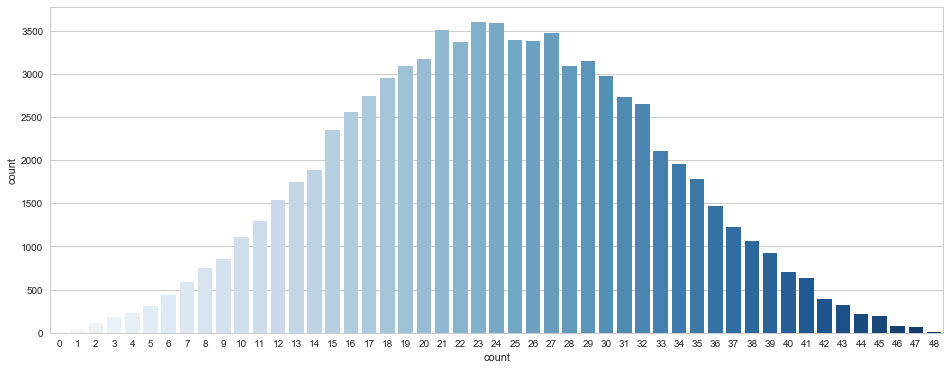

In [8]:
sns.set(style = 'whitegrid')
fig, ax = plt.subplots(ncols=1)
fig.set_size_inches(16, 6)
sns.countplot(x = 'count', data = df_walks, palette="Blues")
plt.show()

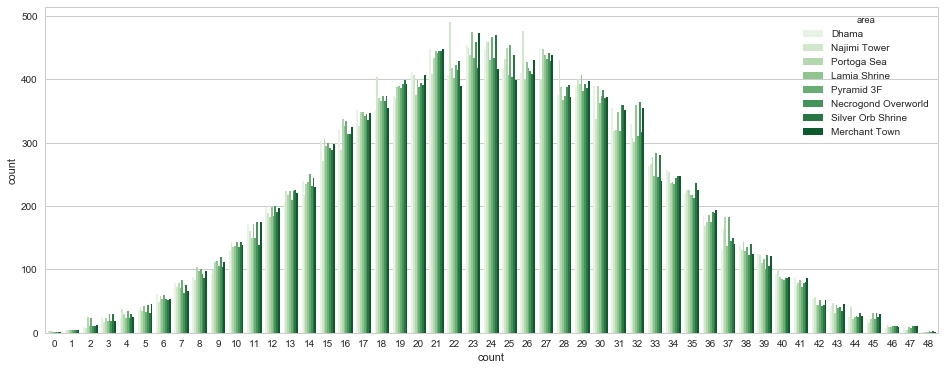

In [9]:
fig, ax = plt.subplots(ncols=1)
fig.set_size_inches(16, 6)
sns.countplot(x = 'count', hue = 'area',data = df_walks, palette="Greens")
plt.show()

## Encounter distribution graphs & charts per area

In [29]:
def call_fullchart_dn(df_day, df_night, language):
    if language == 'en':
        print("Day:")
        df_day2 = df_day[['Formation','Count','%']]
        df_day2 = df_day2.set_index('Formation')
        print(df_day2)
        print("-----")
        print("Night:")
        df_night2 = df_night[['Formation','Count','%']]
        df_night2 = df_night2.set_index('Formation')
        print(df_night2)
        print("-----")

    elif language == 'jp':
        print("日:")
        df_day2 = df_day[['Formation_j','Count','%']]
        df_day2 = df_day2.set_index('Formation_j')
        print(df_day2)
        print("-----")
        print("夜:")
        df_night2 = df_night[['Formation_j','Count','%']]
        df_night2 = df_night2.set_index('Formation_j')
        print(df_night2)
        print("-----")
    else:
        print("Language error - check argument.")
            
def call_fullchart(df_temp, language):
        if language == 'en':
            df_temp2 = pd.DataFrame(df_temp['Formation'].value_counts())
            df_temp2['%'] = df_temp2['Formation']/df_temp2['Formation'].sum()
            print(df_temp2)
        elif language == 'jp':
            df_temp2 = pd.DataFrame(df_temp['Formation_j'].value_counts())
            df_temp2['%'] = df_temp2['Formation_j']/df_temp2['Formation_j'].sum()
            print(df_temp2)
        else:
            print("Language error - check argument.")

**Map Type: Dungeon**

-----


**Najimi Tower B1**

-----


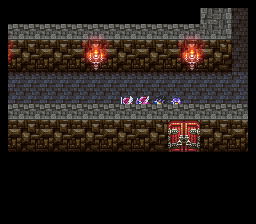

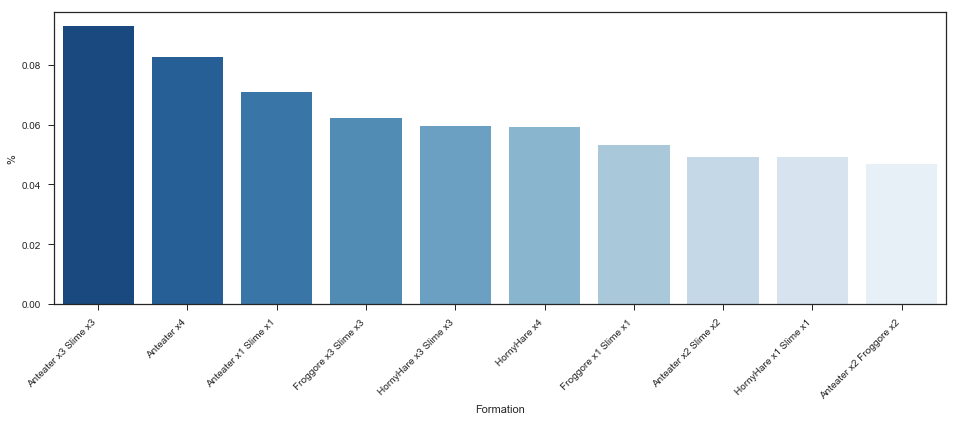

                          Formation         %
Anteater x3 Slime x3            930  0.093009
Anteater x4                     828  0.082808
Anteater x1 Slime x1            708  0.070807
Froggore x3 Slime x3            621  0.062106
HornyHare x3 Slime x3           596  0.059606
HornyHare x4                    592  0.059206
Froggore x1 Slime x1            532  0.053205
Anteater x2 Slime x2            492  0.049205
HornyHare x1 Slime x1           491  0.049105
Anteater x2 Froggore x2         469  0.046905
Froggore x2                     396  0.039604
Froggore x3                     387  0.038704
Butterfly x2                    377  0.037704
Butterfly x3                    361  0.036104
HornyHare x2 Slime x2           337  0.033703
Froggore x2 Slime x2            318  0.031803
Froggore x2 HornyHare x2        274  0.027403
Anteater x3 HornyHare x2        252  0.025203
Anteater x1 Froggore x1         246  0.024602
Anteater x1 HornyHare x1        241  0.024102
HornyHare x3                    17

**Najimi Tower F1**

-----


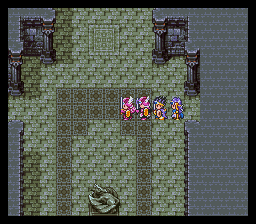

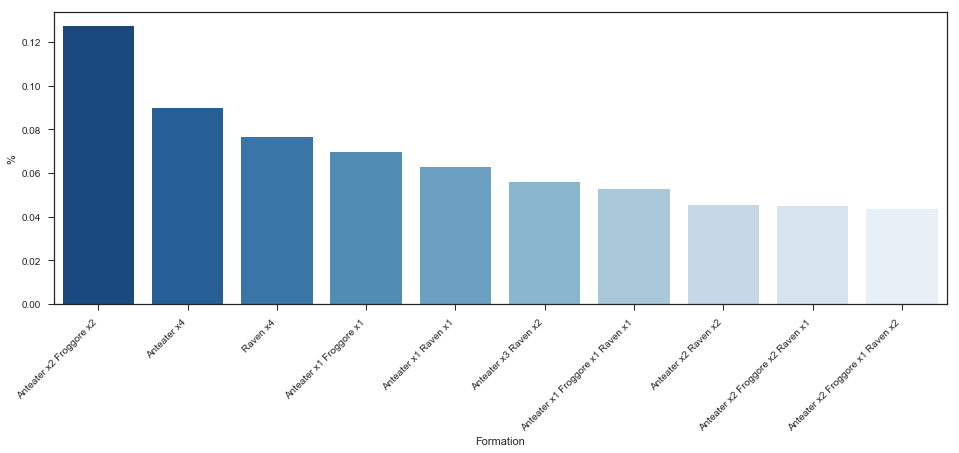

                                  Formation         %
Anteater x2 Froggore x2                1272  0.127213
Anteater x4                             897  0.089709
Raven x4                                767  0.076708
Anteater x1 Froggore x1                 695  0.069507
Anteater x1 Raven x1                    626  0.062606
Anteater x3 Raven x2                    560  0.056006
Anteater x1 Froggore x1 Raven x1        528  0.052805
Anteater x2 Raven x2                    453  0.045305
Anteater x2 Froggore x2 Raven x1        450  0.045005
Anteater x2 Froggore x1 Raven x2        437  0.043704
Babble x3                               362  0.036204
Babble x2                               358  0.035804
Butterfly x2 HornyHare x2               339  0.033903
Butterfly x3 HornyHare x2               335  0.033503
Anteater x2 Raven x3                    331  0.033103
Butterfly x1 HornyHare x3               282  0.028203
Froggore x1 Raven x1                    255  0.025503
Anteater x3                 

**Najimi Tower F2**

-----


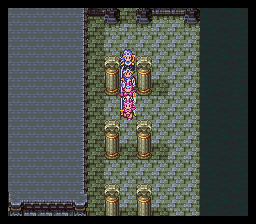

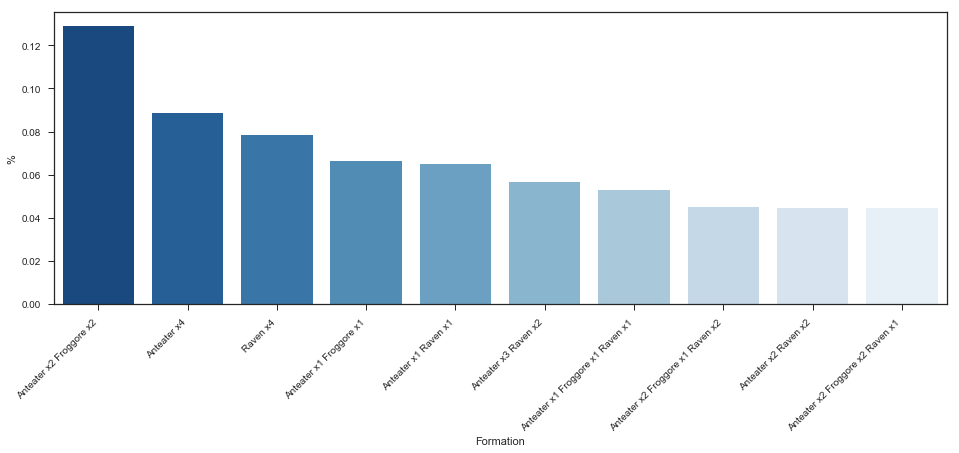

                                  Formation         %
Anteater x2 Froggore x2                1288  0.128813
Anteater x4                             888  0.088809
Raven x4                                783  0.078308
Anteater x1 Froggore x1                 663  0.066307
Anteater x1 Raven x1                    651  0.065107
Anteater x3 Raven x2                    567  0.056706
Anteater x1 Froggore x1 Raven x1        527  0.052705
Anteater x2 Froggore x1 Raven x2        448  0.044804
Anteater x2 Raven x2                    445  0.044504
Anteater x2 Froggore x2 Raven x1        443  0.044304
Babble x3                               363  0.036304
Babble x2                               354  0.035404
Anteater x2 Raven x3                    336  0.033603
Butterfly x2 HornyHare x2               332  0.033203
Butterfly x3 HornyHare x2               326  0.032603
Butterfly x1 HornyHare x3               276  0.027603
Froggore x1 Raven x1                    247  0.024702
Anteater x3                 

**Najimi Tower F3**

-----


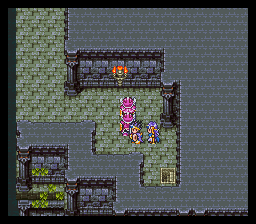

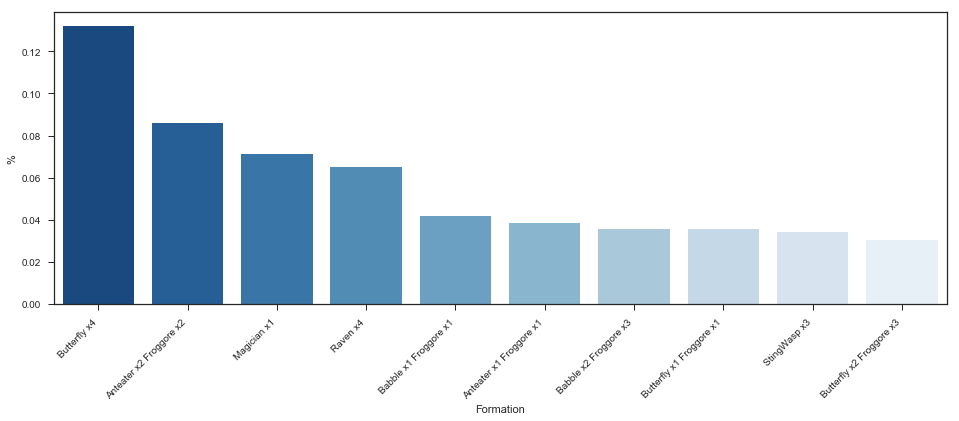

                                                Formation         %
Butterfly x4                                         1320  0.132013
Anteater x2 Froggore x2                               859  0.085909
Magician x1                                           711  0.071107
Raven x4                                              652  0.065207
Babble x1 Froggore x1                                 418  0.041804
Anteater x1 Froggore x1                               383  0.038304
Babble x2 Froggore x3                                 355  0.035504
Butterfly x1 Froggore x1                              354  0.035404
StingWasp x3                                          340  0.034003
Butterfly x2 Froggore x3                              301  0.030103
StingWasp x2                                          293  0.029303
Babble x2 Froggore x2                                 291  0.029103
Butterfly x2 Froggore x2                              277  0.027703
Babble x2 Butterfly x2 Froggore x2              

**Magic Ball Cave F1**

-----


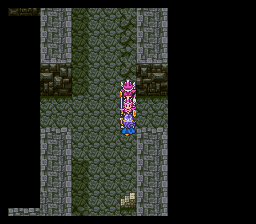

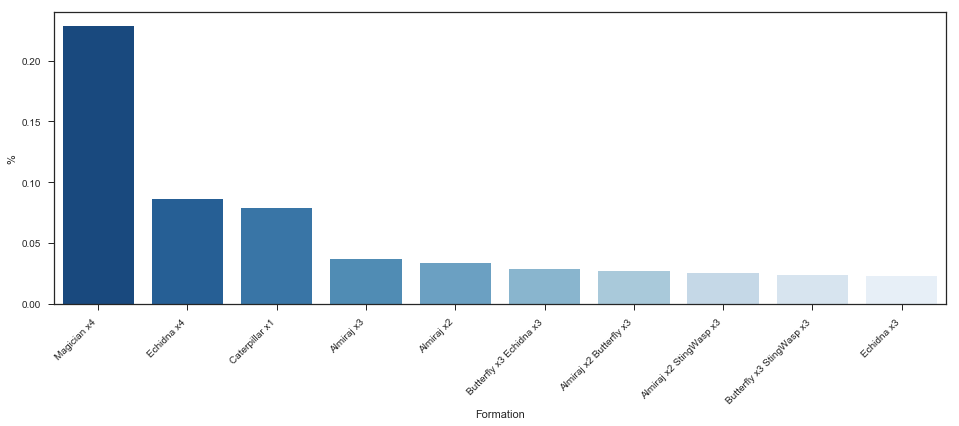

                                                 Formation         %
Magician x4                                           2282  0.228223
Echidna x4                                             859  0.085909
Caterpillar x1                                         785  0.078508
Almiraj x3                                             369  0.036904
Almiraj x2                                             339  0.033903
Butterfly x3 Echidna x3                                284  0.028403
Almiraj x2 Butterfly x3                                272  0.027203
Almiraj x2 StingWasp x3                                255  0.025503
Butterfly x3 StingWasp x3                              236  0.023602
Echidna x3                                             228  0.022802
Almiraj x1 Echidna x1                                  215  0.021502
Butterfly x1 Echidna x1                                213  0.021302
Almiraj x1 StingWasp x1                                207  0.020702
Echidna x1 StingWasp x1           

**Magic Ball Cave B1**

-----


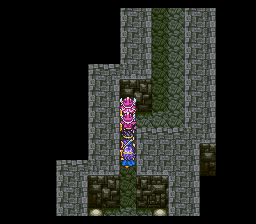

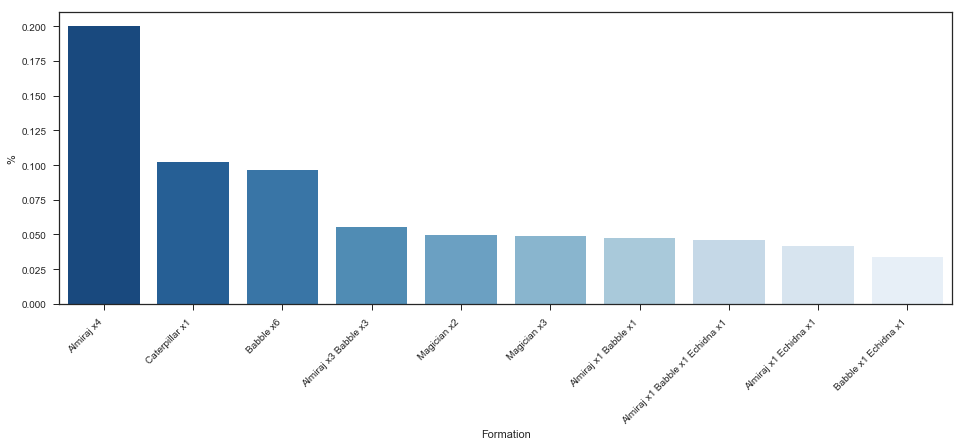

                                 Formation         %
Almiraj x4                            2001  0.200120
Caterpillar x1                        1025  0.102510
Babble x6                              962  0.096210
Almiraj x3 Babble x3                   552  0.055206
Magician x2                            495  0.049505
Magician x3                            492  0.049205
Almiraj x1 Babble x1                   476  0.047605
Almiraj x1 Babble x1 Echidna x1        460  0.046005
Almiraj x1 Echidna x1                  420  0.042004
Babble x1 Echidna x1                   336  0.033603
Almiraj x3 Echidna x2                  336  0.033603
Almiraj x2 Babble x2 Echidna x1        315  0.031503
Almiraj x2 Echidna x2                  299  0.029903
Almiraj x2 Babble x1 Echidna x2        289  0.028903
Almiraj x2 Babble x2                   275  0.027503
Almiraj x1 Babble x2 Echidna x2        275  0.027503
Almiraj x2 Echidna x3                  262  0.026203
Babble x2 Echidna x2                   251  0.

**Champagne Tower F1**

-----


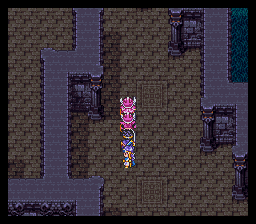

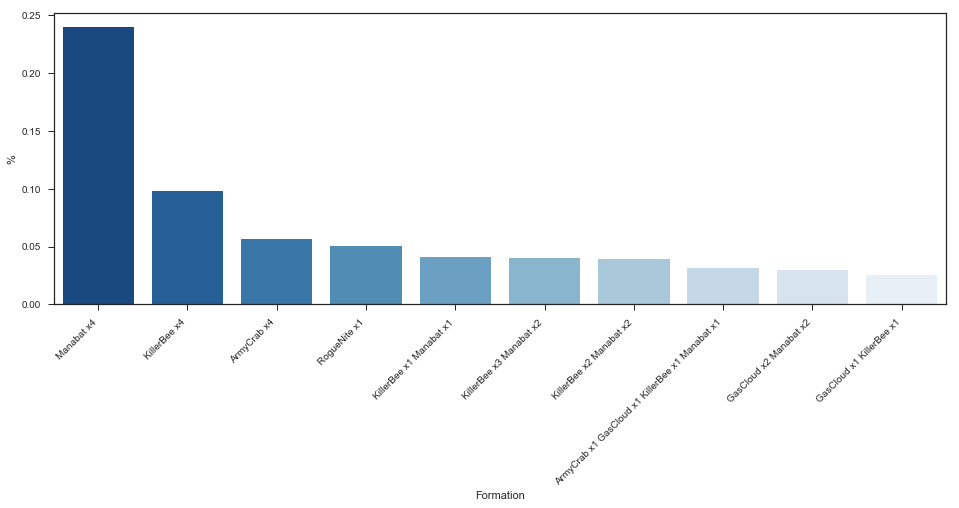

                                                 Formation         %
Manabat x4                                            2400  0.240024
KillerBee x4                                           979  0.097910
ArmyCrab x4                                            569  0.056906
RogueNite x1                                           504  0.050405
KillerBee x1 Manabat x1                                408  0.040804
KillerBee x3 Manabat x2                                404  0.040404
KillerBee x2 Manabat x2                                393  0.039304
ArmyCrab x1 GasCloud x1 KillerBee x1 Manabat x1        318  0.031803
GasCloud x2 Manabat x2                                 293  0.029303
GasCloud x1 KillerBee x1                               253  0.025303
GasCloud x2                                            250  0.025003
ArmyCrab x2 Manabat x2                                 242  0.024202
ArmyCrab x2 KillerBee x2                               239  0.023902
ArmyCrab x2 KillerBee x3          

**Champagne Tower F2**

-----


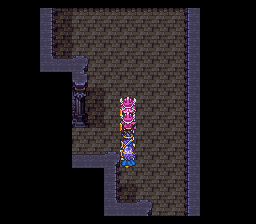

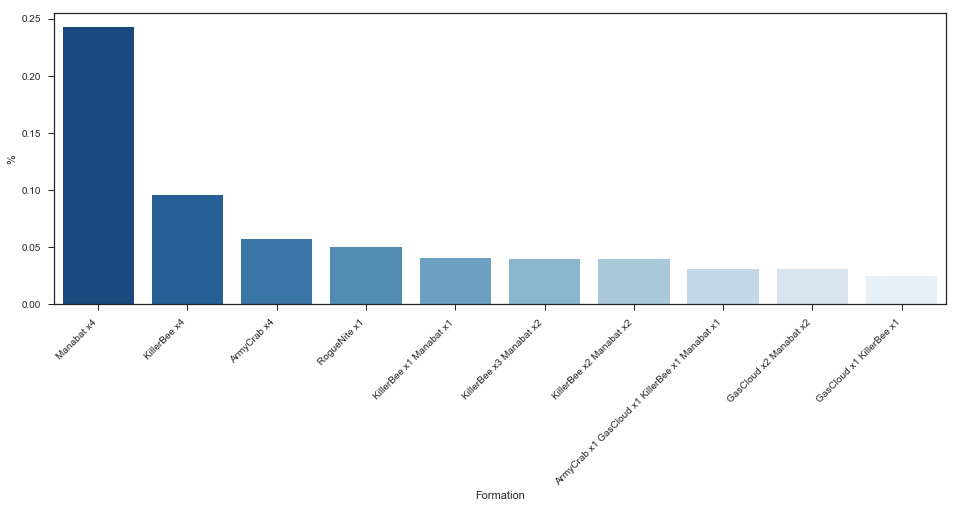

                                                 Formation         %
Manabat x4                                            2429  0.242924
KillerBee x4                                           957  0.095710
ArmyCrab x4                                            572  0.057206
RogueNite x1                                           506  0.050605
KillerBee x1 Manabat x1                                407  0.040704
KillerBee x3 Manabat x2                                397  0.039704
KillerBee x2 Manabat x2                                393  0.039304
ArmyCrab x1 GasCloud x1 KillerBee x1 Manabat x1        309  0.030903
GasCloud x2 Manabat x2                                 305  0.030503
GasCloud x1 KillerBee x1                               250  0.025003
ArmyCrab x2 KillerBee x2                               249  0.024902
ArmyCrab x2 Manabat x2                                 245  0.024502
GasCloud x2                                            237  0.023702
ArmyCrab x2 KillerBee x3          

**Champagne Tower F3**

-----


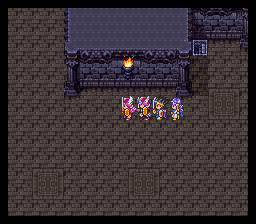

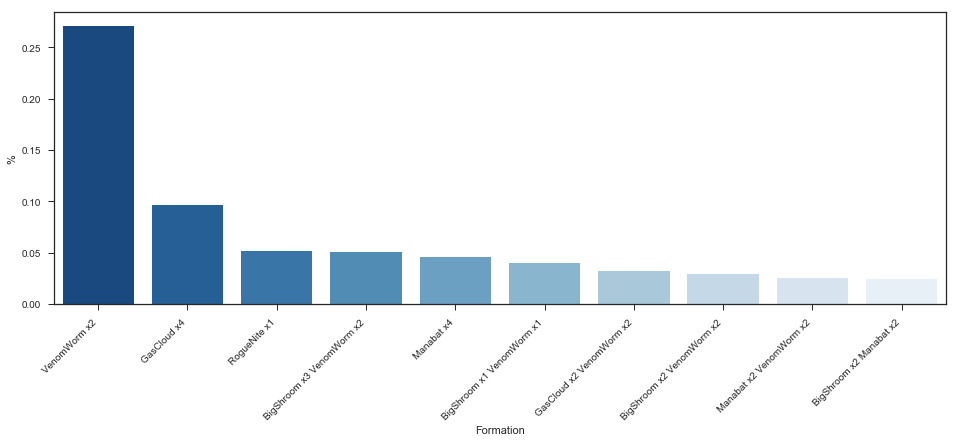

                                                  Formation         %
VenomWorm x2                                           2706  0.270627
GasCloud x4                                             962  0.096210
RogueNite x1                                            518  0.051805
BigShroom x3 VenomWorm x2                               511  0.051105
Manabat x4                                              455  0.045505
BigShroom x1 VenomWorm x1                               404  0.040404
GasCloud x2 VenomWorm x2                                320  0.032003
BigShroom x2 VenomWorm x2                               288  0.028803
Manabat x2 VenomWorm x2                                 252  0.025203
BigShroom x2 Manabat x2                                 248  0.024802
BigShroom x1 GasCloud x1                                246  0.024602
BigShroom x2                                            239  0.023902
BigShroom x3 Manabat x2                                 227  0.022702
BigShroom x3        

**Champagne Tower F4**

-----


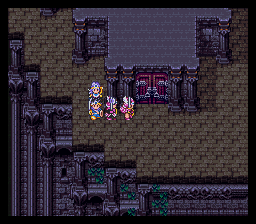

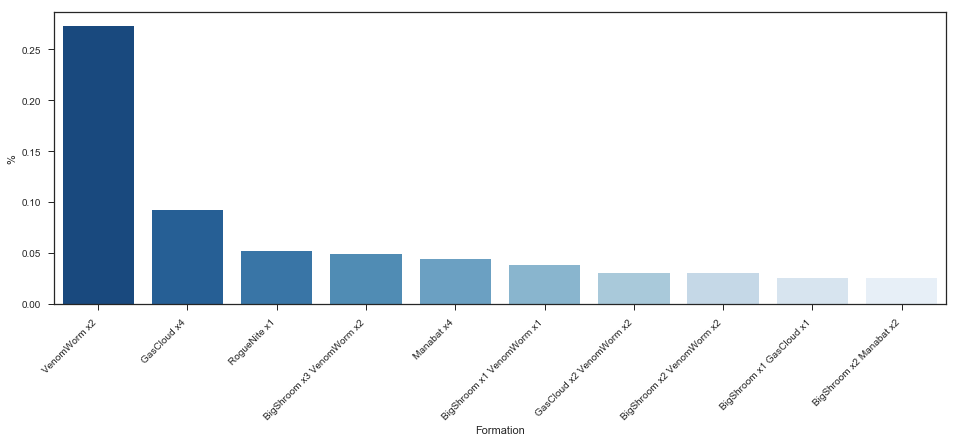

                                                  Formation         %
VenomWorm x2                                           2726  0.272627
GasCloud x4                                             925  0.092509
RogueNite x1                                            524  0.052405
BigShroom x3 VenomWorm x2                               495  0.049505
Manabat x4                                              444  0.044404
BigShroom x1 VenomWorm x1                               380  0.038004
GasCloud x2 VenomWorm x2                                306  0.030603
BigShroom x2 VenomWorm x2                               300  0.030003
BigShroom x1 GasCloud x1                                258  0.025803
BigShroom x2 Manabat x2                                 257  0.025703
Manabat x2 VenomWorm x2                                 246  0.024602
BigShroom x2                                            239  0.023902
BigShroom x3                                            227  0.022702
BigShroom x3 Manabat

**Pyramid F1**

-----


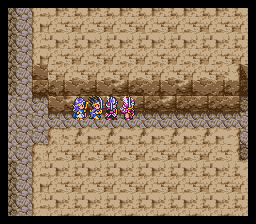

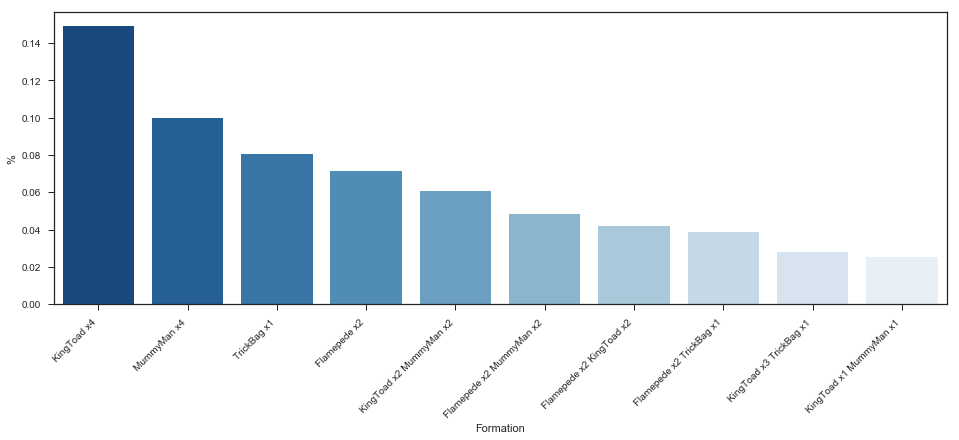

                                                  Formation         %
KingToad x4                                            1490  0.149015
MummyMan x4                                             999  0.099910
TrickBag x1                                             805  0.080508
Flamepede x2                                            714  0.071407
KingToad x2 MummyMan x2                                 608  0.060806
Flamepede x2 MummyMan x2                                482  0.048205
Flamepede x2 KingToad x2                                421  0.042104
Flamepede x2 TrickBag x1                                387  0.038704
KingToad x3 TrickBag x1                                 279  0.027903
KingToad x1 MummyMan x1                                 250  0.025003
MummyMan x1 TrickBag x1                                 237  0.023702
Flamepede x1 KingToad x1                                227  0.022702
Flamepede x1 MummyMan x1                                225  0.022502
MummyMan x3         

**Pyramid F2**

-----


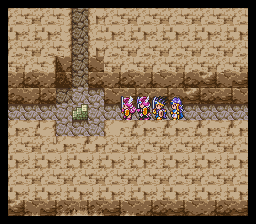

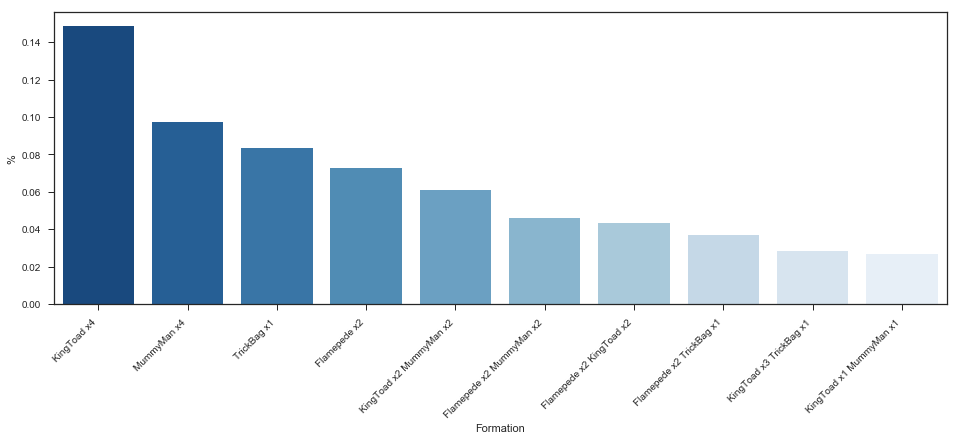

                                                  Formation         %
KingToad x4                                            1484  0.148415
MummyMan x4                                             975  0.097510
TrickBag x1                                             832  0.083208
Flamepede x2                                            727  0.072707
KingToad x2 MummyMan x2                                 610  0.061006
Flamepede x2 MummyMan x2                                461  0.046105
Flamepede x2 KingToad x2                                431  0.043104
Flamepede x2 TrickBag x1                                369  0.036904
KingToad x3 TrickBag x1                                 281  0.028103
KingToad x1 MummyMan x1                                 266  0.026603
MummyMan x1 TrickBag x1                                 232  0.023202
Flamepede x1 MummyMan x1                                228  0.022802
Flamepede x1 KingToad x1                                227  0.022702
MummyMan x4 TrickBag

**Pyramid F3**

-----


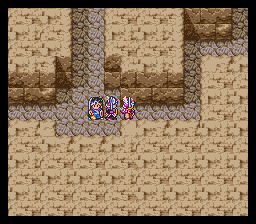

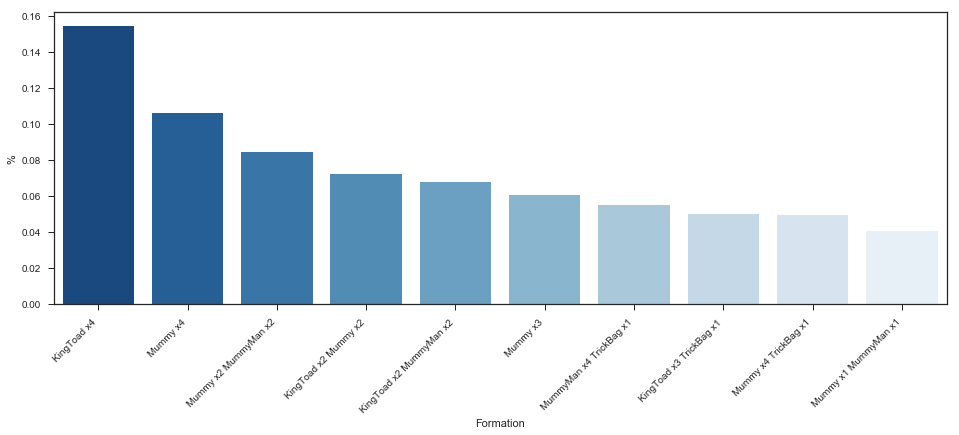

                                           Formation         %
KingToad x4                                     1541  0.154115
Mummy x4                                        1058  0.105811
Mummy x2 MummyMan x2                             841  0.084108
KingToad x2 Mummy x2                             720  0.072007
KingToad x2 MummyMan x2                          676  0.067607
Mummy x3                                         606  0.060606
MummyMan x4 TrickBag x1                          549  0.054905
KingToad x3 TrickBag x1                          498  0.049805
Mummy x4 TrickBag x1                             496  0.049605
Mummy x1 MummyMan x1                             403  0.040304
Mummy x2                                         387  0.038704
KingToad x1 Mummy x1                             339  0.033903
KingToad x1 MummyMan x1                          332  0.033203
KingToad x1 Mummy x1 Mummy x1 MummyMan x1        209  0.020902
Mummy x1 Mummy x1                                207  0

**Pyramid F4**

-----


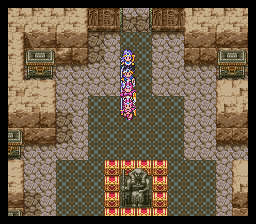

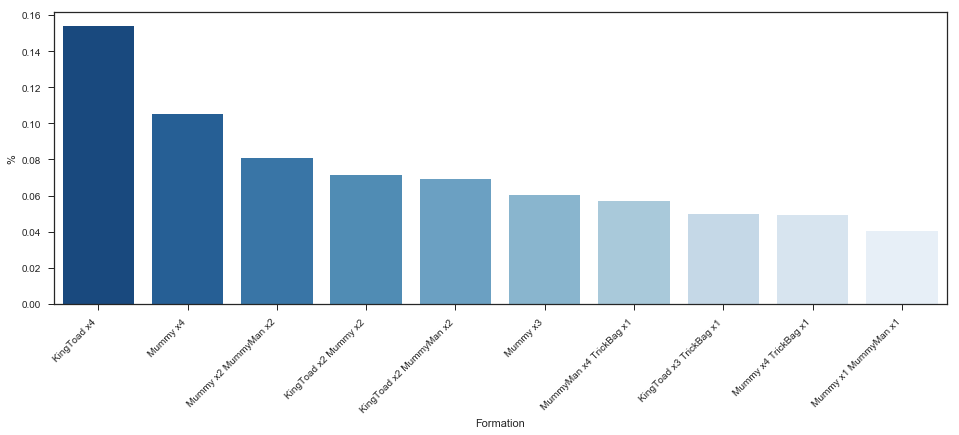

                                           Formation         %
KingToad x4                                     1538  0.153815
Mummy x4                                        1054  0.105411
Mummy x2 MummyMan x2                             807  0.080708
KingToad x2 Mummy x2                             716  0.071607
KingToad x2 MummyMan x2                          693  0.069307
Mummy x3                                         605  0.060506
MummyMan x4 TrickBag x1                          568  0.056806
KingToad x3 TrickBag x1                          499  0.049905
Mummy x4 TrickBag x1                             494  0.049405
Mummy x1 MummyMan x1                             403  0.040304
Mummy x2                                         393  0.039304
KingToad x1 Mummy x1                             341  0.034103
KingToad x1 MummyMan x1                          326  0.032603
KingToad x1 Mummy x1 Mummy x1 MummyMan x1        209  0.020902
Mummy x1 Mummy x1                                203  0

**Kandar Cave F1**

-----


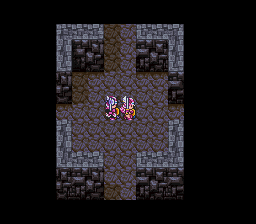

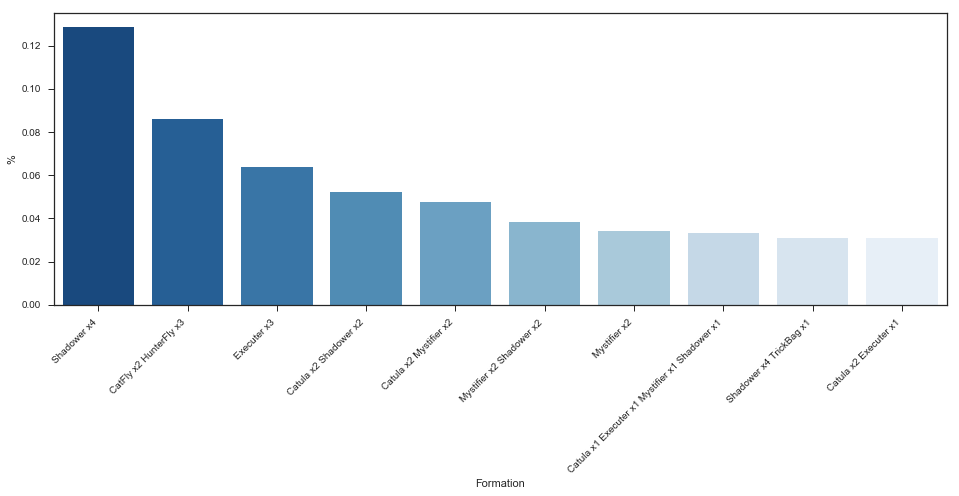

                                                Formation         %
Shadower x4                                          1286  0.128613
CatFly x2 HunterFly x3                                860  0.086009
Executer x3                                           640  0.064006
Catula x2 Shadower x2                                 523  0.052305
Catula x2 Mystifier x2                                476  0.047605
Mystifier x2 Shadower x2                              383  0.038304
Mystifier x2                                          343  0.034303
Catula x1 Executer x1 Mystifier x1 Shadower x1        331  0.033103
Shadower x4 TrickBag x1                               311  0.031103
Catula x2 Executer x1                                 308  0.030803
Mystifier x3                                          302  0.030203
Catula x3 TrickBag x1                                 301  0.030103
Executer x2 TrickBag x1                               281  0.028103
Mystifier x3 TrickBag x1                        

**Garuna Tower F1**

-----


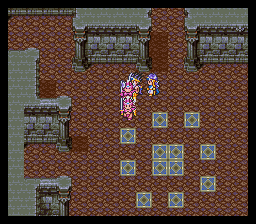

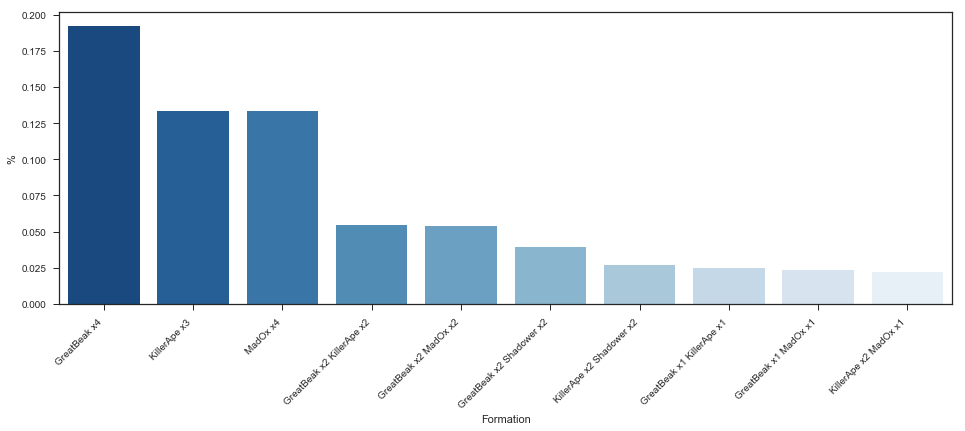

                                                    Formation         %
GreatBeak x4                                             1920  0.192019
KillerApe x3                                             1336  0.133613
MadOx x4                                                 1331  0.133113
GreatBeak x2 KillerApe x2                                 547  0.054705
GreatBeak x2 MadOx x2                                     536  0.053605
GreatBeak x2 Shadower x2                                  392  0.039204
KillerApe x2 Shadower x2                                  270  0.027003
GreatBeak x1 KillerApe x1                                 248  0.024802
GreatBeak x1 MadOx x1                                     235  0.023502
KillerApe x2 MadOx x1                                     219  0.021902
MadOx x2 Shadower x2                                      210  0.021002
GreatBeak x1 Shadower x1                                  185  0.018502
KillerApe x1 MadOx x1                                     176  0

**Garuna Tower F2**

-----


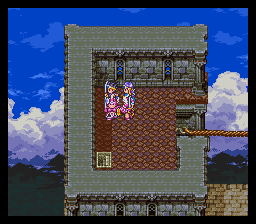

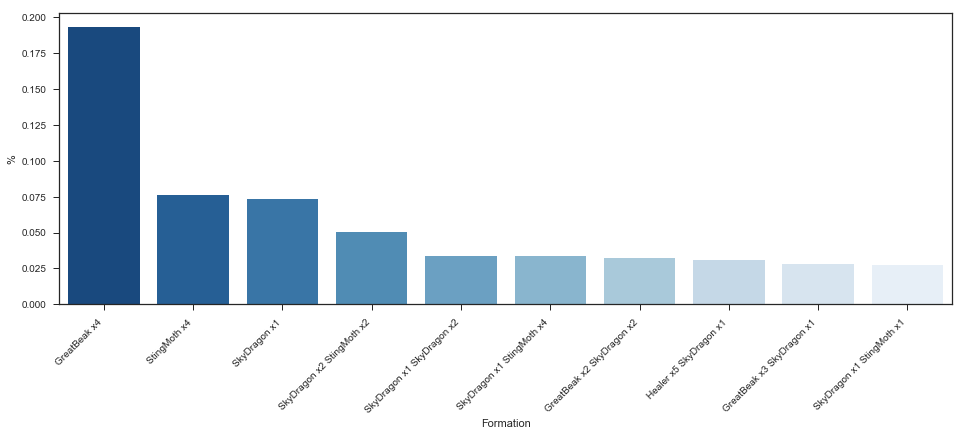

                                                  Formation         %
GreatBeak x4                                           1932  0.193219
StingMoth x4                                            759  0.075908
SkyDragon x1                                            733  0.073307
SkyDragon x2 StingMoth x2                               502  0.050205
SkyDragon x1 SkyDragon x2                               336  0.033603
SkyDragon x1 StingMoth x4                               335  0.033503
GreatBeak x2 SkyDragon x2                               324  0.032403
Healer x5 SkyDragon x1                                  310  0.031003
GreatBeak x3 SkyDragon x1                               284  0.028403
SkyDragon x1 StingMoth x1                               271  0.027103
Healer x1 StingMoth x1                                  269  0.026903
GreatBeak x3 Healer x3                                  244  0.024402
Healer x2 SkyDragon x2                                  244  0.024402
Healer x4 StingMoth 

**Garuna Tower F3**

-----


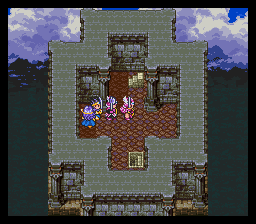

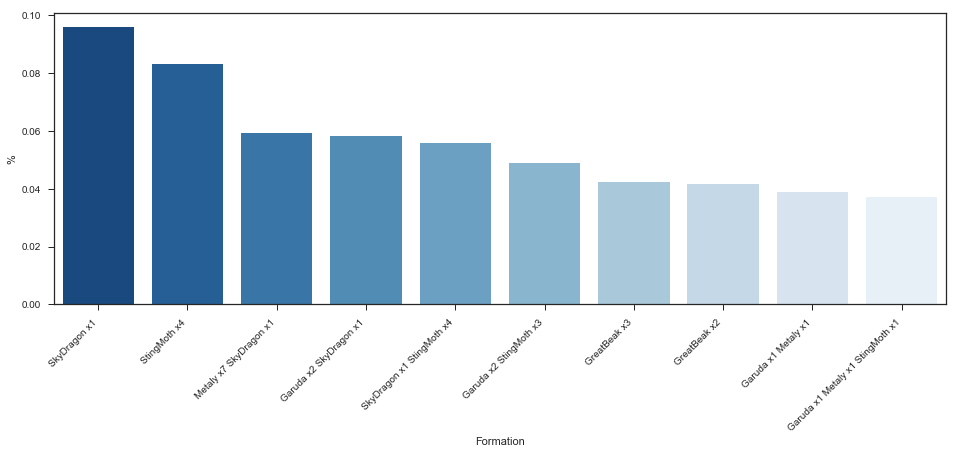

                                  Formation         %
SkyDragon x1                            960  0.096010
StingMoth x4                            832  0.083208
Metaly x7 SkyDragon x1                  594  0.059406
Garuda x2 SkyDragon x1                  582  0.058206
SkyDragon x1 StingMoth x4               557  0.055706
Garuda x2 StingMoth x3                  489  0.048905
GreatBeak x3                            424  0.042404
GreatBeak x2                            415  0.041504
Garuda x1 Metaly x1                     388  0.038804
Garuda x1 Metaly x1 StingMoth x1        372  0.037204
Garuda x1 StingMoth x1                  361  0.036104
Garuda x2 Metaly x4                     342  0.034203
Metaly x1 StingMoth x1                  326  0.032603
Metaly x4 StingMoth x4                  299  0.029903
Metaly x6                               276  0.027603
Garuda x2 StingMoth x2                  271  0.027103
Metaly x7                               260  0.026003
Metaly x3                   

**Garuna Tower F4**

-----


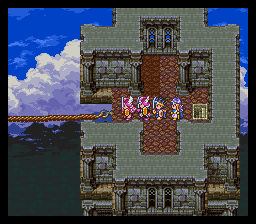

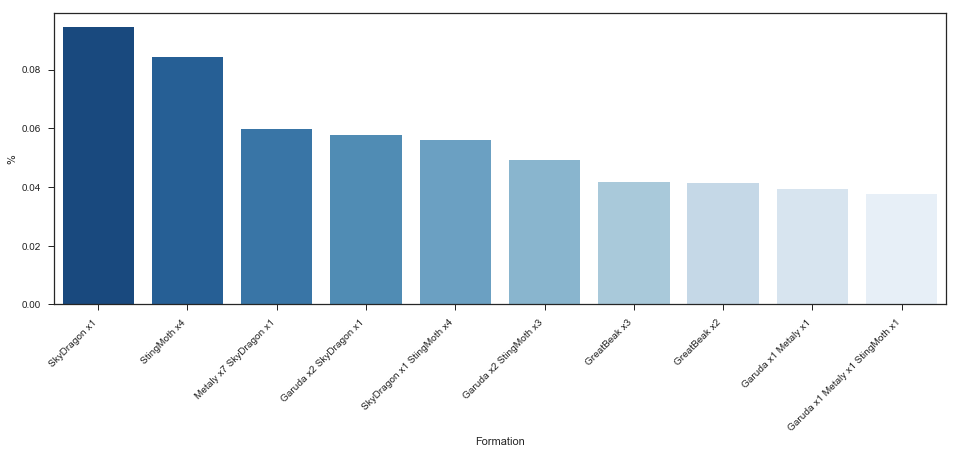

                                  Formation         %
SkyDragon x1                            946  0.094609
StingMoth x4                            841  0.084108
Metaly x7 SkyDragon x1                  598  0.059806
Garuda x2 SkyDragon x1                  577  0.057706
SkyDragon x1 StingMoth x4               560  0.056006
Garuda x2 StingMoth x3                  493  0.049305
GreatBeak x3                            417  0.041704
GreatBeak x2                            412  0.041204
Garuda x1 Metaly x1                     394  0.039404
Garuda x1 Metaly x1 StingMoth x1        377  0.037704
Garuda x1 StingMoth x1                  370  0.037004
Garuda x2 Metaly x4                     361  0.036104
Metaly x1 StingMoth x1                  330  0.033003
Metaly x4 StingMoth x4                  288  0.028803
Garuda x2 StingMoth x2                  265  0.026503
Garuda x2 Metaly x3 StingMoth x2        259  0.025903
Metaly x6                               258  0.025803
Metaly x3                   

**Garuna Tower F5**

-----


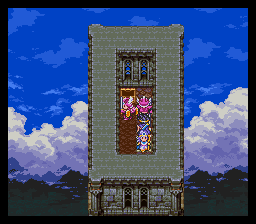

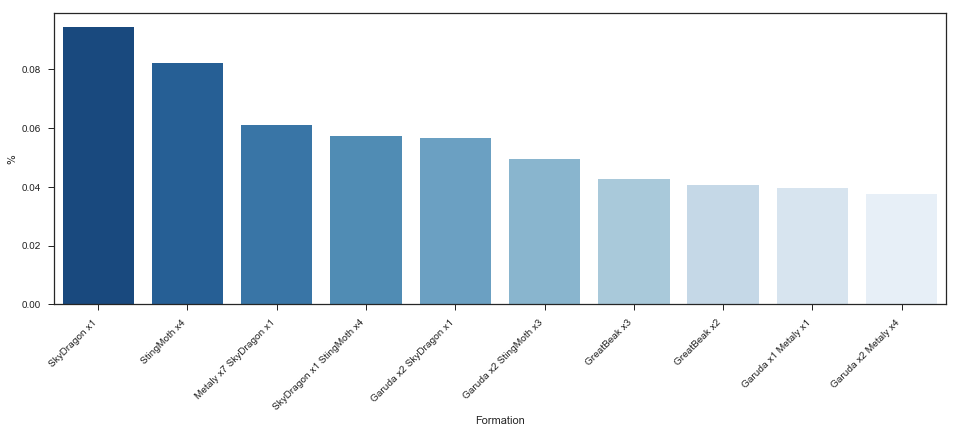

                                  Formation         %
SkyDragon x1                            943  0.094309
StingMoth x4                            821  0.082108
Metaly x7 SkyDragon x1                  609  0.060906
SkyDragon x1 StingMoth x4               572  0.057206
Garuda x2 SkyDragon x1                  565  0.056506
Garuda x2 StingMoth x3                  494  0.049405
GreatBeak x3                            426  0.042604
GreatBeak x2                            404  0.040404
Garuda x1 Metaly x1                     394  0.039404
Garuda x2 Metaly x4                     375  0.037504
Garuda x1 StingMoth x1                  372  0.037204
Garuda x1 Metaly x1 StingMoth x1        369  0.036904
Metaly x1 StingMoth x1                  312  0.031203
Metaly x4 StingMoth x4                  302  0.030203
Metaly x3                               261  0.026103
Metaly x6                               258  0.025803
Garuda x2 Metaly x3 StingMoth x2        255  0.025503
Metaly x4                   

**Gaia's Navel F1**

-----


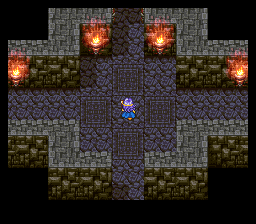

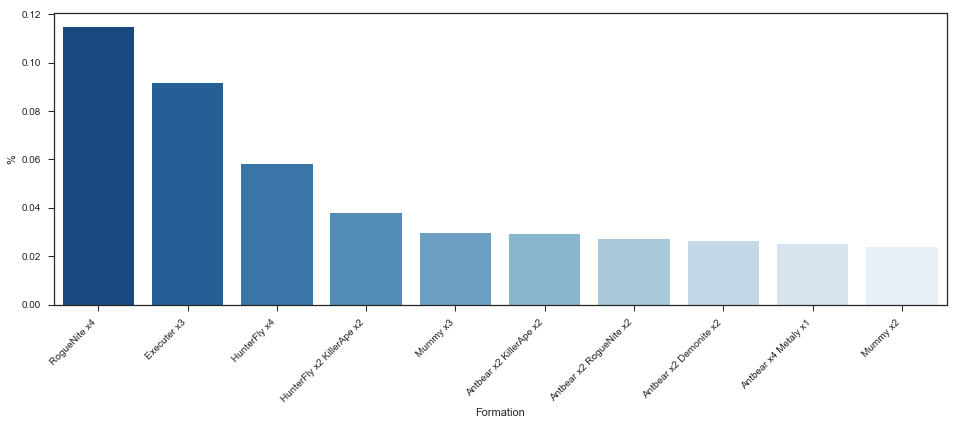

                                                    Formation         %
RogueNite x4                                             1147  0.114711
Executer x3                                               916  0.091609
HunterFly x4                                              579  0.057906
HunterFly x2 KillerApe x2                                 378  0.037804
Mummy x3                                                  294  0.029403
Antbear x2 KillerApe x2                                   292  0.029203
Antbear x2 RogueNite x2                                   270  0.027003
Antbear x2 Demonite x2                                    262  0.026203
Antbear x4 Metaly x1                                      249  0.024902
Mummy x2                                                  240  0.024002
HunterFly x4 Metaly x1                                    236  0.023602
KillerApe x3 Metaly x1                                    227  0.022702
Demonite x2 RogueNite x2                                  224  0

**Gaia's Navel B1**

-----


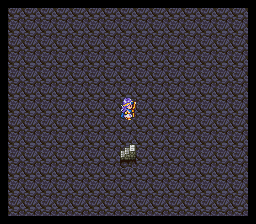

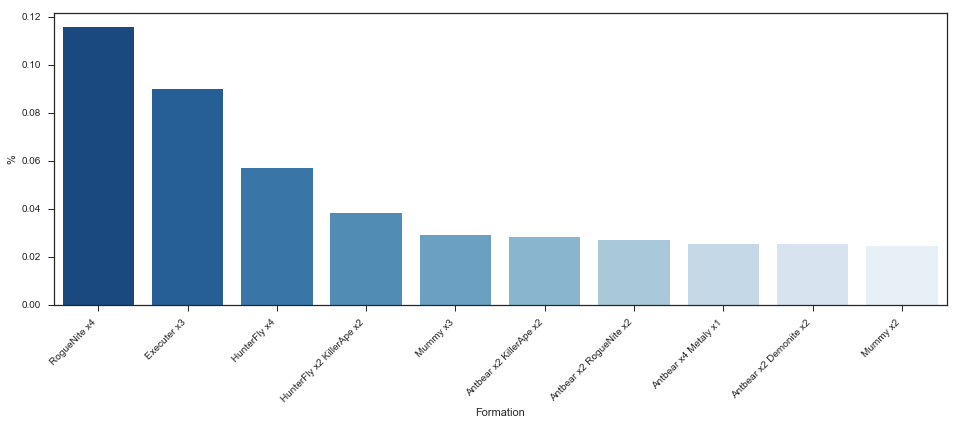

                                                    Formation         %
RogueNite x4                                             1157  0.115712
Executer x3                                               899  0.089909
HunterFly x4                                              569  0.056906
HunterFly x2 KillerApe x2                                 381  0.038104
Mummy x3                                                  292  0.029203
Antbear x2 KillerApe x2                                   281  0.028103
Antbear x2 RogueNite x2                                   268  0.026803
Antbear x4 Metaly x1                                      254  0.025403
Antbear x2 Demonite x2                                    252  0.025203
Mummy x2                                                  245  0.024502
Demonite x4 Metaly x1                                     236  0.023602
KillerApe x3 Metaly x1                                    227  0.022702
KillerApe x2 RogueNite x2                                 226  0

**Gaia's Navel B2**

-----


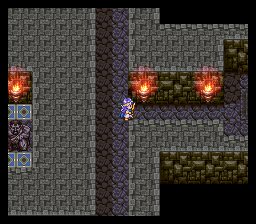

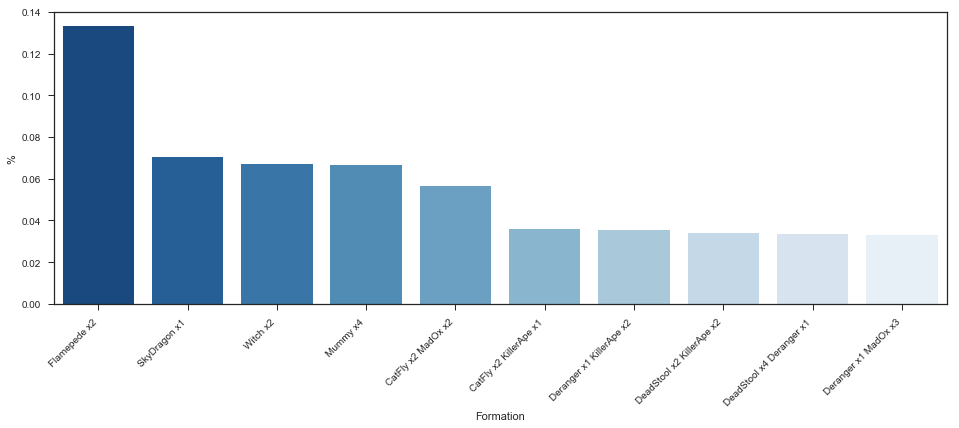

                                              Formation         %
Flamepede x2                                       1331  0.133113
SkyDragon x1                                        705  0.070507
Witch x2                                            672  0.067207
Mummy x4                                            664  0.066407
CatFly x2 MadOx x2                                  567  0.056706
CatFly x2 KillerApe x1                              358  0.035804
Deranger x1 KillerApe x2                            354  0.035404
DeadStool x2 KillerApe x2                           341  0.034103
DeadStool x4 Deranger x1                            333  0.033303
Deranger x1 MadOx x3                                329  0.032903
CatFly x2 DeadStool x3                              309  0.030903
CatFly x3 Deranger x1                               307  0.030703
CatFly x1 DeadStool x1 KillerApe x1 MadOx x1        281  0.028103
CatFly x1 MadOx x1                                  278  0.027803
DeadStool 

**Ra Mirror Cave F1**

-----


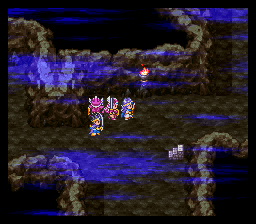

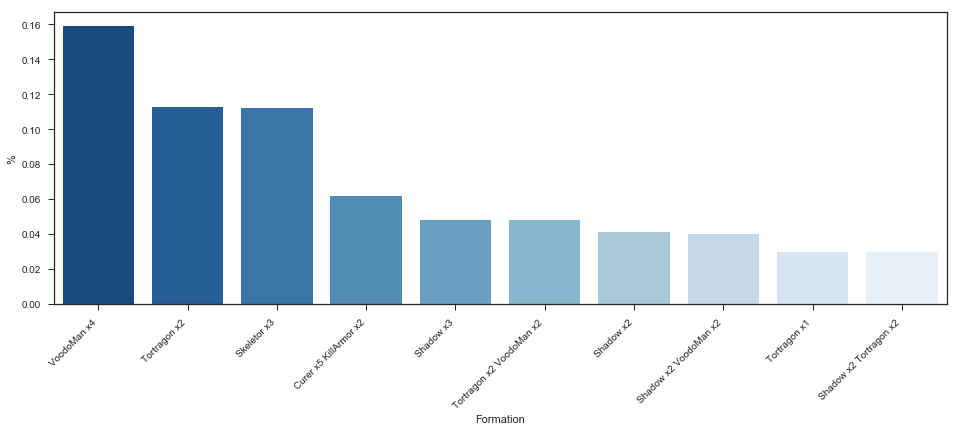

                                                  Formation         %
VoodoMan x4                                            1589  0.158916
Tortragon x2                                           1125  0.112511
Skeletor x3                                            1122  0.112211
Curer x5 KillArmor x2                                   616  0.061606
Shadow x3                                               484  0.048405
Tortragon x2 VoodoMan x2                                481  0.048105
Shadow x2                                               415  0.041504
Shadow x2 VoodoMan x2                                   403  0.040304
Tortragon x1                                            299  0.029903
Shadow x2 Tortragon x2                                  299  0.029903
Skeletor x1 VoodoMan x2                                 274  0.027403
Tortragon x1 VoodoMan x1                                237  0.023702
Curer x4 KillArmor x2                                   216  0.021602
Shadow x1 VoodoMan x

**Zipangu Cave F1**

-----


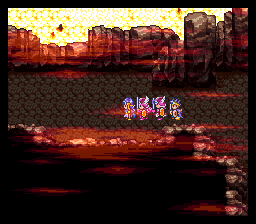

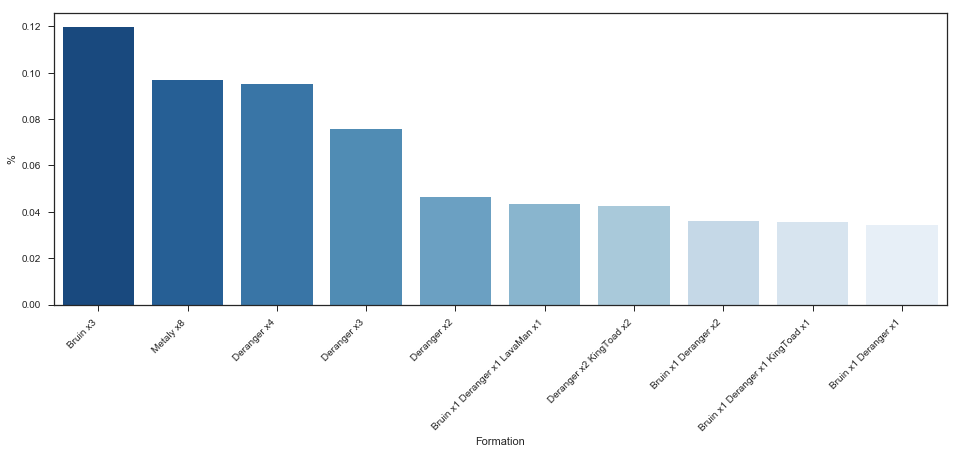

                                    Formation         %
Bruin x3                                 1198  0.119812
Metaly x8                                 970  0.097010
Deranger x4                               953  0.095310
Deranger x3                               756  0.075608
Deranger x2                               466  0.046605
Bruin x1 Deranger x1 LavaMan x1           434  0.043404
Deranger x2 KingToad x2                   425  0.042504
Bruin x1 Deranger x2                      359  0.035904
Bruin x1 Deranger x1 KingToad x1          358  0.035804
Bruin x1 Deranger x1                      342  0.034203
Deranger x2 LavaMan x1                    338  0.033803
Bruin x2 LavaMan x1                       336  0.033603
Bruin x2 Deranger x1                      331  0.033103
Bruin x2 KingToad x1                      316  0.031603
LavaMan x1                                297  0.029703
Deranger x1 LavaMan x1                    268  0.026803
Bruin x1 KingToad x1 LavaMan x1           253  0

**Necrogond F1**

-----


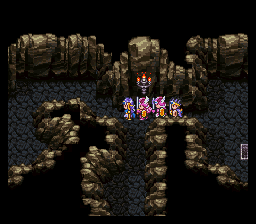

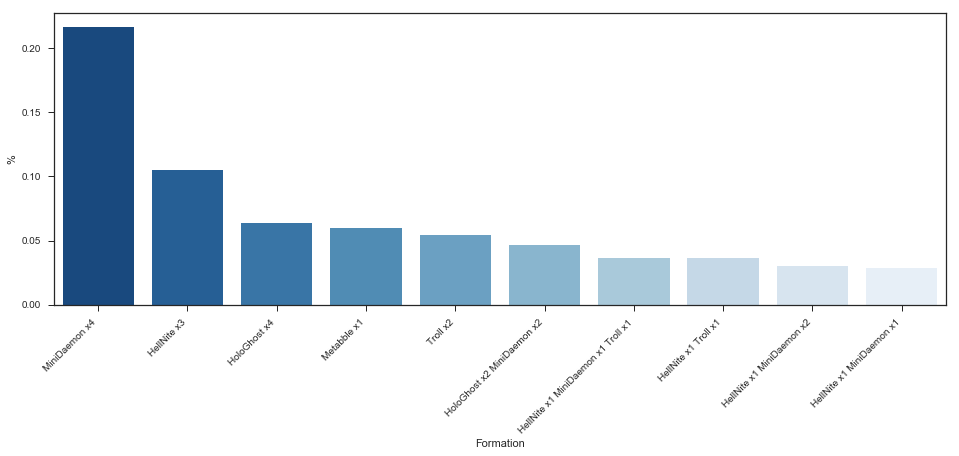

                                        Formation         %
MiniDaemon x4                                2164  0.216422
HellNite x3                                  1053  0.105311
HoloGhost x4                                  634  0.063406
Metabble x1                                   595  0.059506
Troll x2                                      544  0.054405
HoloGhost x2 MiniDaemon x2                    466  0.046605
HellNite x1 MiniDaemon x1 Troll x1            364  0.036404
HellNite x1 Troll x1                          361  0.036104
HellNite x1 MiniDaemon x2                     298  0.029803
HellNite x1 MiniDaemon x1                     288  0.028803
HellNite x1 HoloGhost x1 MiniDaemon x1        286  0.028603
HellNite x2 MiniDaemon x1                     275  0.027503
HoloGhost x1 MiniDaemon x1 Troll x1           264  0.026403
MiniDaemon x2 Troll x1                        257  0.025703
MiniDaemon x3                                 244  0.024402
HoloGhost x1 MiniDaemon x1              

**Necrogond B1**

-----


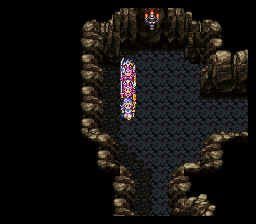

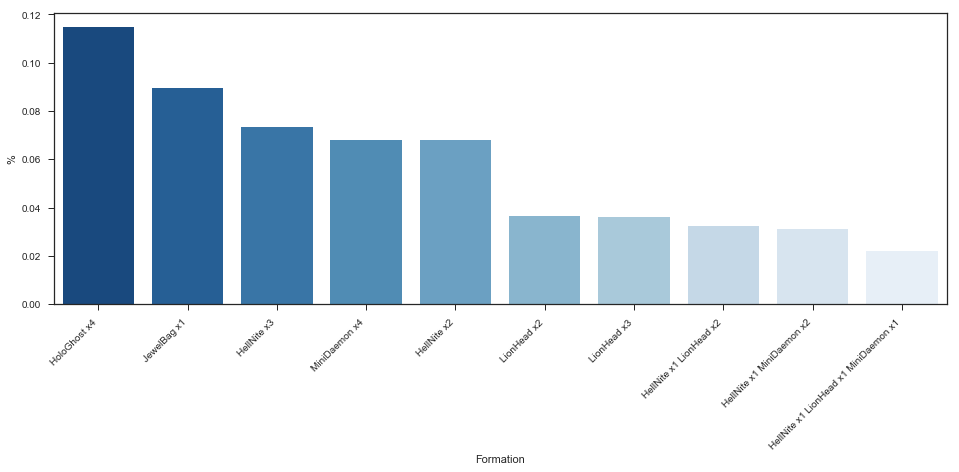

                                                   Formation         %
HoloGhost x4                                            1150  0.115012
JewelBag x1                                              895  0.089509
HellNite x3                                              735  0.073507
MiniDaemon x4                                            682  0.068207
HellNite x2                                              679  0.067907
LionHead x2                                              365  0.036504
LionHead x3                                              361  0.036104
HellNite x1 LionHead x2                                  323  0.032303
HellNite x1 MiniDaemon x2                                313  0.031303
HellNite x1 LionHead x1 MiniDaemon x1                    222  0.022202
HellNite x1 LionHead x1                                  212  0.021202
IceCloud x2 MiniDaemon x2                                207  0.020702
IceCloud x2 LionHead x2                                  201  0.020102
Metabb

**Necrogond B2**

-----


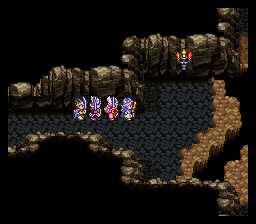

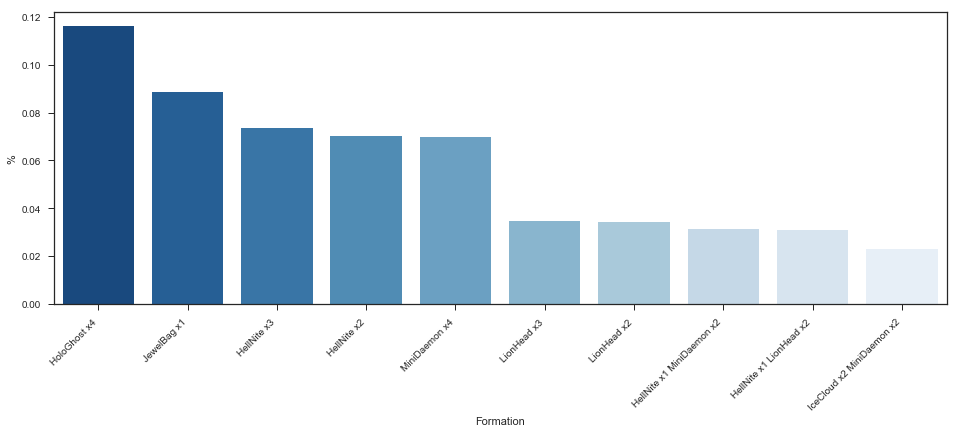

                                                   Formation         %
HoloGhost x4                                            1161  0.116112
JewelBag x1                                              886  0.088609
HellNite x3                                              736  0.073607
HellNite x2                                              700  0.070007
MiniDaemon x4                                            698  0.069807
LionHead x3                                              348  0.034803
LionHead x2                                              344  0.034403
HellNite x1 MiniDaemon x2                                311  0.031103
HellNite x1 LionHead x2                                  309  0.030903
IceCloud x2 MiniDaemon x2                                228  0.022802
HellNite x1 LionHead x1                                  222  0.022202
HellNite x1 LionHead x1 MiniDaemon x1                    213  0.021302
IceCloud x2 LionHead x2                                  211  0.021102
HellNi

**Necrogond B3**

-----


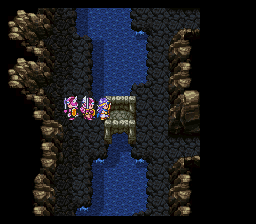

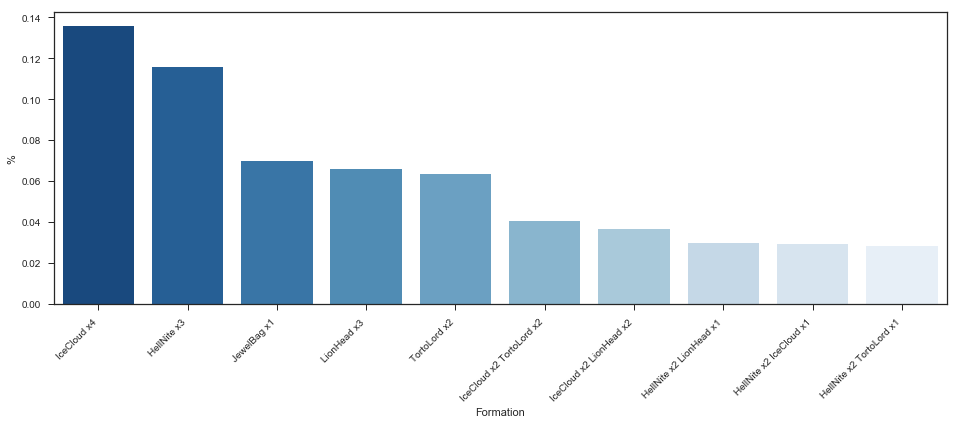

                                      Formation         %
IceCloud x4                                1356  0.135614
HellNite x3                                1155  0.115512
JewelBag x1                                 695  0.069507
LionHead x3                                 656  0.065607
TortoLord x2                                636  0.063606
IceCloud x2 TortoLord x2                    403  0.040304
IceCloud x2 LionHead x2                     363  0.036304
HellNite x2 LionHead x1                     296  0.029603
HellNite x2 IceCloud x1                     294  0.029403
HellNite x2 TortoLord x1                    280  0.028003
HellNite x1 LionHead x1 TortoLord x1        263  0.026303
LionHead x1 TortoLord x1                    243  0.024302
HellNite x1 LionHead x1                     233  0.023302
LionHead x2 TortoLord x1                    231  0.023102
HellNite x1 IceCloud x1 LionHead x1         227  0.022702
HellNite x1 TortoLord x1                    224  0.022402
HellNite x1 Li

**Baramos Castle Outer**

-----


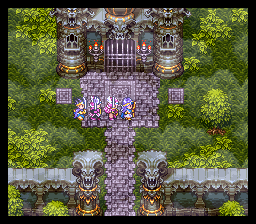

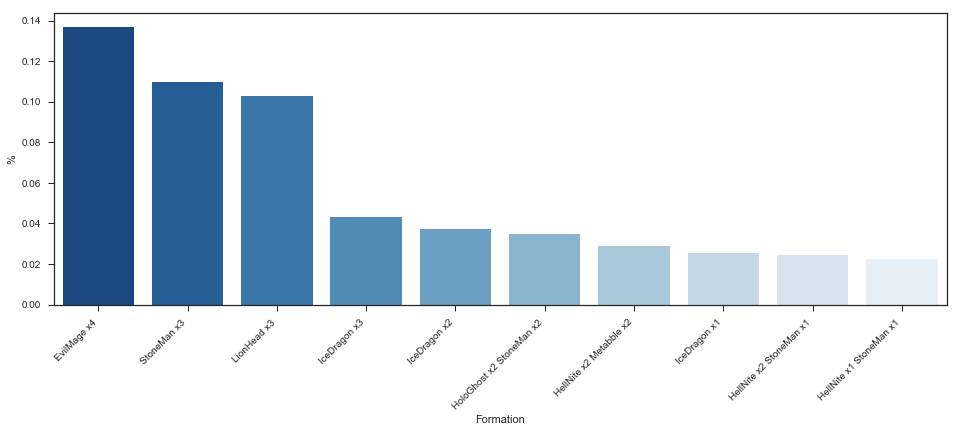

                                                  Formation         %
EvilMage x4                                            1369  0.136914
StoneMan x3                                            1097  0.109711
LionHead x3                                            1028  0.102810
IceDragon x3                                            430  0.043004
IceDragon x2                                            371  0.037104
HoloGhost x2 StoneMan x2                                348  0.034803
HellNite x2 Metabble x2                                 287  0.028703
IceDragon x1                                            255  0.025503
HellNite x2 StoneMan x1                                 245  0.024502
HellNite x1 StoneMan x1                                 227  0.022702
HellNite x2 HoloGhost x1                                221  0.022102
EvilMage x2 HoloGhost x2                                205  0.020502
EvilMage x1 StoneMan x2                                 190  0.019002
EvilMage x1 HellNite

**Baramos Castle F1**

-----


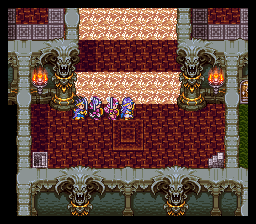

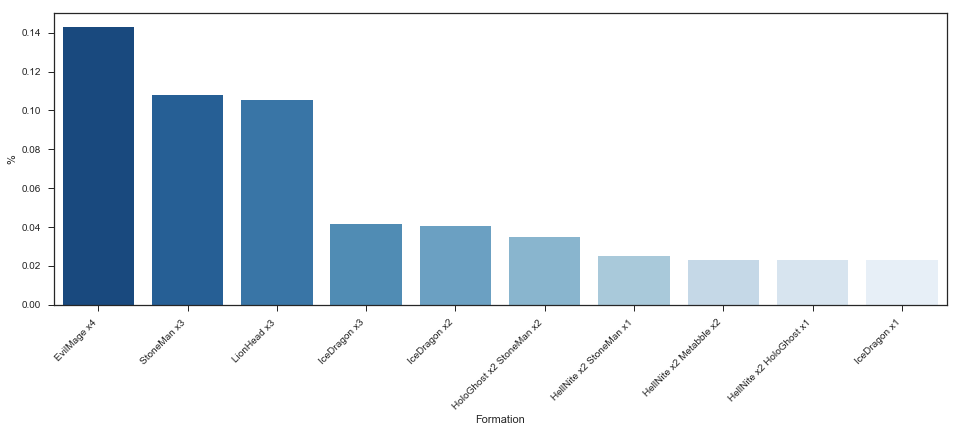

                                                  Formation         %
EvilMage x4                                            1430  0.143014
StoneMan x3                                            1080  0.108011
LionHead x3                                            1054  0.105411
IceDragon x3                                            414  0.041404
IceDragon x2                                            405  0.040504
HoloGhost x2 StoneMan x2                                348  0.034803
HellNite x2 StoneMan x1                                 248  0.024802
HellNite x2 Metabble x2                                 231  0.023102
HellNite x2 HoloGhost x1                                227  0.022702
IceDragon x1                                            227  0.022702
EvilMage x2 HoloGhost x2                                207  0.020702
HellNite x1 StoneMan x1                                 205  0.020502
EvilMage x1 HellNite x2                                 204  0.020402
HellNite x1 StoneMan

**Baramos Castle B1**

-----


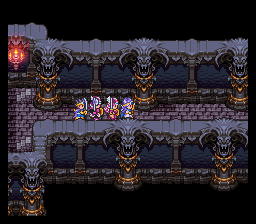

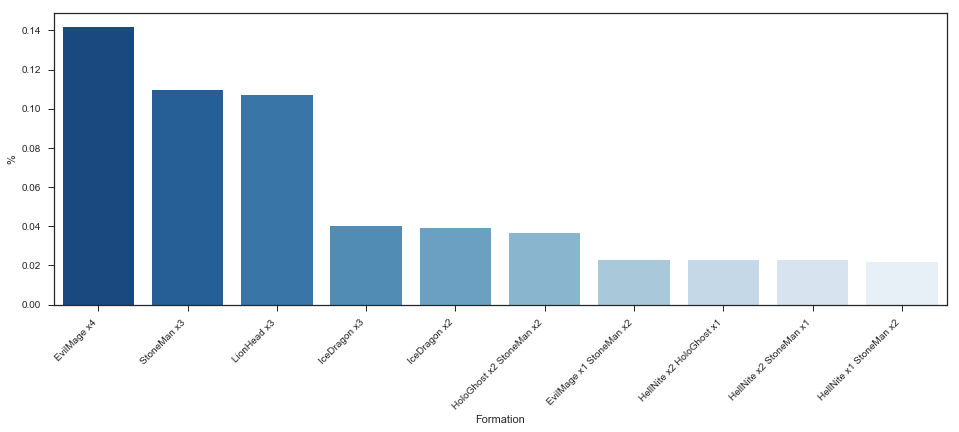

                                                  Formation         %
EvilMage x4                                            1418  0.141814
StoneMan x3                                            1094  0.109411
LionHead x3                                            1072  0.107211
IceDragon x3                                            403  0.040304
IceDragon x2                                            392  0.039204
HoloGhost x2 StoneMan x2                                365  0.036504
EvilMage x1 StoneMan x2                                 229  0.022902
HellNite x2 HoloGhost x1                                226  0.022602
HellNite x2 StoneMan x1                                 226  0.022602
HellNite x1 StoneMan x2                                 216  0.021602
IceDragon x1                                            216  0.021602
EvilMage x1 HellNite x2                                 210  0.021002
HellNite x2 Metabble x2                                 206  0.020602
EvilMage x2 HoloGhos

**Mountain Cave F1**

-----


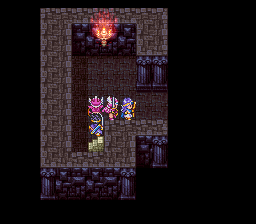

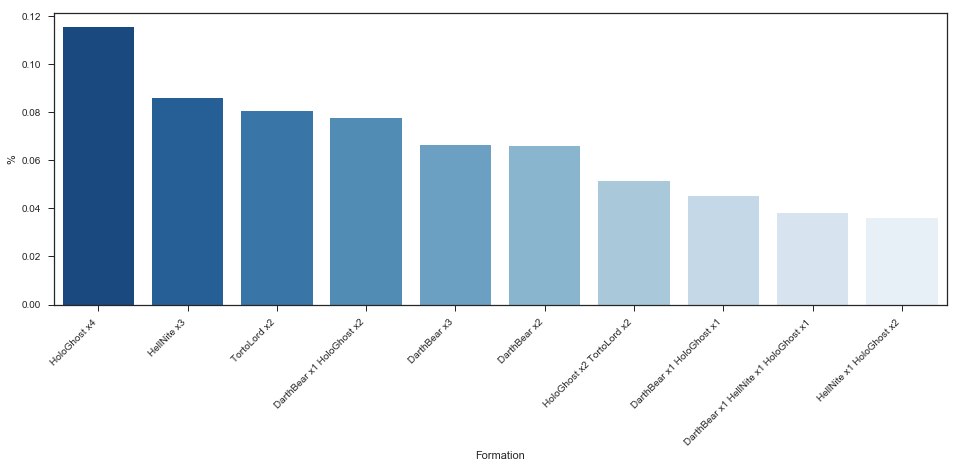

                                        Formation         %
HoloGhost x4                                 1155  0.115512
HellNite x3                                   859  0.085909
TortoLord x2                                  807  0.080708
DarthBear x1 HoloGhost x2                     775  0.077508
DarthBear x3                                  665  0.066507
DarthBear x2                                  661  0.066107
HoloGhost x2 TortoLord x2                     515  0.051505
DarthBear x1 HoloGhost x1                     450  0.045005
DarthBear x1 HellNite x1 HoloGhost x1         382  0.038204
HellNite x1 HoloGhost x2                      362  0.036204
Goopi x2                                      320  0.032003
Goopi x3                                      316  0.031603
HoloGhost x1 TortoLord x1                     237  0.023702
JewelBag x1                                   211  0.021102
DarthBear x1 HoloGhost x1 TortoLord x1        203  0.020302
HellNite x1 HoloGhost x1                

**Mountain Cave B1**

-----


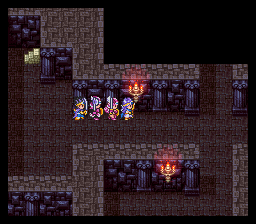

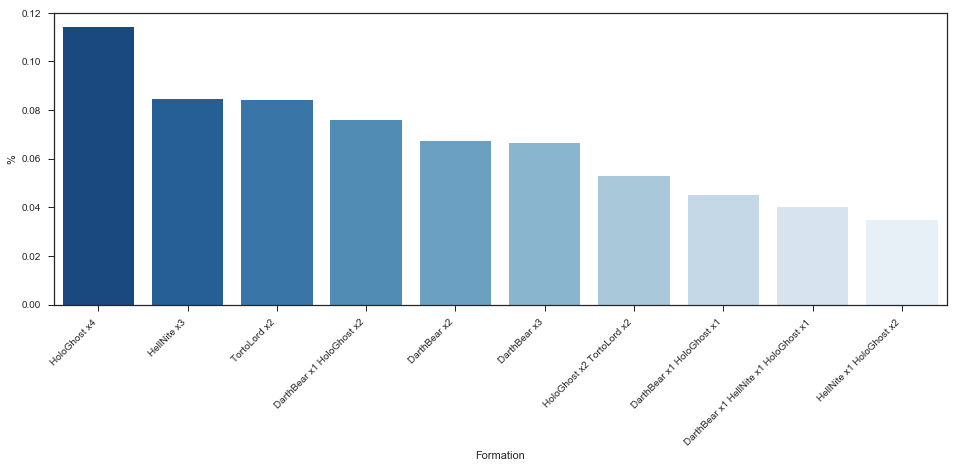

                                        Formation         %
HoloGhost x4                                 1142  0.114211
HellNite x3                                   846  0.084608
TortoLord x2                                  840  0.084008
DarthBear x1 HoloGhost x2                     759  0.075908
DarthBear x2                                  673  0.067307
DarthBear x3                                  664  0.066407
HoloGhost x2 TortoLord x2                     528  0.052805
DarthBear x1 HoloGhost x1                     449  0.044904
DarthBear x1 HellNite x1 HoloGhost x1         401  0.040104
HellNite x1 HoloGhost x2                      346  0.034603
Goopi x2                                      321  0.032103
Goopi x3                                      299  0.029903
HoloGhost x1 TortoLord x1                     246  0.024602
DarthBear x1 HoloGhost x1 TortoLord x1        220  0.022002
HellNite x1 HoloGhost x1                      215  0.021502
JewelBag x1                             

**Rubiss Tower F1**

-----


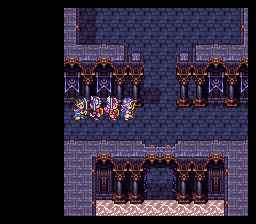

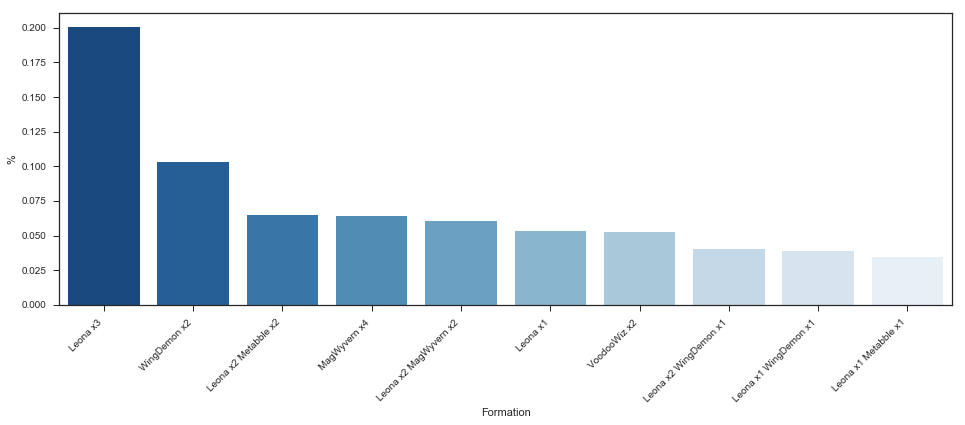

                                                Formation         %
Leona x3                                             2005  0.200520
WingDemon x2                                         1029  0.102910
Leona x2 Metabble x2                                  651  0.065107
MagWyvern x4                                          642  0.064206
Leona x2 MagWyvern x2                                 604  0.060406
Leona x1                                              536  0.053605
VoodooWiz x2                                          526  0.052605
Leona x2 WingDemon x1                                 400  0.040004
Leona x1 WingDemon x1                                 389  0.038904
Leona x1 Metabble x1                                  344  0.034403
Leona x1 MagWyvern x1                                 311  0.031103
Leona x1 WingDemon x2                                 292  0.029203
Leona x1 MagWyvern x1 WingDemon x1                    259  0.025903
MagWyvern x2 WingDemon x2                       

**Rubiss Tower F2**

-----


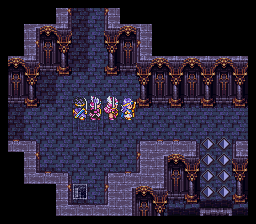

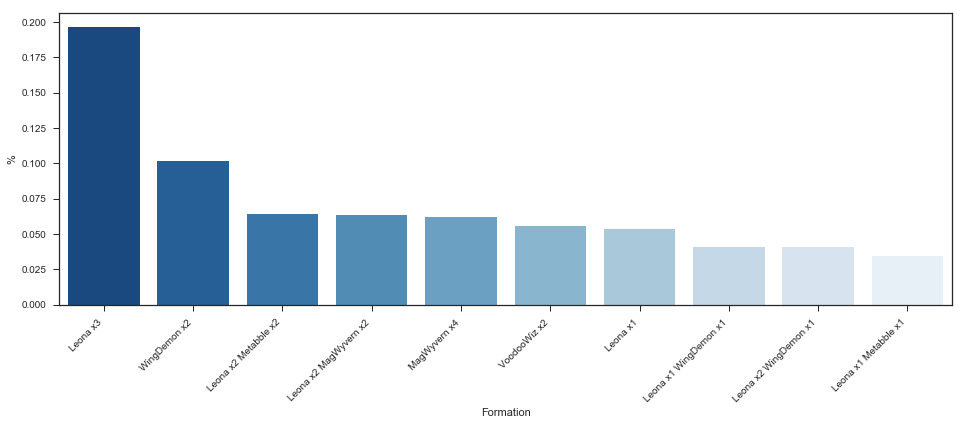

                                                Formation         %
Leona x3                                             1965  0.196520
WingDemon x2                                         1019  0.101910
Leona x2 Metabble x2                                  641  0.064106
Leona x2 MagWyvern x2                                 634  0.063406
MagWyvern x4                                          622  0.062206
VoodooWiz x2                                          560  0.056006
Leona x1                                              533  0.053305
Leona x1 WingDemon x1                                 407  0.040704
Leona x2 WingDemon x1                                 407  0.040704
Leona x1 Metabble x1                                  346  0.034603
Leona x1 MagWyvern x1                                 314  0.031403
Leona x1 WingDemon x2                                 274  0.027403
Leona x1 MagWyvern x1 WingDemon x1                    267  0.026703
MagWyvern x2 WingDemon x2                       

**Rubiss Tower F3**

-----


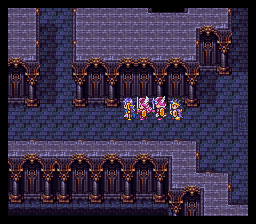

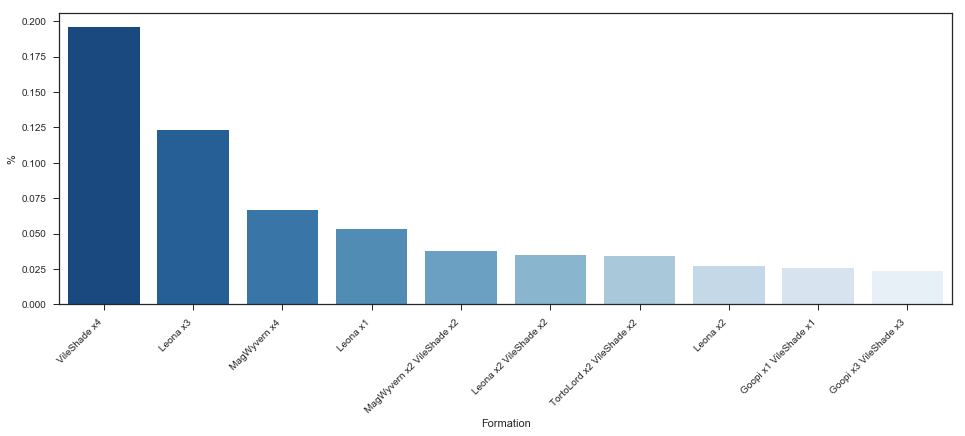

                                                 Formation         %
VileShade x4                                          1960  0.196020
Leona x3                                              1232  0.123212
MagWyvern x4                                           670  0.067007
Leona x1                                               531  0.053105
MagWyvern x2 VileShade x2                              379  0.037904
Leona x2 VileShade x2                                  352  0.035204
TortoLord x2 VileShade x2                              340  0.034003
Leona x2                                               270  0.027003
Goopi x1 VileShade x1                                  259  0.025903
Goopi x3 VileShade x3                                  235  0.023502
Leona x2 MagWyvern x2                                  220  0.022002
MagWyvern x1 VileShade x1                              208  0.020802
TortoLord x1 VileShade x1                              174  0.017402
Leona x1 VileShade x1             

**Rubiss Tower F6**

-----


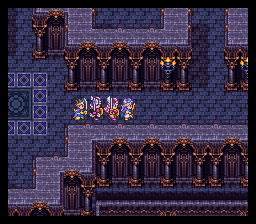

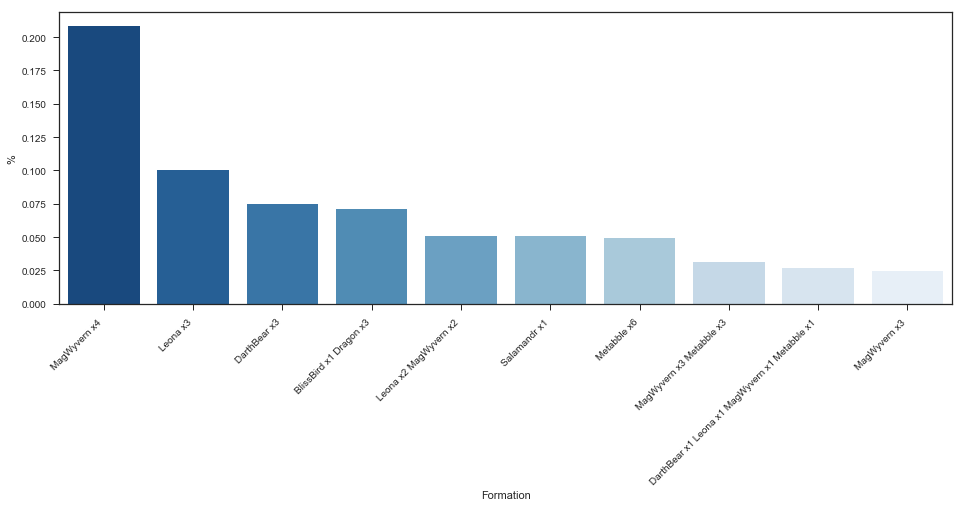

                                                Formation         %
MagWyvern x4                                         2082  0.208221
Leona x3                                             1001  0.100110
DarthBear x3                                          746  0.074607
BlissBird x1 Dragon x3                                710  0.071007
Leona x2 MagWyvern x2                                 509  0.050905
Salamandr x1                                          509  0.050905
Metabble x6                                           493  0.049305
MagWyvern x3 Metabble x3                              311  0.031103
DarthBear x1 Leona x1 MagWyvern x1 Metabble x1        272  0.027203
MagWyvern x3                                          248  0.024802
Leona x1 MagWyvern x1                                 247  0.024702
DarthBear x1 MagWyvern x2                             236  0.023602
MagWyvern x2                                          225  0.022502
DarthBear x1 Leona x1 MagWyvern x1              

**Zoma's Castle F1**

-----


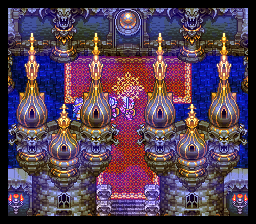

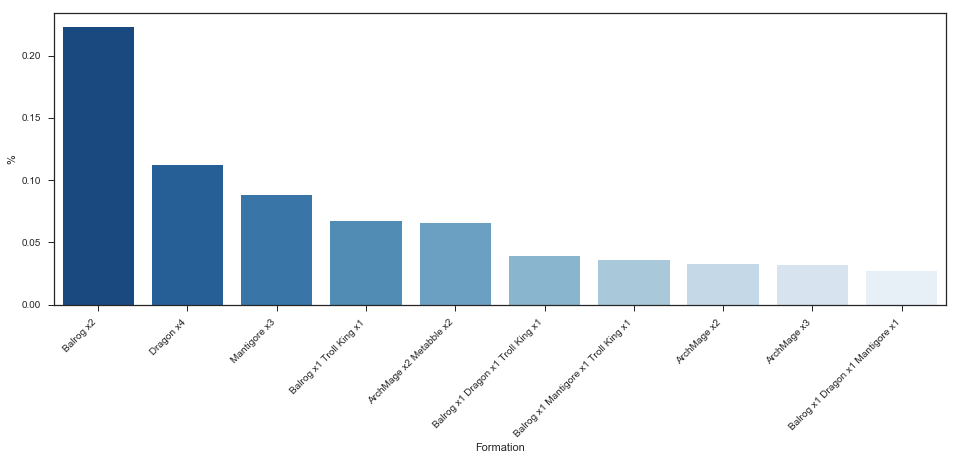

                                      Formation         %
Balrog x2                                  2228  0.222822
Dragon x4                                  1118  0.111811
Mantigore x3                                883  0.088309
Balrog x1 Troll King x1                     669  0.066907
ArchMage x2 Metabble x2                     659  0.065907
Balrog x1 Dragon x1 Troll King x1           393  0.039304
Balrog x1 Mantigore x1 Troll King x1        360  0.036004
ArchMage x2                                 329  0.032903
ArchMage x3                                 323  0.032303
Balrog x1 Dragon x1 Mantigore x1            268  0.026803
Balrog x2 Troll King x1                     264  0.026403
Balrog x2 Mantigore x1                      253  0.025303
Balrog x1 Dragon x1                         241  0.024102
Balrog x2 Dragon x1                         237  0.023702
Balrog x1 Mantigore x1                      204  0.020402
Balrog x1 Dragon x2                         192  0.019202
Mantigore x1 T

**Zoma's Castle B2**

-----


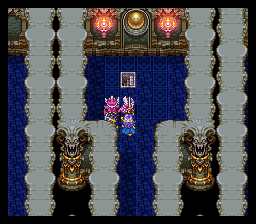

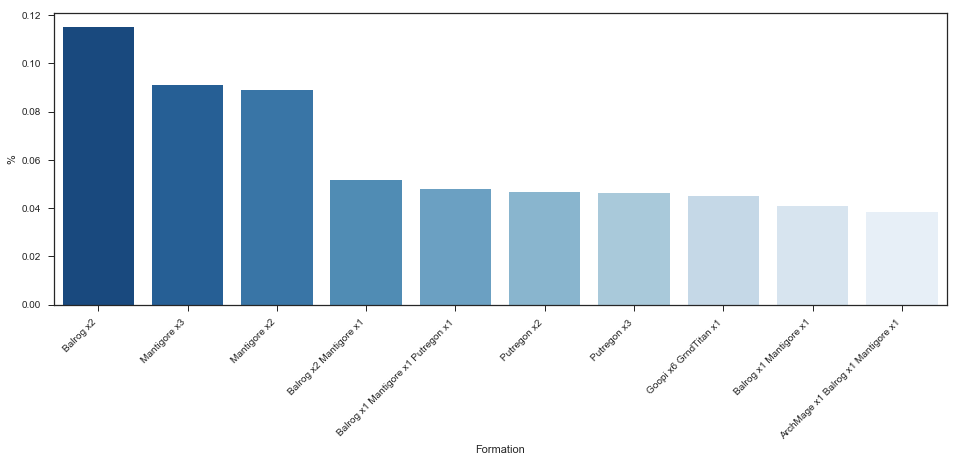

                                      Formation         %
Balrog x2                                  1151  0.115112
Mantigore x3                                911  0.091109
Mantigore x2                                890  0.089009
Balrog x2 Mantigore x1                      515  0.051505
Balrog x1 Mantigore x1 Putregon x1          478  0.047805
Putregon x2                                 467  0.046705
Putregon x3                                 464  0.046405
Goopi x6 GrndTitan x1                       450  0.045005
Balrog x1 Mantigore x1                      409  0.040904
ArchMage x1 Balrog x1 Mantigore x1          382  0.038204
ArchMage x1 Mantigore x2                    355  0.035504
Mantigore x2 Putregon x1                    345  0.034503
Balrog x1 Mantigore x2                      326  0.032603
ArchMage x1 Mantigore x1 Putregon x1        298  0.029803
Mantigore x1 Putregon x1                    283  0.028303
Balrog x2 Putregon x1                       253  0.025303
Goopi x4 GrndT

**Zoma's Castle B3**

-----


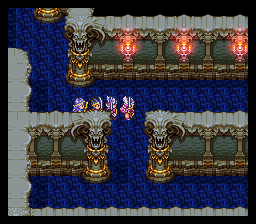

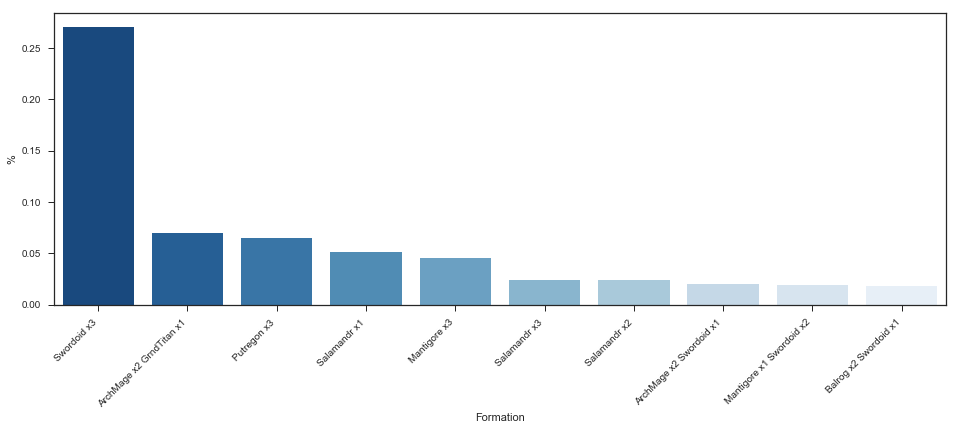

                                      Formation         %
Swordoid x3                                2705  0.270527
ArchMage x2 GrndTitan x1                    701  0.070107
Putregon x3                                 646  0.064606
Salamandr x1                                511  0.051105
Mantigore x3                                458  0.045805
Salamandr x3                                241  0.024102
Salamandr x2                                237  0.023702
ArchMage x2 Swordoid x1                     196  0.019602
Mantigore x1 Swordoid x2                    187  0.018702
Balrog x2 Swordoid x1                       180  0.018002
ArchMage x1 Swordoid x1                     177  0.017702
ArchMage x1 Swordoid x2                     172  0.017202
ArchMage x1 Balrog x1 Swordoid x1           166  0.016602
Balrog x1 Swordoid x1                       166  0.016602
Mantigore x1 Swordoid x1                    158  0.015802
Balrog x1 Mantigore x1 Swordoid x1          156  0.015602
Balrog x1 Swor

**Zoma's Castle B4**

-----


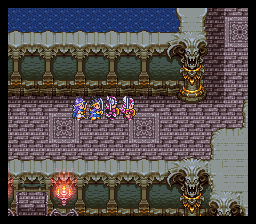

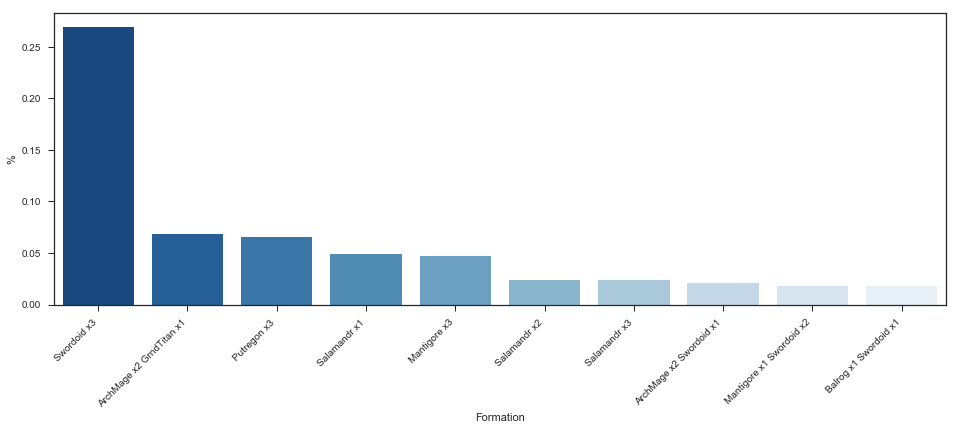

                                      Formation         %
Swordoid x3                                2693  0.269327
ArchMage x2 GrndTitan x1                    689  0.068907
Putregon x3                                 658  0.065807
Salamandr x1                                487  0.048705
Mantigore x3                                470  0.047005
Salamandr x2                                243  0.024302
Salamandr x3                                240  0.024002
ArchMage x2 Swordoid x1                     214  0.021402
Mantigore x1 Swordoid x2                    185  0.018502
Balrog x1 Swordoid x1                       181  0.018102
ArchMage x1 Swordoid x1                     180  0.018002
Balrog x2 Swordoid x1                       174  0.017402
ArchMage x1 Swordoid x2                     168  0.016802
ArchMage x1 Balrog x1 Swordoid x1           166  0.016602
Balrog x1 Mantigore x1 Swordoid x1          163  0.016302
Balrog x1 Swordoid x2                       161  0.016102
Putregon x1 Sw

**Map Type: Overworld**

-----


**Aliahan**

-----


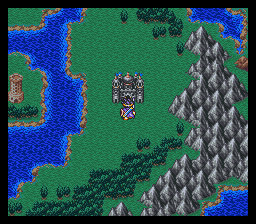

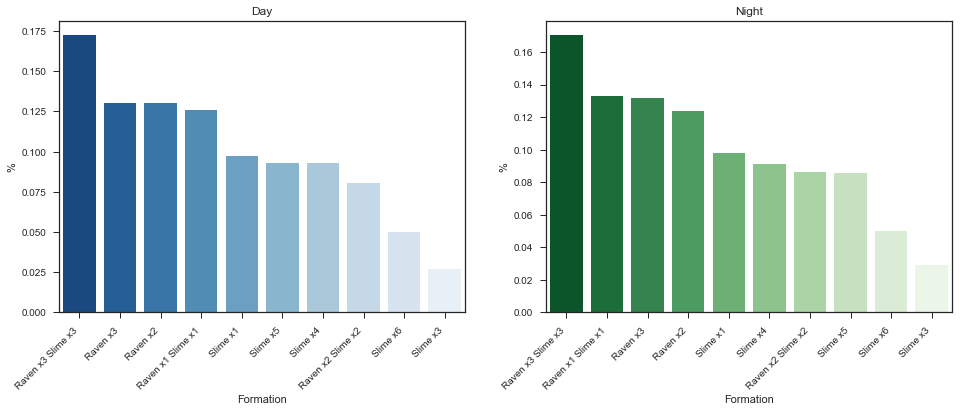

Day:
                   Count         %
Formation                         
Raven x3 Slime x3   1727  0.172717
Raven x3            1304  0.130413
Raven x2            1302  0.130213
Raven x1 Slime x1   1257  0.125713
Slime x1             971  0.097110
Slime x5             931  0.093109
Slime x4             929  0.092909
Raven x2 Slime x2    805  0.080508
Slime x6             503  0.050305
Slime x3             270  0.027003
-----
Night:
                   Count         %
Formation                         
Raven x3 Slime x3   1706  0.170617
Raven x1 Slime x1   1331  0.133113
Raven x3            1320  0.132013
Raven x2            1237  0.123712
Slime x1             977  0.097710
Slime x4             914  0.091409
Raven x2 Slime x2    863  0.086309
Slime x5             858  0.085809
Slime x6             499  0.049905
Slime x3             294  0.029403
-----
-----


**Reeve**

-----


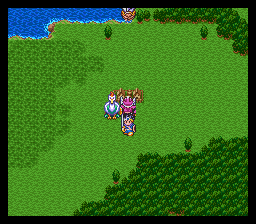

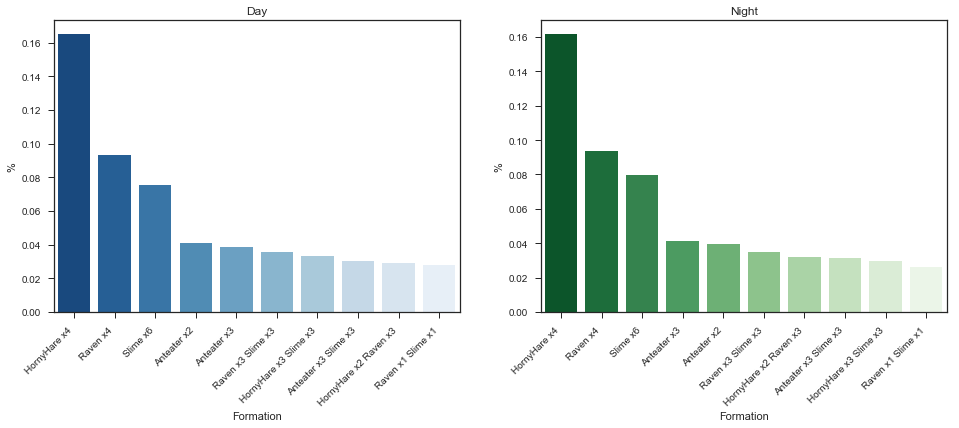

Day:
                       Count         %
Formation                             
HornyHare x4            1649  0.164916
Raven x4                 930  0.093009
Slime x6                 755  0.075508
Anteater x2              408  0.040804
Anteater x3              388  0.038804
Raven x3 Slime x3        356  0.035604
HornyHare x3 Slime x3    335  0.033503
Anteater x3 Slime x3     305  0.030503
HornyHare x2 Raven x3    292  0.029203
Raven x1 Slime x1        276  0.027603
-----
Night:
                       Count         %
Formation                             
HornyHare x4            1616  0.161616
Raven x4                 936  0.093609
Slime x6                 795  0.079508
Anteater x3              411  0.041104
Anteater x2              393  0.039304
Raven x3 Slime x3        348  0.034803
HornyHare x2 Raven x3    319  0.031903
Anteater x3 Slime x3     315  0.031503
HornyHare x3 Slime x3    299  0.029903
Raven x1 Slime x1        264  0.026403
-----
-----


**To Magic Ball**

-----


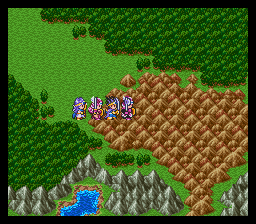

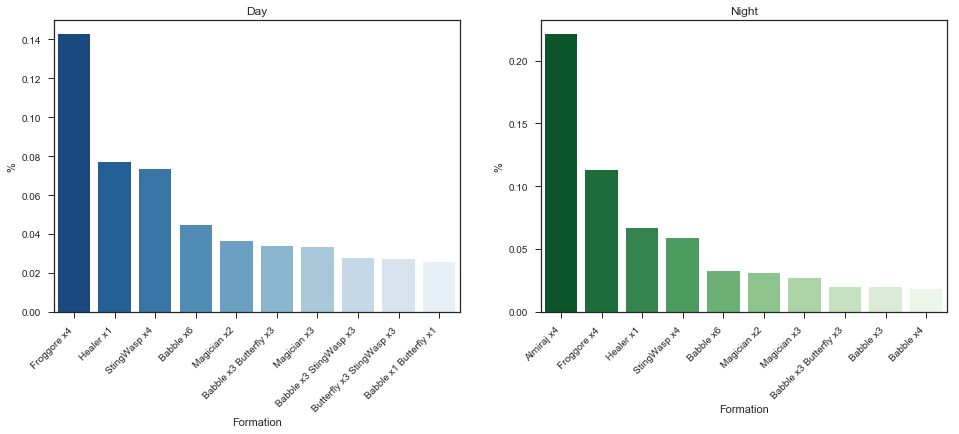

Day:
                           Count         %
Formation                                 
Froggore x4                 1426  0.142614
Healer x1                    770  0.077008
StingWasp x4                 733  0.073307
Babble x6                    447  0.044704
Magician x2                  364  0.036404
Babble x3 Butterfly x3       341  0.034103
Magician x3                  333  0.033303
Babble x3 StingWasp x3       277  0.027703
Butterfly x3 StingWasp x3    271  0.027103
Babble x1 Butterfly x1       254  0.025403
-----
Night:
                        Count         %
Formation                              
Almiraj x4               2209  0.220922
Froggore x4              1129  0.112911
Healer x1                 665  0.066507
StingWasp x4              591  0.059106
Babble x6                 329  0.032903
Magician x2               309  0.030903
Magician x3               271  0.027103
Babble x3 Butterfly x3    198  0.019802
Babble x3                 196  0.019602
Babble x4                 

**Romaly**

-----


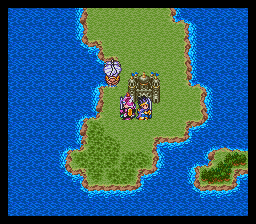

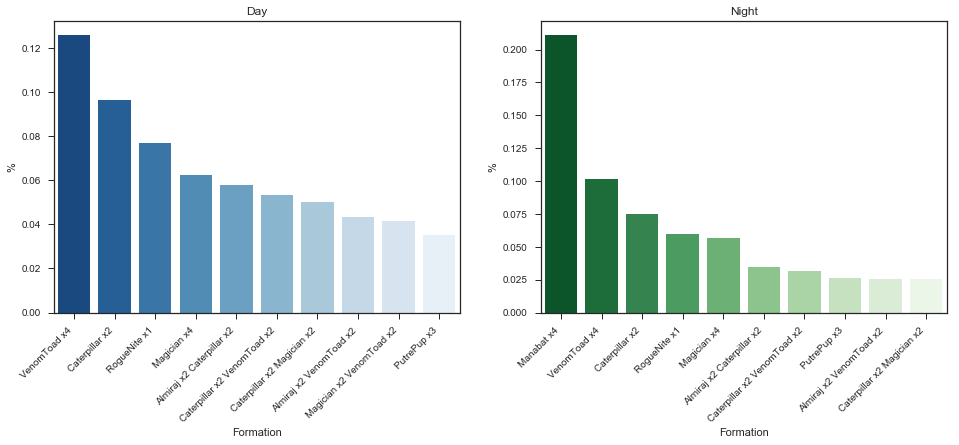

Day:
                             Count         %
Formation                                   
VenomToad x4                  1259  0.125913
Caterpillar x2                 965  0.096510
RogueNite x1                   767  0.076708
Magician x4                    624  0.062406
Almiraj x2 Caterpillar x2      579  0.057906
Caterpillar x2 VenomToad x2    535  0.053505
Caterpillar x2 Magician x2     499  0.049905
Almiraj x2 VenomToad x2        435  0.043504
Magician x2 VenomToad x2       415  0.041504
PutrePup x3                    351  0.035104
-----
Night:
                             Count         %
Formation                                   
Manabat x4                    2112  0.211221
VenomToad x4                  1015  0.101510
Caterpillar x2                 751  0.075108
RogueNite x1                   596  0.059606
Magician x4                    563  0.056306
Almiraj x2 Caterpillar x2      345  0.034503
Caterpillar x2 VenomToad x2    319  0.031903
PutrePup x3                    266  0

**Kazave**

-----


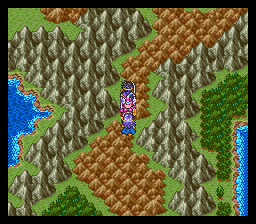

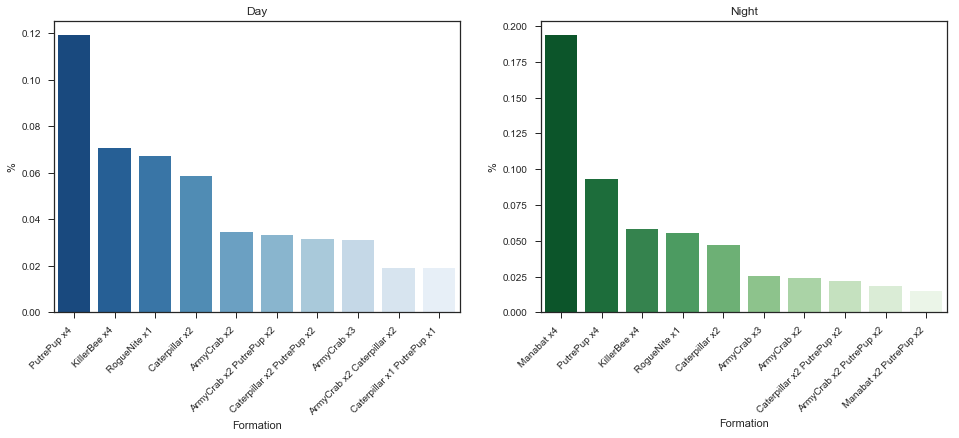

Day:
                            Count         %
Formation                                  
PutrePup x4                  1194  0.119412
KillerBee x4                  705  0.070507
RogueNite x1                  672  0.067207
Caterpillar x2                585  0.058506
ArmyCrab x2                   347  0.034703
ArmyCrab x2 PutrePup x2       332  0.033203
Caterpillar x2 PutrePup x2    314  0.031403
ArmyCrab x3                   313  0.031303
ArmyCrab x2 Caterpillar x2    193  0.019302
Caterpillar x1 PutrePup x1    191  0.019102
-----
Night:
                            Count         %
Formation                                  
Manabat x4                   1939  0.193919
PutrePup x4                   933  0.093309
KillerBee x4                  584  0.058406
RogueNite x1                  554  0.055406
Caterpillar x2                468  0.046805
ArmyCrab x3                   255  0.025503
ArmyCrab x2                   242  0.024202
Caterpillar x2 PutrePup x2    218  0.021802
ArmyCrab x2 Pu

**Portoga**

-----


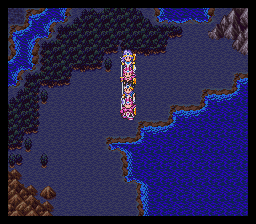

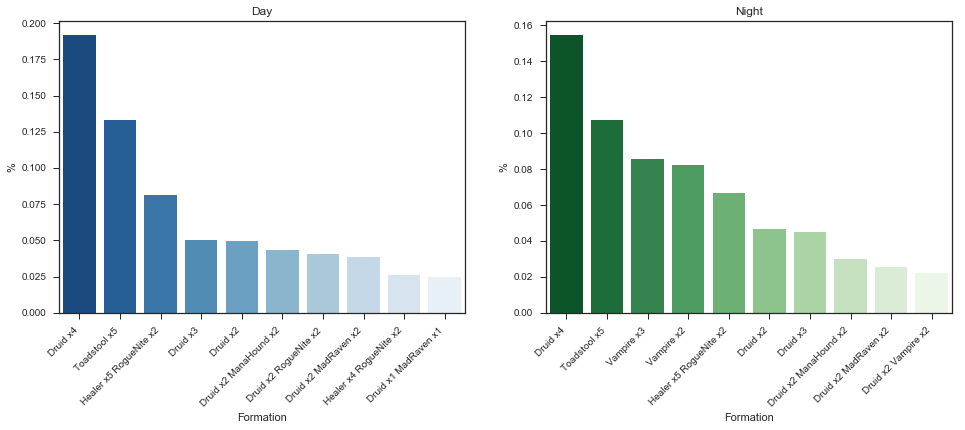

Day:
                        Count         %
Formation                              
Druid x4                 1917  0.191719
Toadstool x5             1329  0.132913
Healer x5 RogueNite x2    812  0.081208
Druid x3                  505  0.050505
Druid x2                  495  0.049505
Druid x2 ManaHound x2     433  0.043304
Druid x2 RogueNite x2     403  0.040304
Druid x2 MadRaven x2      382  0.038204
Healer x4 RogueNite x2    263  0.026303
Druid x1 MadRaven x1      245  0.024502
-----
Night:
                        Count         %
Formation                              
Druid x4                 1545  0.154515
Toadstool x5             1072  0.107211
Vampire x3                857  0.085709
Vampire x2                820  0.082008
Healer x5 RogueNite x2    669  0.066907
Druid x2                  469  0.046905
Druid x3                  448  0.044804
Druid x2 ManaHound x2     301  0.030103
Druid x2 MadRaven x2      256  0.025603
Druid x2 Vampire x2       223  0.022302
-----
-----


**To Assalam**

-----


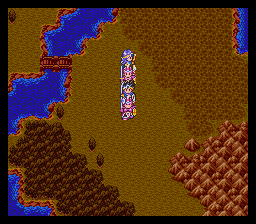

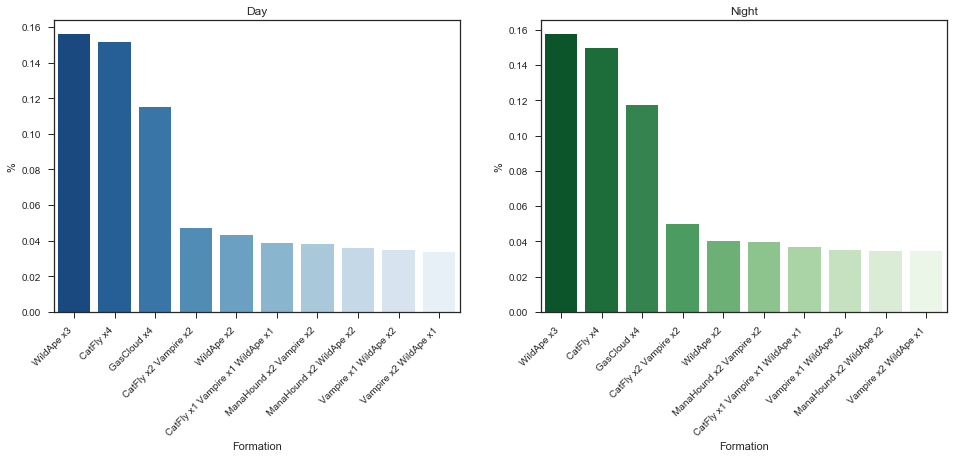

Day:
                                 Count         %
Formation                                       
WildApe x3                        1559  0.155916
CatFly x4                         1516  0.151615
GasCloud x4                       1153  0.115312
CatFly x2 Vampire x2               473  0.047305
WildApe x2                         431  0.043104
CatFly x1 Vampire x1 WildApe x1    387  0.038704
ManaHound x2 Vampire x2            382  0.038204
ManaHound x2 WildApe x2            361  0.036104
Vampire x1 WildApe x2              348  0.034803
Vampire x2 WildApe x1              334  0.033403
-----
Night:
                                 Count         %
Formation                                       
WildApe x3                        1574  0.157416
CatFly x4                         1495  0.149515
GasCloud x4                       1172  0.117212
CatFly x2 Vampire x2               497  0.049705
WildApe x2                         405  0.040504
ManaHound x2 Vampire x2            396  0.039604
Ca

**Desert**

-----


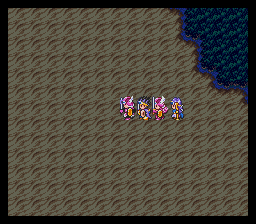

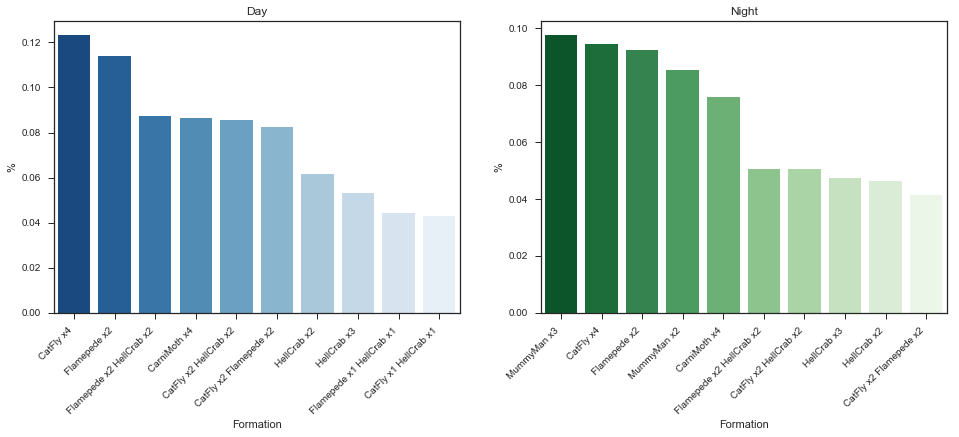

Day:
                          Count         %
Formation                                
CatFly x4                  1232  0.123212
Flamepede x2               1139  0.113911
Flamepede x2 HellCrab x2    873  0.087309
CarniMoth x4                863  0.086309
CatFly x2 HellCrab x2       857  0.085709
CatFly x2 Flamepede x2      824  0.082408
HellCrab x2                 615  0.061506
HellCrab x3                 530  0.053005
Flamepede x1 HellCrab x1    444  0.044404
CatFly x1 HellCrab x1       430  0.043004
-----
Night:
                          Count         %
Formation                                
MummyMan x3                 976  0.097610
CatFly x4                   946  0.094609
Flamepede x2                922  0.092209
MummyMan x2                 854  0.085409
CarniMoth x4                758  0.075808
Flamepede x2 HellCrab x2    507  0.050705
CatFly x2 HellCrab x2       505  0.050505
HellCrab x3                 473  0.047305
HellCrab x2                 465  0.046505
CatFly x2 Flamep

**Isis**

-----


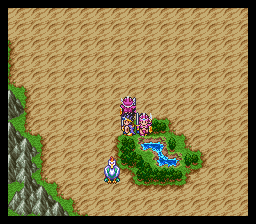

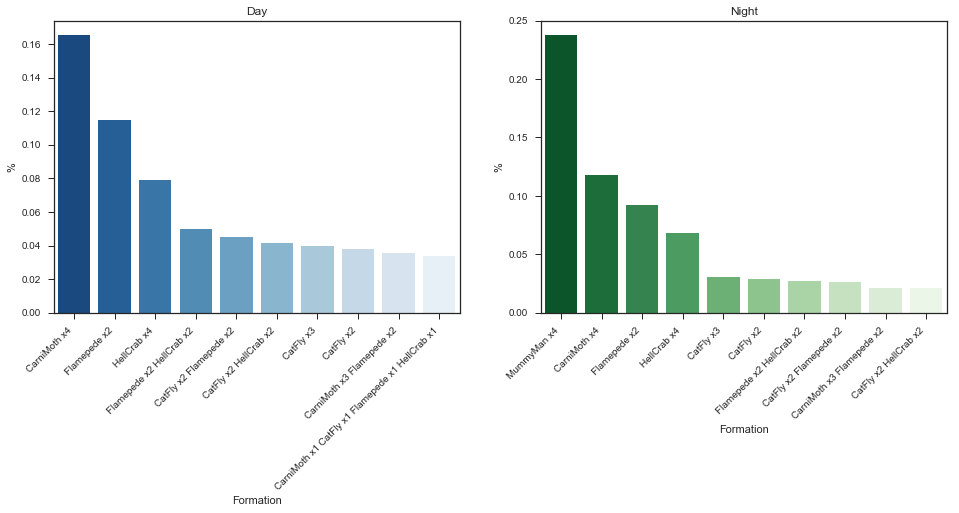

Day:
                                                 Count         %
Formation                                                       
CarniMoth x4                                      1654  0.165417
Flamepede x2                                      1147  0.114711
HellCrab x4                                        792  0.079208
Flamepede x2 HellCrab x2                           499  0.049905
CatFly x2 Flamepede x2                             448  0.044804
CatFly x2 HellCrab x2                              416  0.041604
CatFly x3                                          396  0.039604
CatFly x2                                          382  0.038204
CarniMoth x3 Flamepede x2                          356  0.035604
CarniMoth x1 CatFly x1 Flamepede x1 HellCrab x1    335  0.033503
-----
Night:
                           Count         %
Formation                                 
MummyMan x4                 2377  0.237724
CarniMoth x4                1175  0.117512
Flamepede x2                 9

**Baharata (1)**

-----


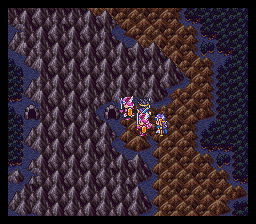

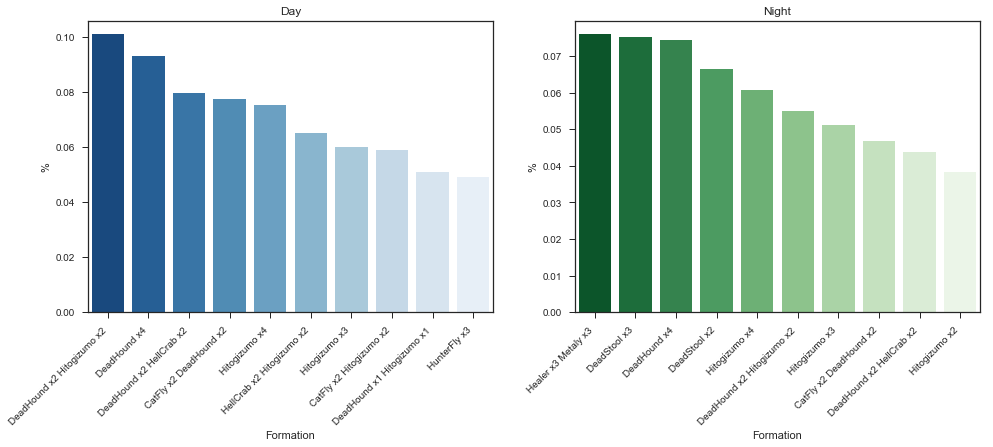

Day:
                            Count         %
Formation                                  
DeadHound x2 Hitogizumo x2   1008  0.100810
DeadHound x4                  930  0.093009
DeadHound x2 HellCrab x2      795  0.079508
CatFly x2 DeadHound x2        775  0.077508
Hitogizumo x4                 752  0.075208
HellCrab x2 Hitogizumo x2     651  0.065107
Hitogizumo x3                 599  0.059906
CatFly x2 Hitogizumo x2       589  0.058906
DeadHound x1 Hitogizumo x1    507  0.050705
HunterFly x3                  489  0.048905
-----
Night:
                            Count         %
Formation                                  
Healer x3 Metaly x3           759  0.075908
DeadStool x3                  751  0.075108
DeadHound x4                  743  0.074307
DeadStool x2                  664  0.066407
Hitogizumo x4                 606  0.060606
DeadHound x2 Hitogizumo x2    549  0.054905
Hitogizumo x3                 512  0.051205
CatFly x2 DeadHound x2        468  0.046805
DeadHound x2 H

**Baharata (2)**

-----


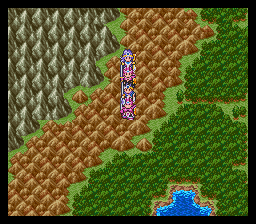

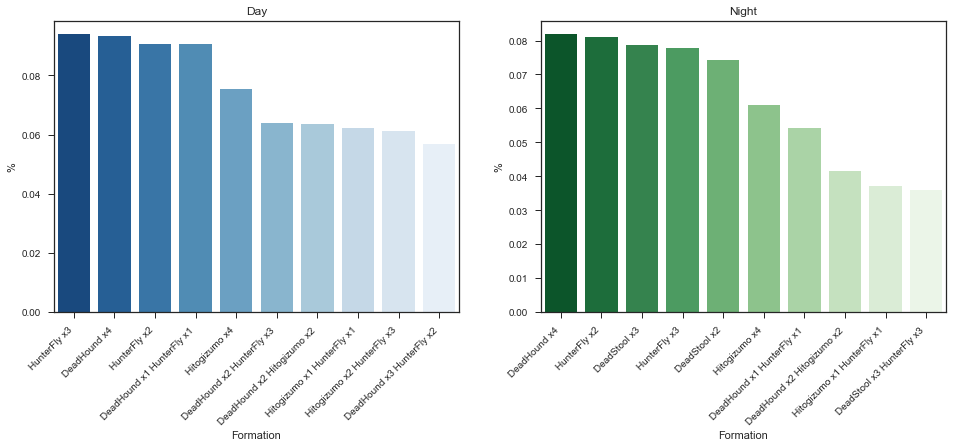

Day:
                            Count         %
Formation                                  
HunterFly x3                  938  0.093809
DeadHound x4                  932  0.093209
HunterFly x2                  907  0.090709
DeadHound x1 HunterFly x1     905  0.090509
Hitogizumo x4                 752  0.075208
DeadHound x2 HunterFly x3     640  0.064006
DeadHound x2 Hitogizumo x2    635  0.063506
Hitogizumo x1 HunterFly x1    623  0.062306
Hitogizumo x2 HunterFly x3    612  0.061206
DeadHound x3 HunterFly x2     569  0.056906
-----
Night:
                            Count         %
Formation                                  
DeadHound x4                  818  0.081808
HunterFly x2                  811  0.081108
DeadStool x3                  788  0.078808
HunterFly x3                  777  0.077708
DeadStool x2                  742  0.074207
Hitogizumo x4                 610  0.061006
DeadHound x1 HunterFly x1     542  0.054205
DeadHound x2 Hitogizumo x2    416  0.041604
Hitogizumo x1 

**Baharata (3)**

-----


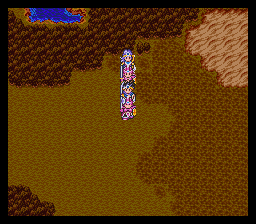

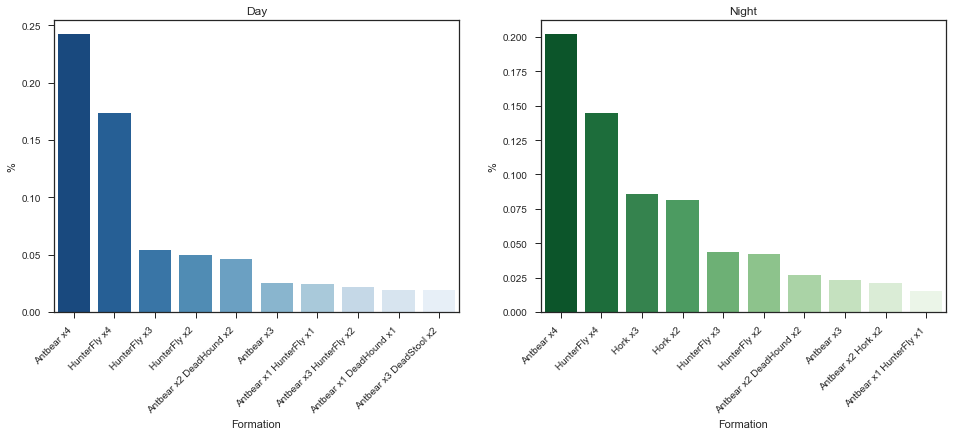

Day:
                         Count         %
Formation                               
Antbear x4                2423  0.242324
HunterFly x4              1736  0.173617
HunterFly x3               540  0.054005
HunterFly x2               493  0.049305
Antbear x2 DeadHound x2    463  0.046305
Antbear x3                 255  0.025503
Antbear x1 HunterFly x1    241  0.024102
Antbear x3 HunterFly x2    213  0.021302
Antbear x1 DeadHound x1    193  0.019302
Antbear x3 DeadStool x2    191  0.019102
-----
Night:
                         Count         %
Formation                               
Antbear x4                2020  0.202020
HunterFly x4              1450  0.145015
Hork x3                    857  0.085709
Hork x2                    811  0.081108
HunterFly x3               435  0.043504
HunterFly x2               421  0.042104
Antbear x2 DeadHound x2    267  0.026703
Antbear x3                 235  0.023502
Antbear x2 Hork x2         211  0.021102
Antbear x1 HunterFly x1    150  0.01500

**To Kandar 2**

-----


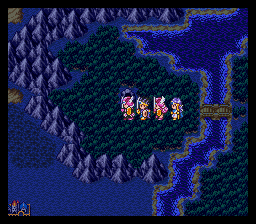

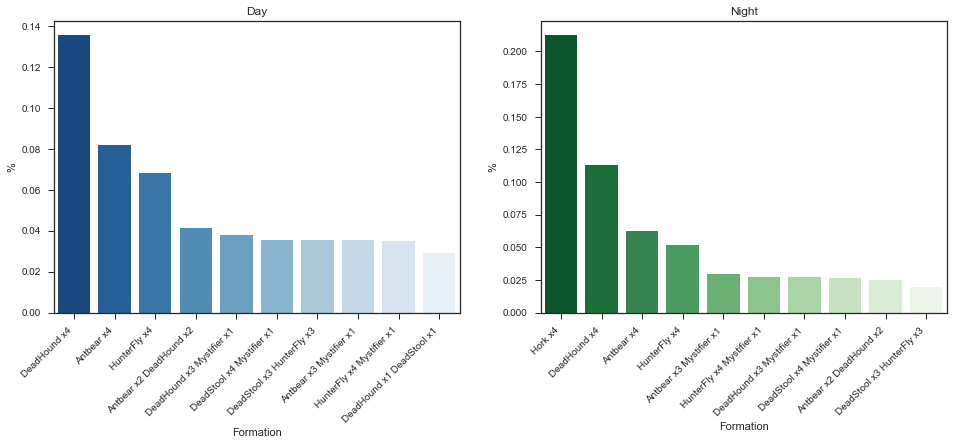

Day:
                           Count         %
Formation                                 
DeadHound x4                1357  0.135714
Antbear x4                   817  0.081708
HunterFly x4                 683  0.068307
Antbear x2 DeadHound x2      413  0.041304
DeadHound x3 Mystifier x1    377  0.037704
DeadStool x4 Mystifier x1    355  0.035504
DeadStool x3 HunterFly x3    354  0.035404
Antbear x3 Mystifier x1      353  0.035304
HunterFly x4 Mystifier x1    349  0.034903
DeadHound x1 DeadStool x1    293  0.029303
-----
Night:
                           Count         %
Formation                                 
Hork x4                     2127  0.212721
DeadHound x4                1131  0.113111
Antbear x4                   625  0.062506
HunterFly x4                 521  0.052105
Antbear x3 Mystifier x1      296  0.029603
HunterFly x4 Mystifier x1    275  0.027503
DeadHound x3 Mystifier x1    273  0.027303
DeadStool x4 Mystifier x1    265  0.026503
Antbear x2 DeadHound x2      248  0.

**Dhama (1)**

-----


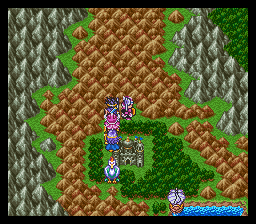

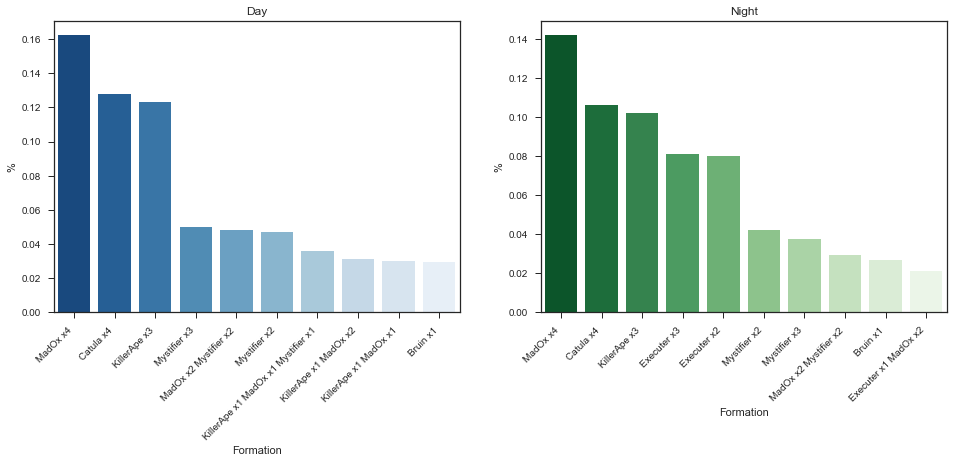

Day:
                                    Count         %
Formation                                          
MadOx x4                             1625  0.162516
Catula x4                            1278  0.127813
KillerApe x3                         1229  0.122912
Mystifier x3                          498  0.049805
MadOx x2 Mystifier x2                 484  0.048405
Mystifier x2                          469  0.046905
KillerApe x1 MadOx x1 Mystifier x1    360  0.036004
KillerApe x1 MadOx x2                 314  0.031403
KillerApe x1 MadOx x1                 301  0.030103
Bruin x1                              294  0.029403
-----
Night:
                       Count         %
Formation                             
MadOx x4                1420  0.142014
Catula x4               1062  0.106211
KillerApe x3            1021  0.102110
Executer x3              808  0.080808
Executer x2              799  0.079908
Mystifier x2             422  0.042204
Mystifier x3             376  0.037604
MadOx x

**Dhama (2)**

-----


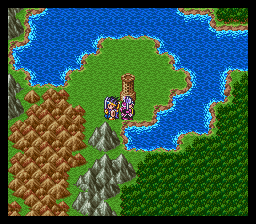

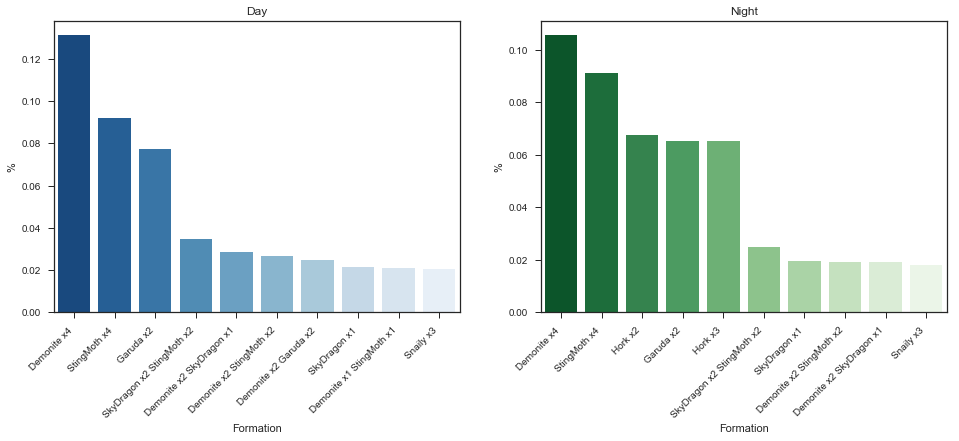

Day:
                           Count         %
Formation                                 
Demonite x4                 1314  0.131413
StingMoth x4                 922  0.092209
Garuda x2                    775  0.077508
SkyDragon x2 StingMoth x2    347  0.034703
Demonite x2 SkyDragon x1     286  0.028603
Demonite x2 StingMoth x2     267  0.026703
Demonite x2 Garuda x2        250  0.025003
SkyDragon x1                 215  0.021502
Demonite x1 StingMoth x1     211  0.021102
Snaily x3                    205  0.020502
-----
Night:
                           Count         %
Formation                                 
Demonite x4                 1057  0.105711
StingMoth x4                 912  0.091209
Hork x2                      676  0.067607
Garuda x2                    653  0.065307
Hork x3                      651  0.065107
SkyDragon x2 StingMoth x2    248  0.024802
SkyDragon x1                 195  0.019502
Demonite x2 StingMoth x2     193  0.019302
Demonite x2 SkyDragon x1     190  0.

**Samanosa (1)**

-----


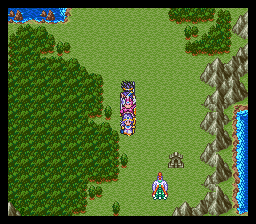

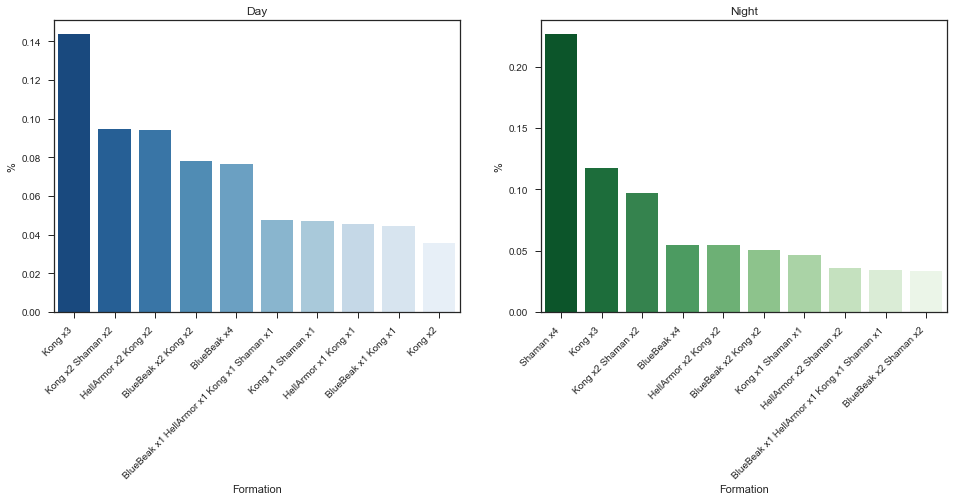

Day:
                                            Count         %
Formation                                                  
Kong x3                                      1437  0.143714
Kong x2 Shaman x2                             945  0.094509
HellArmor x2 Kong x2                          943  0.094309
BlueBeak x2 Kong x2                           784  0.078408
BlueBeak x4                                   768  0.076808
BlueBeak x1 HellArmor x1 Kong x1 Shaman x1    478  0.047805
Kong x1 Shaman x1                             473  0.047305
HellArmor x1 Kong x1                          454  0.045405
BlueBeak x1 Kong x1                           446  0.044604
Kong x2                                       356  0.035604
-----
Night:
                                            Count         %
Formation                                                  
Shaman x4                                    2263  0.226323
Kong x3                                      1175  0.117512
Kong x2 Shaman x2     

**Samanosa (2)**

-----


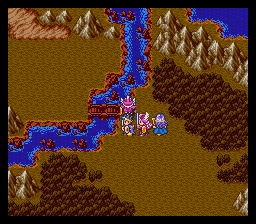

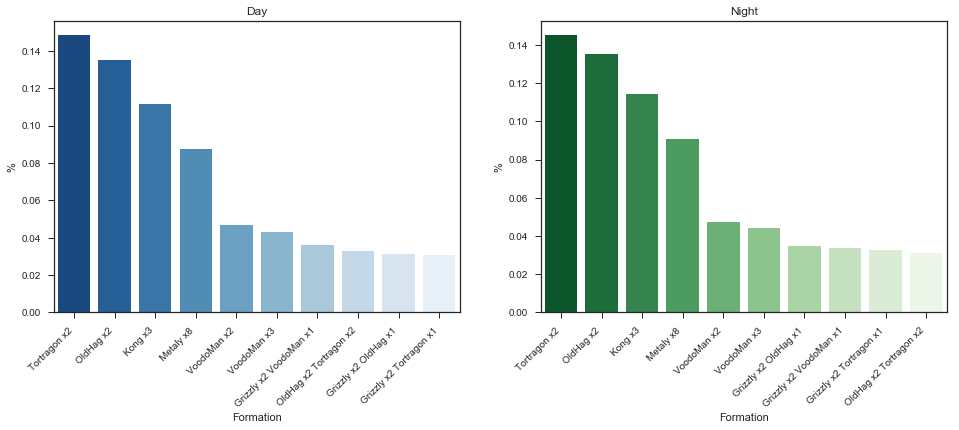

Day:
                         Count         %
Formation                               
Tortragon x2              1486  0.148615
OldHag x2                 1353  0.135314
Kong x3                   1114  0.111411
Metaly x8                  875  0.087509
VoodoMan x2                468  0.046805
VoodoMan x3                432  0.043204
Grizzly x2 VoodoMan x1     361  0.036104
OldHag x2 Tortragon x2     327  0.032703
Grizzly x2 OldHag x1       313  0.031303
Grizzly x2 Tortragon x1    306  0.030603
-----
Night:
                         Count         %
Formation                               
Tortragon x2              1453  0.145315
OldHag x2                 1352  0.135214
Kong x3                   1144  0.114411
Metaly x8                  905  0.090509
VoodoMan x2                471  0.047105
VoodoMan x3                442  0.044204
Grizzly x2 OldHag x1       347  0.034703
Grizzly x2 VoodoMan x1     335  0.033503
Grizzly x2 Tortragon x1    326  0.032603
OldHag x2 Tortragon x2     310  0.03100

**Samanosa (3)**

-----


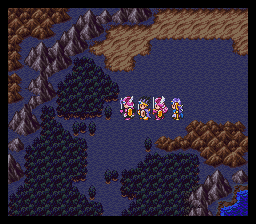

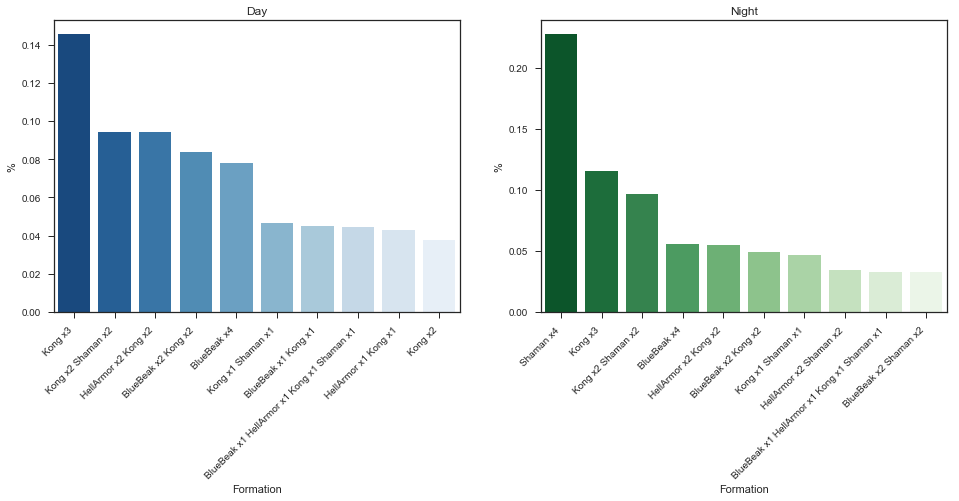

Day:
                                            Count         %
Formation                                                  
Kong x3                                      1454  0.145415
Kong x2 Shaman x2                             941  0.094109
HellArmor x2 Kong x2                          940  0.094009
BlueBeak x2 Kong x2                           836  0.083608
BlueBeak x4                                   780  0.078008
Kong x1 Shaman x1                             468  0.046805
BlueBeak x1 Kong x1                           450  0.045005
BlueBeak x1 HellArmor x1 Kong x1 Shaman x1    445  0.044504
HellArmor x1 Kong x1                          432  0.043204
Kong x2                                       378  0.037804
-----
Night:
                                            Count         %
Formation                                                  
Shaman x4                                    2273  0.227323
Kong x3                                      1156  0.115612
Kong x2 Shaman x2     

**Samanosa (4)**

-----


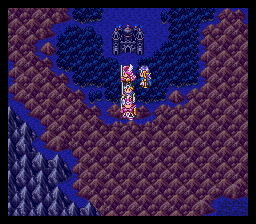

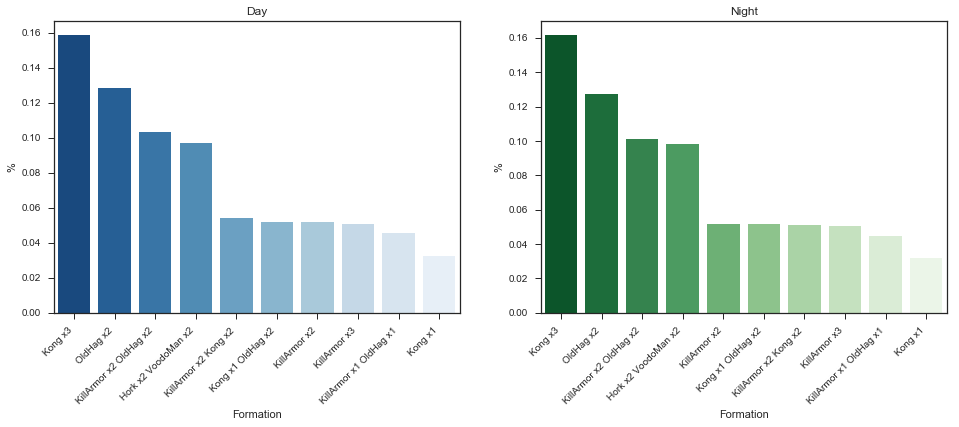

Day:
                        Count         %
Formation                              
Kong x3                  1587  0.158716
OldHag x2                1286  0.128613
KillArmor x2 OldHag x2   1030  0.103010
Hork x2 VoodoMan x2       971  0.097110
KillArmor x2 Kong x2      539  0.053905
Kong x1 OldHag x2         519  0.051905
KillArmor x2              516  0.051605
KillArmor x3              509  0.050905
KillArmor x1 OldHag x1    455  0.045505
Kong x1                   323  0.032303
-----
Night:
                        Count         %
Formation                              
Kong x3                  1616  0.161616
OldHag x2                1273  0.127313
KillArmor x2 OldHag x2   1013  0.101310
Hork x2 VoodoMan x2       979  0.097910
KillArmor x2              517  0.051705
Kong x1 OldHag x2         514  0.051405
KillArmor x2 Kong x2      512  0.051205
KillArmor x3              505  0.050505
KillArmor x1 OldHag x1    449  0.044904
Kong x1                   319  0.031903
-----
-----


**Edinbear**

-----


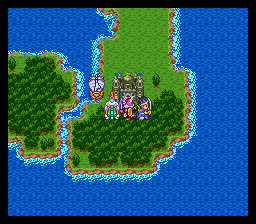

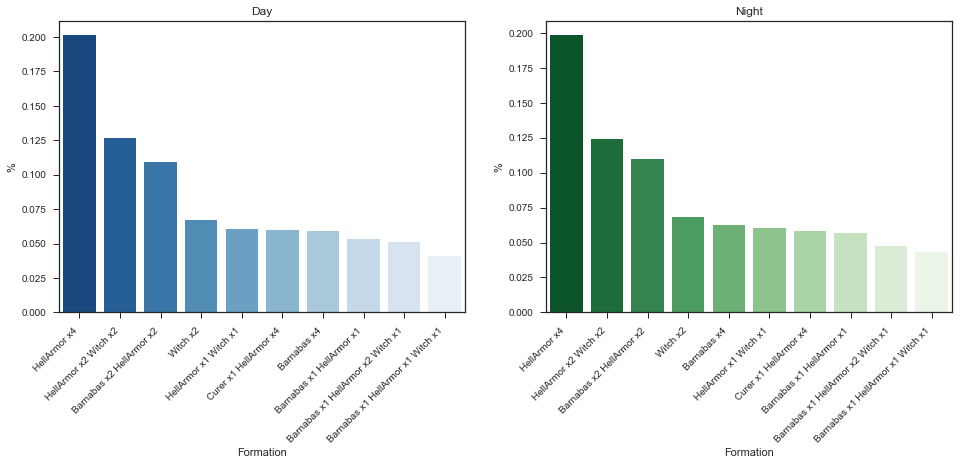

Day:
                                   Count         %
Formation                                         
HellArmor x4                        2014  0.201420
HellArmor x2 Witch x2               1266  0.126613
Barnabas x2 HellArmor x2            1091  0.109111
Witch x2                             668  0.066807
HellArmor x1 Witch x1                604  0.060406
Curer x1 HellArmor x4                601  0.060106
Barnabas x4                          593  0.059306
Barnabas x1 HellArmor x1             532  0.053205
Barnabas x1 HellArmor x2 Witch x1    508  0.050805
Barnabas x1 HellArmor x1 Witch x1    407  0.040704
-----
Night:
                                   Count         %
Formation                                         
HellArmor x4                        1985  0.198520
HellArmor x2 Witch x2               1237  0.123712
Barnabas x2 HellArmor x2            1097  0.109711
Witch x2                             683  0.068307
Barnabas x4                          626  0.062606
HellArmor x1 

**Tedanki**

-----


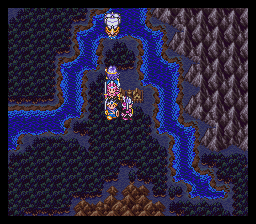

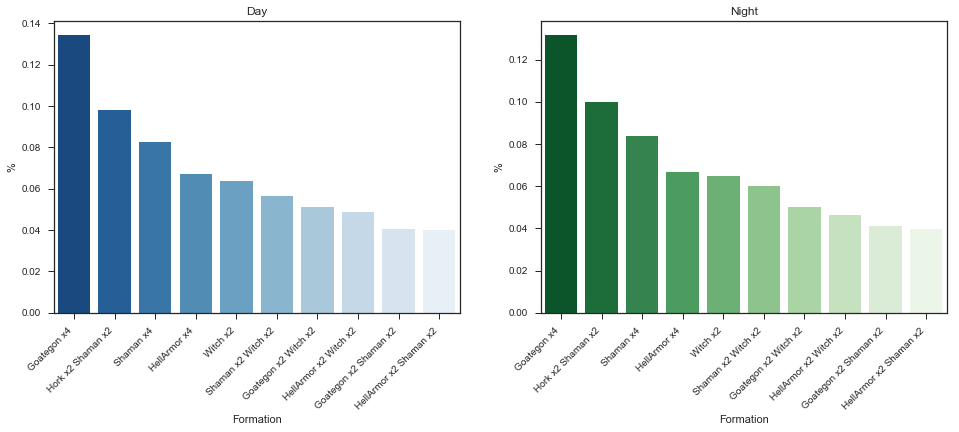

Day:
                        Count         %
Formation                              
Goategon x4              1344  0.134413
Hork x2 Shaman x2         979  0.097910
Shaman x4                 827  0.082708
HellArmor x4              673  0.067307
Witch x2                  635  0.063506
Shaman x2 Witch x2        563  0.056306
Goategon x2 Witch x2      511  0.051105
HellArmor x2 Witch x2     487  0.048705
Goategon x2 Shaman x2     404  0.040404
HellArmor x2 Shaman x2    401  0.040104
-----
Night:
                        Count         %
Formation                              
Goategon x4              1317  0.131713
Hork x2 Shaman x2         997  0.099710
Shaman x4                 837  0.083708
HellArmor x4              666  0.066607
Witch x2                  648  0.064806
Shaman x2 Witch x2        602  0.060206
Goategon x2 Witch x2      503  0.050305
HellArmor x2 Witch x2     462  0.046205
Goategon x2 Shaman x2     410  0.041004
HellArmor x2 Shaman x2    398  0.039804
-----
-----


**Necrogond**

-----


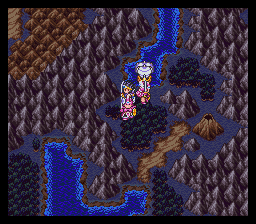

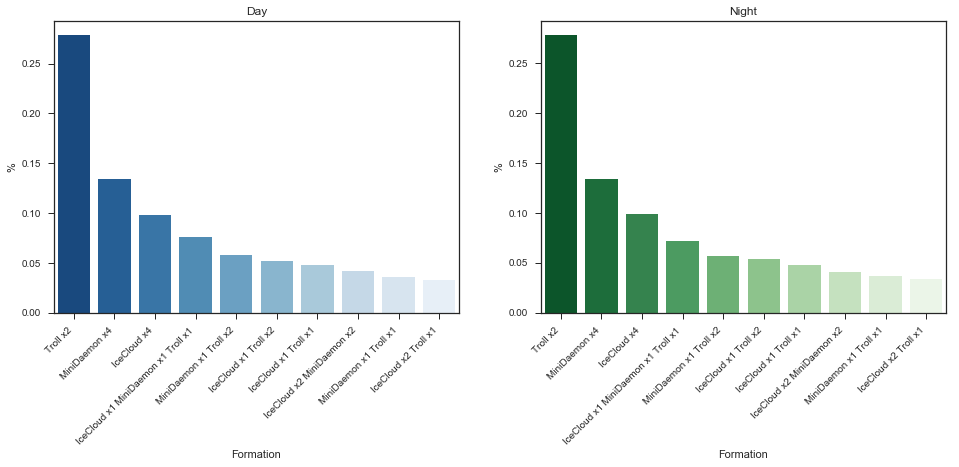

Day:
                                    Count         %
Formation                                          
Troll x2                             2788  0.278828
MiniDaemon x4                        1337  0.133713
IceCloud x4                           980  0.098010
IceCloud x1 MiniDaemon x1 Troll x1    756  0.075608
MiniDaemon x1 Troll x2                574  0.057406
IceCloud x1 Troll x2                  518  0.051805
IceCloud x1 Troll x1                  476  0.047605
IceCloud x2 MiniDaemon x2             413  0.041304
MiniDaemon x1 Troll x1                353  0.035304
IceCloud x2 Troll x1                  323  0.032303
-----
Night:
                                    Count         %
Formation                                          
Troll x2                             2782  0.278228
MiniDaemon x4                        1339  0.133913
IceCloud x4                           989  0.098910
IceCloud x1 MiniDaemon x1 Troll x1    719  0.071907
MiniDaemon x1 Troll x2                566  0.0

**Silver Orb Shrine**

-----


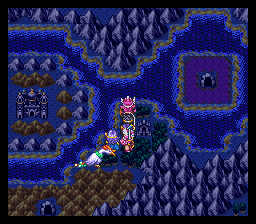

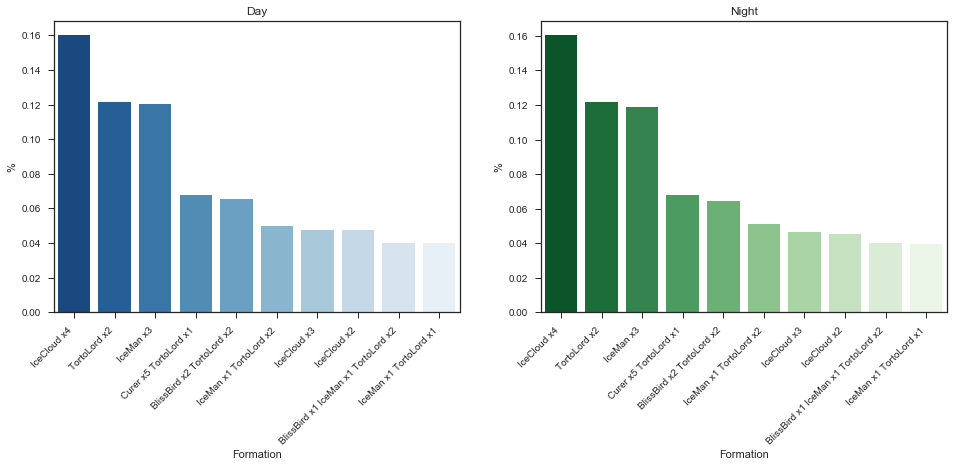

Day:
                                     Count         %
Formation                                           
IceCloud x4                           1604  0.160416
TortoLord x2                          1215  0.121512
IceMan x3                             1206  0.120612
Curer x5 TortoLord x1                  678  0.067807
BlissBird x2 TortoLord x2              657  0.065707
IceMan x1 TortoLord x2                 496  0.049605
IceCloud x3                            477  0.047705
IceCloud x2                            477  0.047705
BlissBird x1 IceMan x1 TortoLord x2    400  0.040004
IceMan x1 TortoLord x1                 400  0.040004
-----
Night:
                                     Count         %
Formation                                           
IceCloud x4                           1607  0.160716
TortoLord x2                          1216  0.121612
IceMan x3                             1190  0.119012
Curer x5 TortoLord x1                  680  0.068007
BlissBird x2 TortoLord x2   

**Merchant Town**

-----


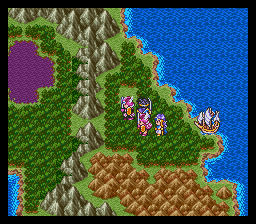

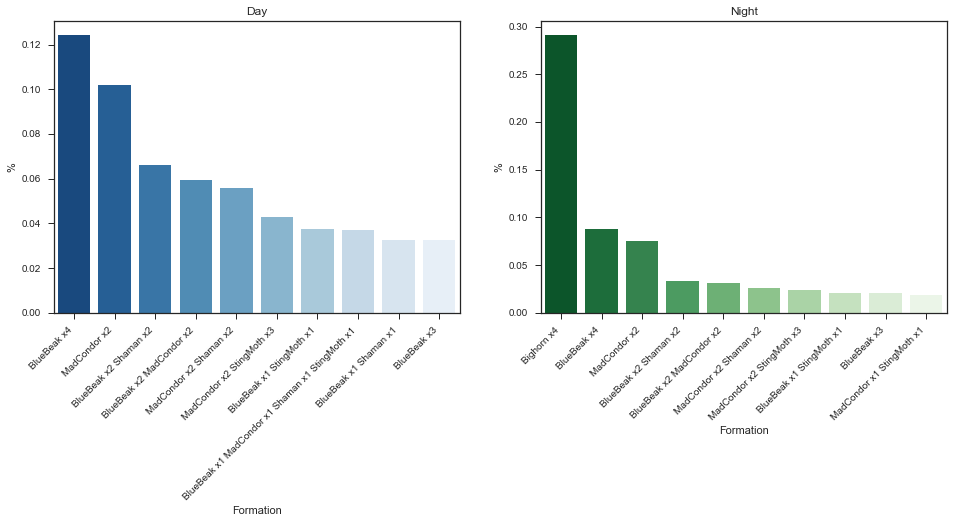

Day:
                                                 Count         %
Formation                                                       
BlueBeak x4                                       1242  0.124212
MadCondor x2                                      1017  0.101710
BlueBeak x2 Shaman x2                              662  0.066207
BlueBeak x2 MadCondor x2                           595  0.059506
MadCondor x2 Shaman x2                             556  0.055606
MadCondor x2 StingMoth x3                          429  0.042904
BlueBeak x1 StingMoth x1                           377  0.037704
BlueBeak x1 MadCondor x1 Shaman x1 StingMoth x1    372  0.037204
BlueBeak x1 Shaman x1                              326  0.032603
BlueBeak x3                                        325  0.032503
-----
Night:
                           Count         %
Formation                                 
Bighorn x4                  2910  0.291029
BlueBeak x4                  877  0.087709
MadCondor x2                 7

**Lamia Shrine**

-----


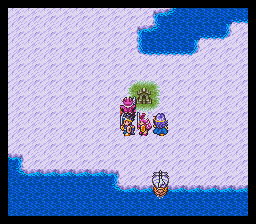

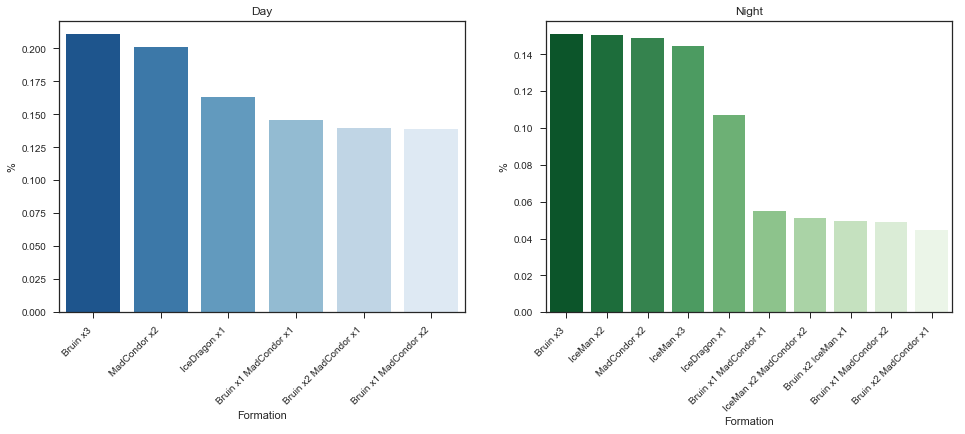

Day:
                       Count         %
Formation                             
Bruin x3                2106  0.210621
MadCondor x2            2013  0.201320
IceDragon x1            1634  0.163416
Bruin x1 MadCondor x1   1458  0.145815
Bruin x2 MadCondor x1   1400  0.140014
Bruin x1 MadCondor x2   1388  0.138814
-----
Night:
                        Count         %
Formation                              
Bruin x3                 1508  0.150815
IceMan x2                1506  0.150615
MadCondor x2             1487  0.148715
IceMan x3                1448  0.144814
IceDragon x1             1069  0.106911
Bruin x1 MadCondor x1     549  0.054905
IceMan x2 MadCondor x2    511  0.051105
Bruin x2 IceMan x1        496  0.049605
Bruin x1 MadCondor x2     490  0.049005
Bruin x2 MadCondor x1     449  0.044904
-----
-----


**To Ludatorm**

-----


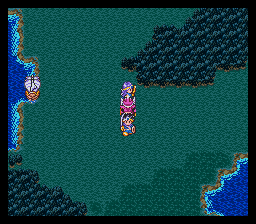

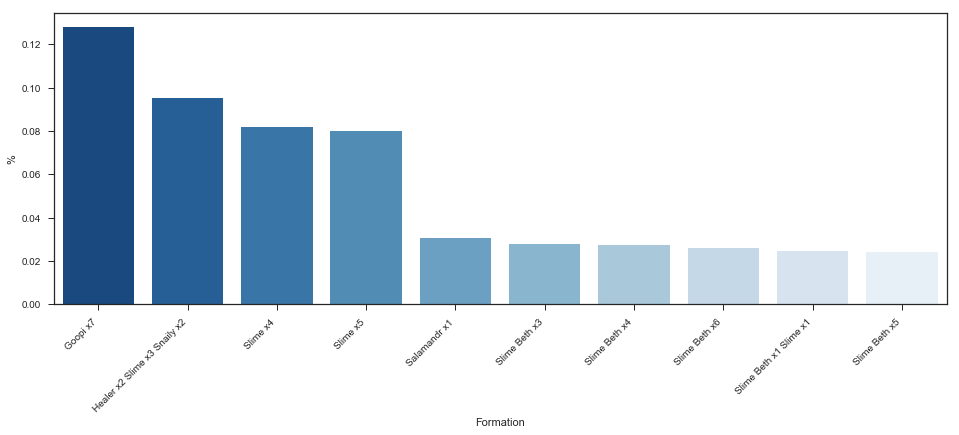

                                                    Formation         %
Goopi x7                                                 1281  0.128113
Healer x2 Slime x3 Snaily x2                              952  0.095210
Slime x4                                                  820  0.082008
Slime x5                                                  799  0.079908
Salamandr x1                                              307  0.030703
Slime Beth x3                                             278  0.027803
Slime Beth x4                                             272  0.027203
Slime Beth x6                                             262  0.026203
Slime Beth x1 Slime x1                                    247  0.024702
Slime Beth x5                                             243  0.024302
HellNite x3 Slime Beth x3                                 207  0.020702
Slime Beth x7                                             206  0.020602
Goopi x1 Slime Beth x1                                    205  0

**To Mountain Cave**

-----


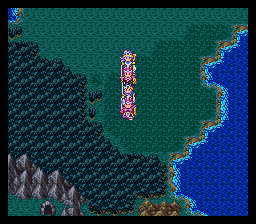

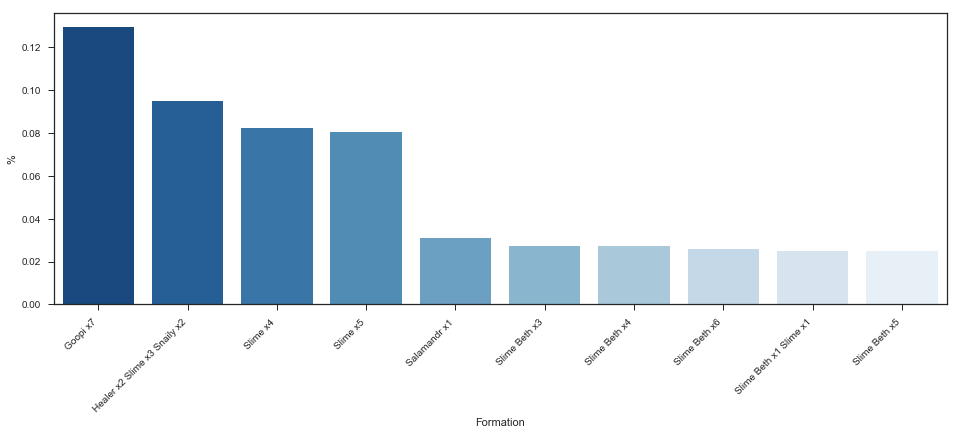

                                                    Formation         %
Goopi x7                                                 1296  0.129613
Healer x2 Slime x3 Snaily x2                              948  0.094809
Slime x4                                                  823  0.082308
Slime x5                                                  805  0.080508
Salamandr x1                                              308  0.030803
Slime Beth x3                                             273  0.027303
Slime Beth x4                                             272  0.027203
Slime Beth x6                                             257  0.025703
Slime Beth x1 Slime x1                                    248  0.024802
Slime Beth x5                                             247  0.024702
HellNite x3 Slime Beth x3                                 208  0.020802
Slime Beth x7                                             206  0.020602
Goopi x1 Slime Beth x1                                    205  0

**To Melkido**

-----


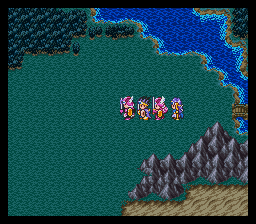

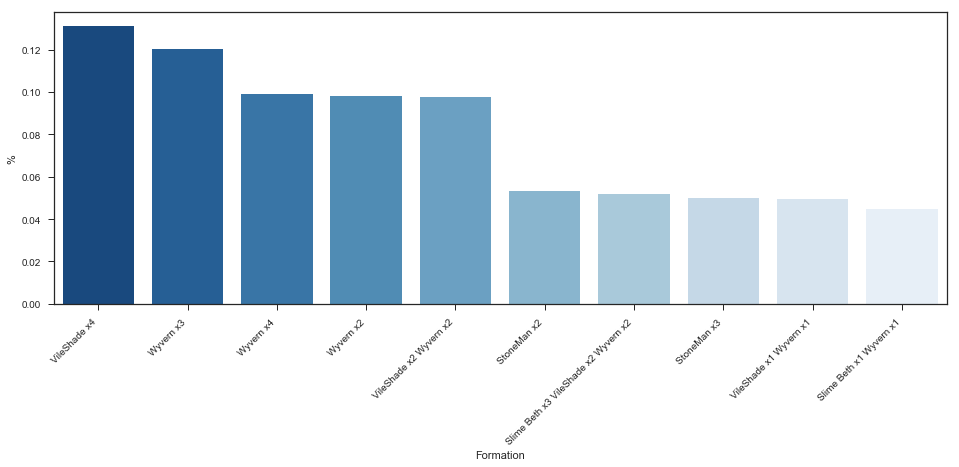

                                      Formation         %
VileShade x4                               1311  0.131113
Wyvern x3                                  1204  0.120412
Wyvern x4                                   989  0.098910
Wyvern x2                                   982  0.098210
VileShade x2 Wyvern x2                      977  0.097710
StoneMan x2                                 534  0.053405
Slime Beth x3 VileShade x2 Wyvern x2        517  0.051705
StoneMan x3                                 498  0.049805
VileShade x1 Wyvern x1                      497  0.049705
Slime Beth x1 Wyvern x1                     448  0.044804
Slime Beth x1 VileShade x1 Wyvern x1        370  0.037004
Slime Beth x2 Wyvern x2                     312  0.031203
Slime Beth x2 VileShade x2 Wyvern x2        253  0.025303
Slime Beth x3 Wyvern x4                     249  0.024902
Slime Beth x3 Wyvern x3                     217  0.021702
Slime Beth x1 VileShade x1                  191  0.019102
Slime Beth x4 

**Outside Garin Tomb**

-----


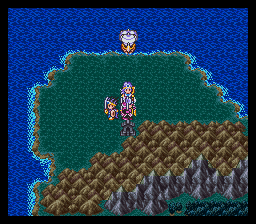

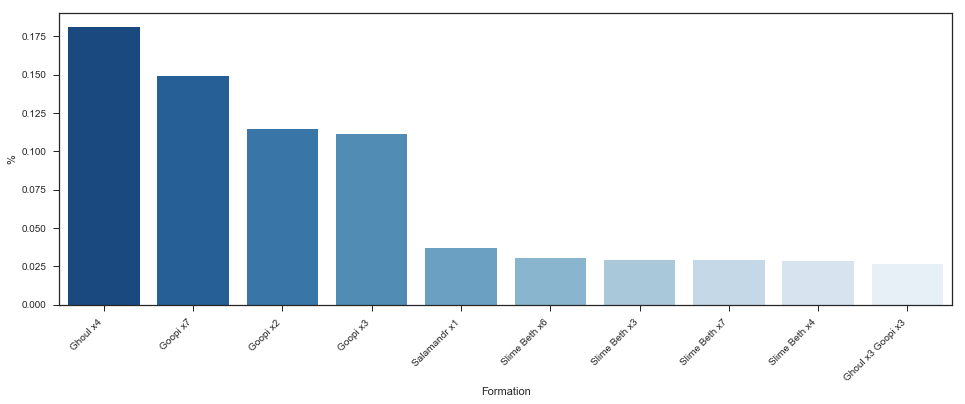

                                          Formation         %
Ghoul x4                                       1811  0.181118
Goopi x7                                       1490  0.149015
Goopi x2                                       1147  0.114711
Goopi x3                                       1113  0.111311
Salamandr x1                                    369  0.036904
Slime Beth x6                                   304  0.030403
Slime Beth x3                                   292  0.029203
Slime Beth x7                                   291  0.029103
Slime Beth x4                                   283  0.028303
Ghoul x3 Goopi x3                               264  0.026403
Slime Beth x5                                   258  0.025803
Goopi x1 Slime Beth x1                          250  0.025003
Goopi x4 Slime Beth x4                          237  0.023702
Goopi x2 Slime Beth x2                          166  0.016602
Ghoul x1 Goopi x1                               154  0.015402
Goopi x3

**To Kol (1)**

-----


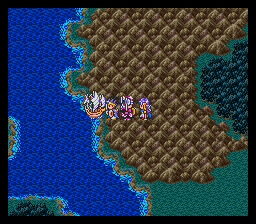

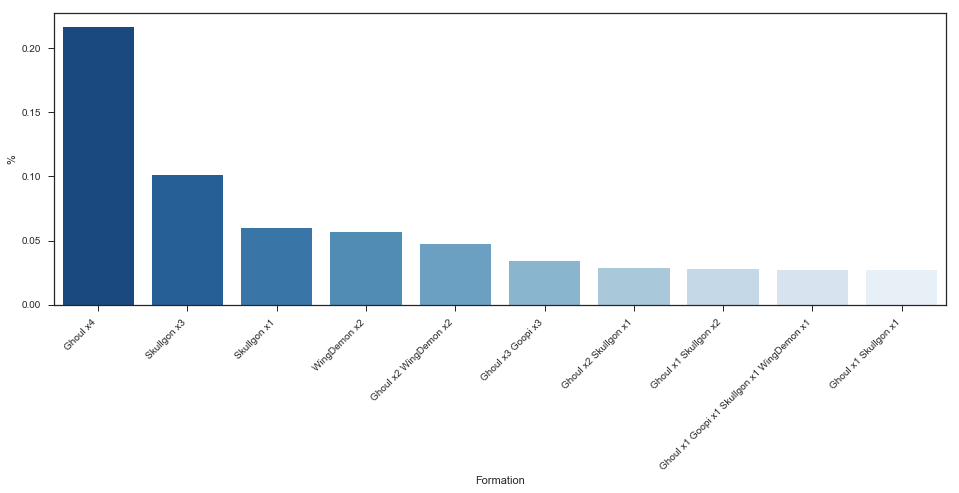

                                            Formation         %
Ghoul x4                                         2168  0.216822
Skullgon x3                                      1014  0.101410
Skullgon x1                                       598  0.059806
WingDemon x2                                      567  0.056706
Ghoul x2 WingDemon x2                             475  0.047505
Ghoul x3 Goopi x3                                 339  0.033903
Ghoul x2 Skullgon x1                              286  0.028603
Ghoul x1 Skullgon x2                              276  0.027603
Ghoul x1 Goopi x1 Skullgon x1 WingDemon x1        272  0.027203
Ghoul x1 Skullgon x1                              269  0.026903
Ghoul x2                                          256  0.025603
Goopi x2 Skullgon x2                              254  0.025403
Ghoul x1 Skullgon x1 WingDemon x1                 252  0.025203
Ghoul x3                                          242  0.024202
Ghoul x1 Goopi x1                       

**To Kol (2)**

-----


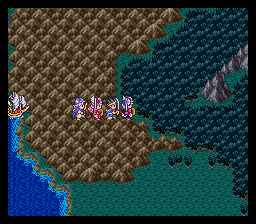

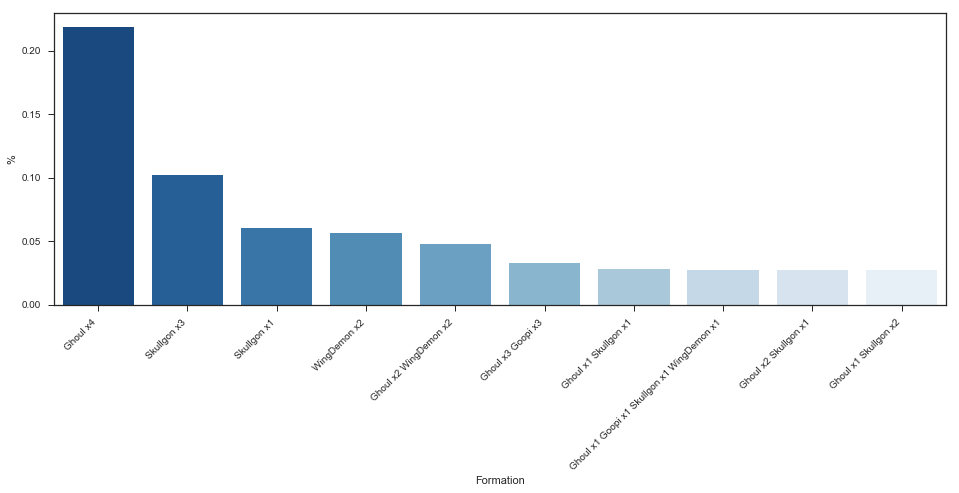

                                            Formation         %
Ghoul x4                                         2186  0.218622
Skullgon x3                                      1017  0.101710
Skullgon x1                                       601  0.060106
WingDemon x2                                      563  0.056306
Ghoul x2 WingDemon x2                             476  0.047605
Ghoul x3 Goopi x3                                 331  0.033103
Ghoul x1 Skullgon x1                              278  0.027803
Ghoul x1 Goopi x1 Skullgon x1 WingDemon x1        274  0.027403
Ghoul x2 Skullgon x1                              273  0.027303
Ghoul x1 Skullgon x2                              273  0.027303
Ghoul x1 Skullgon x1 WingDemon x1                 264  0.026403
Ghoul x2                                          257  0.025703
Goopi x2 Skullgon x2                              256  0.025603
Ghoul x1 Goopi x1                                 239  0.023902
Ghoul x3                                

**Southwest Domdora**

-----


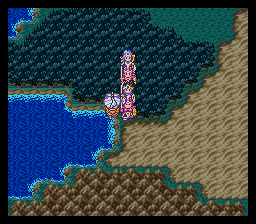

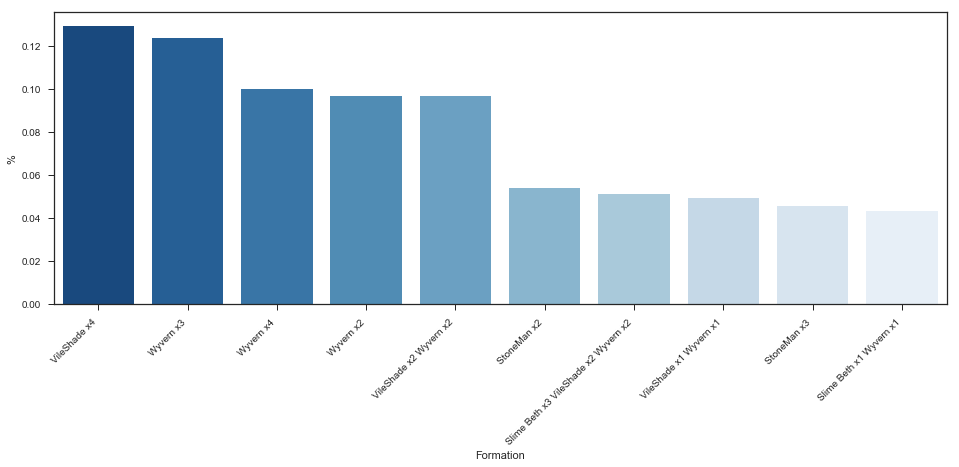

                                      Formation         %
VileShade x4                               1290  0.129013
Wyvern x3                                  1234  0.123412
Wyvern x4                                   996  0.099610
Wyvern x2                                   966  0.096610
VileShade x2 Wyvern x2                      964  0.096410
StoneMan x2                                 537  0.053705
Slime Beth x3 VileShade x2 Wyvern x2        509  0.050905
VileShade x1 Wyvern x1                      490  0.049005
StoneMan x3                                 454  0.045405
Slime Beth x1 Wyvern x1                     433  0.043304
Slime Beth x1 VileShade x1 Wyvern x1        398  0.039804
Slime Beth x2 Wyvern x2                     309  0.030903
Slime Beth x2 VileShade x2 Wyvern x2        273  0.027303
Slime Beth x3 Wyvern x4                     262  0.026203
Slime Beth x1 VileShade x1                  209  0.020902
Slime Beth x3 Wyvern x3                     209  0.020902
Slime Beth x4 

**Outside RainStaff Shrine**

-----


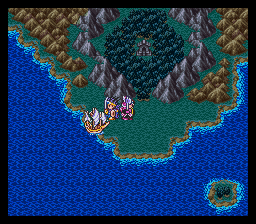

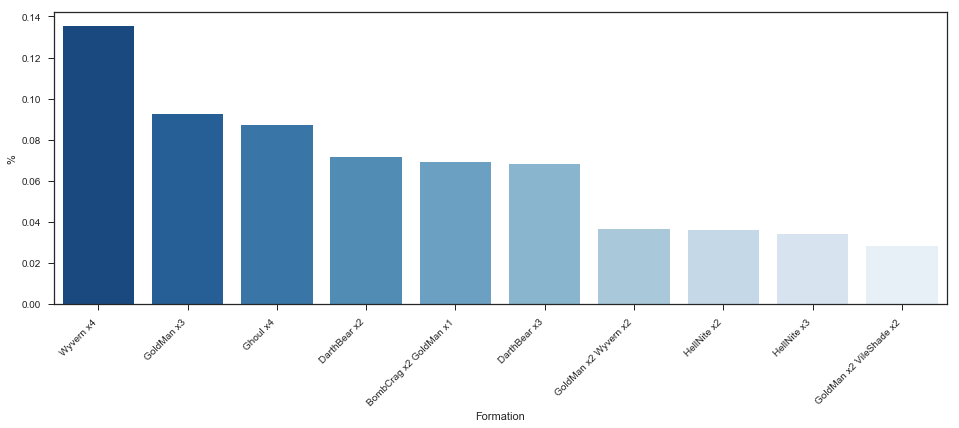

                                                Formation         %
Wyvern x4                                            1353  0.135314
GoldMan x3                                            925  0.092509
Ghoul x4                                              869  0.086909
DarthBear x2                                          716  0.071607
BombCrag x2 GoldMan x1                                692  0.069207
DarthBear x3                                          680  0.068007
GoldMan x2 Wyvern x2                                  363  0.036304
HellNite x2                                           362  0.036204
HellNite x3                                           339  0.033903
GoldMan x2 VileShade x2                               282  0.028203
VileShade x2 Wyvern x2                                233  0.023302
GoldMan x1                                            225  0.022502
Ghoul x2 GoldMan x2                                   203  0.020302
Ghoul x2 Wyvern x2                              

**Eastern Darkworld Continent**

-----


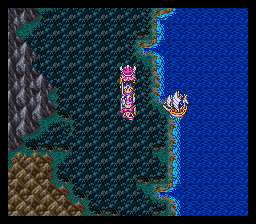

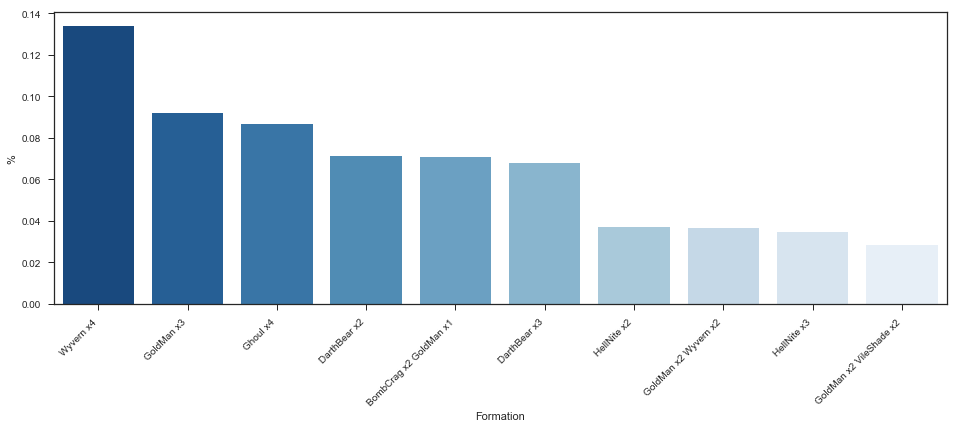

                                                Formation         %
Wyvern x4                                            1339  0.133913
GoldMan x3                                            920  0.092009
Ghoul x4                                              866  0.086609
DarthBear x2                                          714  0.071407
BombCrag x2 GoldMan x1                                706  0.070607
DarthBear x3                                          681  0.068107
HellNite x2                                           369  0.036904
GoldMan x2 Wyvern x2                                  364  0.036404
HellNite x3                                           345  0.034503
GoldMan x2 VileShade x2                               285  0.028503
VileShade x2 Wyvern x2                                221  0.022102
GoldMan x1                                            218  0.021802
Ghoul x2 GoldMan x2                                   211  0.021102
DarthBear x1 GoldMan x2                         

**To Zoma (1)**

-----


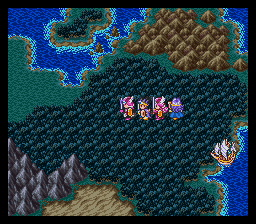

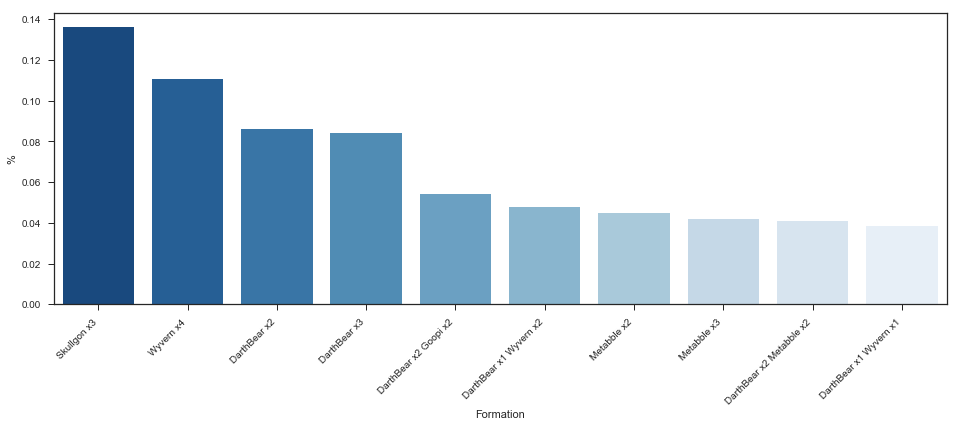

                                             Formation         %
Skullgon x3                                       1365  0.136514
Wyvern x4                                         1107  0.110711
DarthBear x2                                       860  0.086009
DarthBear x3                                       843  0.084308
DarthBear x2 Goopi x2                              542  0.054205
DarthBear x1 Wyvern x2                             477  0.047705
Metabble x2                                        446  0.044604
Metabble x3                                        421  0.042104
DarthBear x2 Metabble x2                           411  0.041104
DarthBear x1 Wyvern x1                             386  0.038604
DarthBear x2 Wyvern x1                             340  0.034003
DarthBear x1 Goopi x1                              276  0.027603
DarthBear x1 Metabble x1                           213  0.021302
Metabble x3 Wyvern x3                              205  0.020502
Goopi x3 Wyvern x3       

**To Zoma (2)**

-----


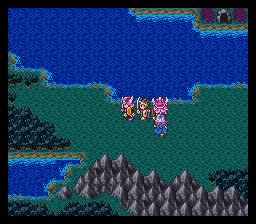

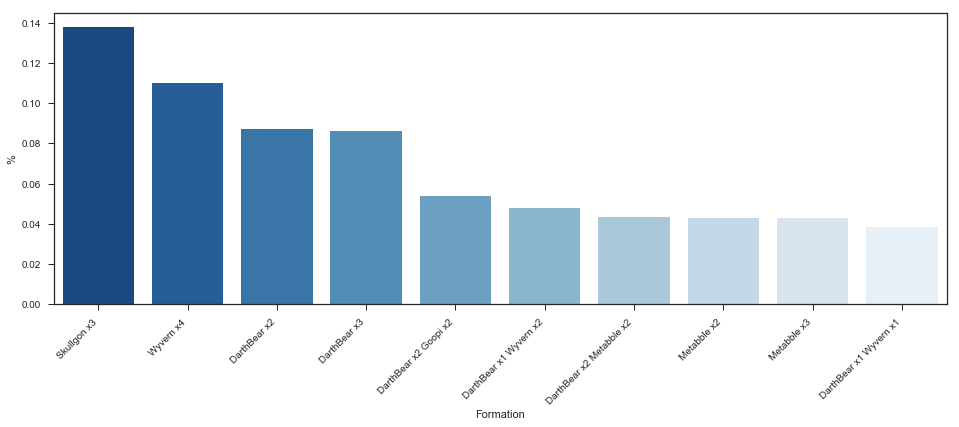

                                             Formation         %
Skullgon x3                                       1380  0.138014
Wyvern x4                                         1100  0.110011
DarthBear x2                                       871  0.087109
DarthBear x3                                       861  0.086109
DarthBear x2 Goopi x2                              539  0.053905
DarthBear x1 Wyvern x2                             480  0.048005
DarthBear x2 Metabble x2                           432  0.043204
Metabble x2                                        430  0.043004
Metabble x3                                        428  0.042804
DarthBear x1 Wyvern x1                             383  0.038304
DarthBear x2 Wyvern x1                             341  0.034103
DarthBear x1 Goopi x1                              286  0.028603
DarthBear x1 Metabble x1                           209  0.020902
Metabble x3 Wyvern x3                              204  0.020402
Goopi x3 Wyvern x3       

**To Zoma (3)**

-----


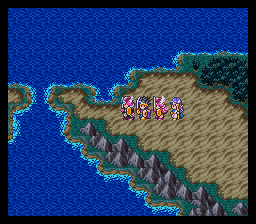

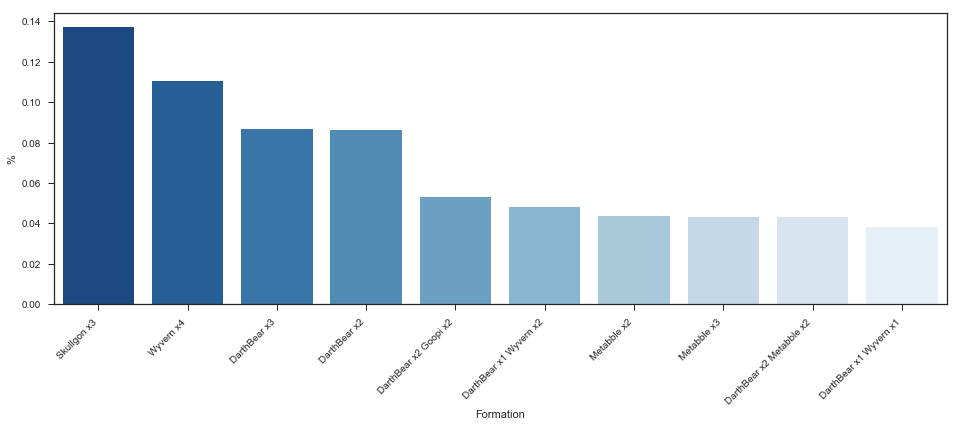

                                             Formation         %
Skullgon x3                                       1374  0.137414
Wyvern x4                                         1105  0.110511
DarthBear x3                                       866  0.086609
DarthBear x2                                       863  0.086309
DarthBear x2 Goopi x2                              533  0.053305
DarthBear x1 Wyvern x2                             481  0.048105
Metabble x2                                        438  0.043804
Metabble x3                                        431  0.043104
DarthBear x2 Metabble x2                           430  0.043004
DarthBear x1 Wyvern x1                             384  0.038404
DarthBear x2 Wyvern x1                             341  0.034103
DarthBear x1 Goopi x1                              289  0.028903
DarthBear x1 Metabble x1                           213  0.021302
Metabble x3 Wyvern x3                              202  0.020202
Goopi x3 Wyvern x3       

**To Zoma (4)**

-----


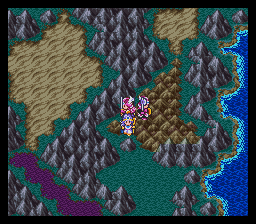

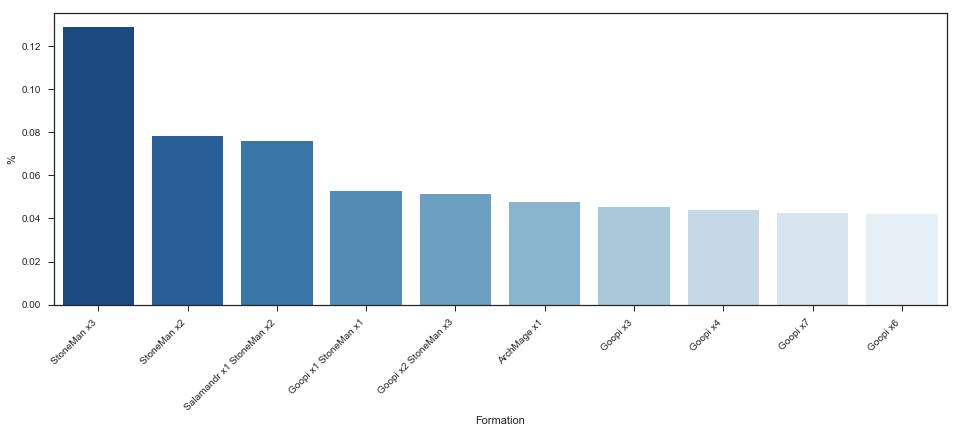

                                               Formation         %
StoneMan x3                                         1289  0.128913
StoneMan x2                                          782  0.078208
Salamandr x1 StoneMan x2                             759  0.075908
Goopi x1 StoneMan x1                                 527  0.052705
Goopi x2 StoneMan x3                                 512  0.051205
ArchMage x1                                          475  0.047505
Goopi x3                                             454  0.045405
Goopi x4                                             438  0.043804
Goopi x7                                             425  0.042504
Goopi x6                                             419  0.041904
Salamandr x1 StoneMan x1                             405  0.040504
Goopi x5                                             377  0.037704
Goopi x2 StoneMan x2                                 322  0.032203
StoneMan x1 StoneMan x1                              285  0.02

**To Zoma (5)**

-----


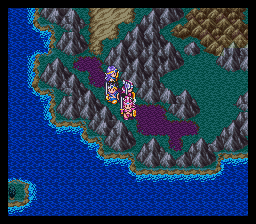

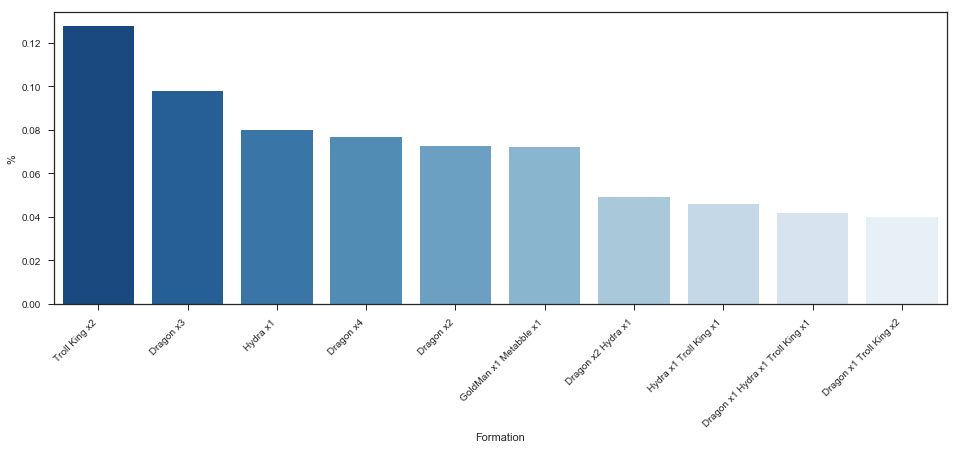

                                      Formation         %
Troll King x2                              1276  0.127613
Dragon x3                                   979  0.097910
Hydra x1                                    800  0.080008
Dragon x4                                   769  0.076908
Dragon x2                                   726  0.072607
GoldMan x1 Metabble x1                      720  0.072007
Dragon x2 Hydra x1                          489  0.048905
Hydra x1 Troll King x1                      460  0.046005
Dragon x1 Hydra x1 Troll King x1            419  0.041904
Dragon x1 Troll King x2                     400  0.040004
Dragon x1 Troll King x1                     396  0.039604
Dragon x2 VoodooWiz x2                      364  0.036404
Dragon x1 Troll King x1 VoodooWiz x1        337  0.033703
Dragon x2 Troll King x1                     292  0.029203
VoodooWiz x1                                271  0.027103
Dragon x1 Hydra x1                          235  0.023502
Dragon x1 Hydr

**To Samanosa Shrine**

-----


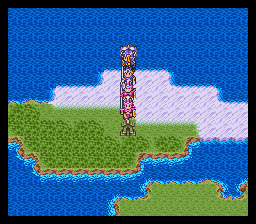

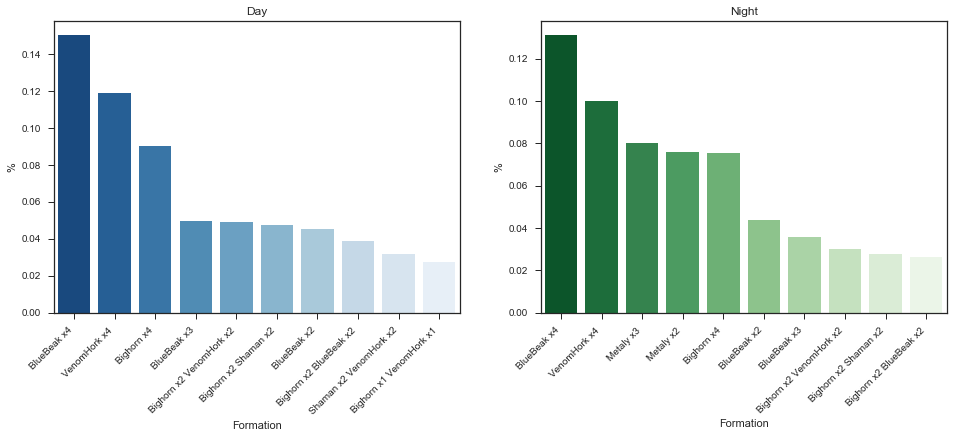

Day:
                         Count         %
Formation                               
BlueBeak x4               1503  0.150315
VenomHork x4              1189  0.118912
Bighorn x4                 904  0.090409
BlueBeak x3                494  0.049405
Bighorn x2 VenomHork x2    492  0.049205
Bighorn x2 Shaman x2       476  0.047605
BlueBeak x2                451  0.045105
Bighorn x2 BlueBeak x2     390  0.039004
Shaman x2 VenomHork x2     318  0.031803
Bighorn x1 VenomHork x1    274  0.027403
-----
Night:
                         Count         %
Formation                               
BlueBeak x4               1311  0.131113
VenomHork x4               998  0.099810
Metaly x3                  802  0.080208
Metaly x2                  758  0.075808
Bighorn x4                 755  0.075508
BlueBeak x2                438  0.043804
BlueBeak x3                358  0.035804
Bighorn x2 VenomHork x2    301  0.030103
Bighorn x2 Shaman x2       278  0.027803
Bighorn x2 BlueBeak x2     261  0.02610

**Map Type: Sea**

-----


**To Sioux (1)**

-----


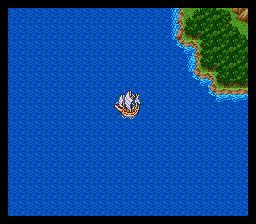

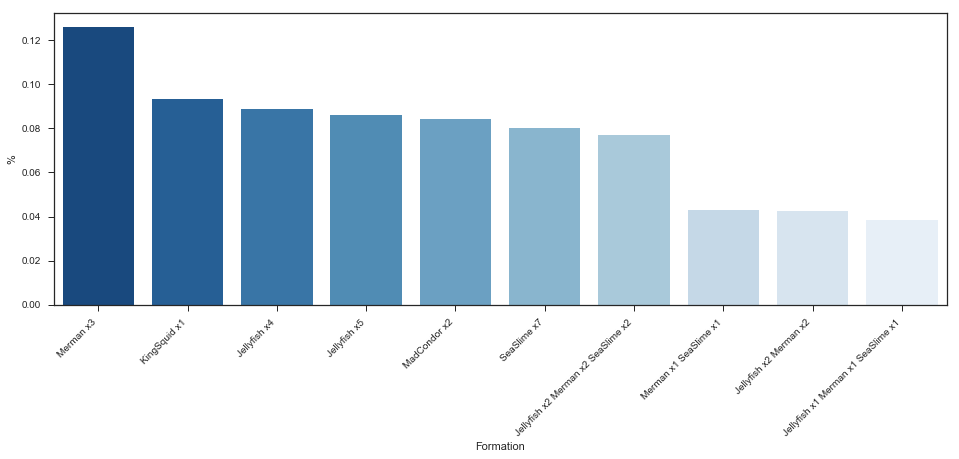

                                    Formation         %
Merman x3                                1260  0.126013
KingSquid x1                              932  0.093209
Jellyfish x4                              888  0.088809
Jellyfish x5                              861  0.086109
MadCondor x2                              841  0.084108
SeaSlime x7                               802  0.080208
Jellyfish x2 Merman x2 SeaSlime x2        768  0.076808
Merman x1 SeaSlime x1                     428  0.042804
Jellyfish x2 Merman x2                    427  0.042704
Jellyfish x1 Merman x1 SeaSlime x1        384  0.038404
Jellyfish x1 SeaSlime x1                  378  0.037804
Jellyfish x4 SeaSlime x4                  333  0.033303
Merman x2 SeaSlime x4                     331  0.033103
Jellyfish x1 Merman x1                    314  0.031403
Jellyfish x2 SeaSlime x2                  255  0.025503
Merman x2 SeaSlime x2                     242  0.024202
Jellyfish x3 SeaSlime x3                  173  0

**To Sioux (2)**

-----


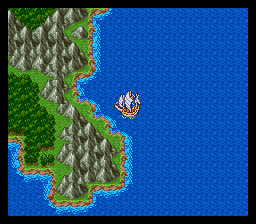

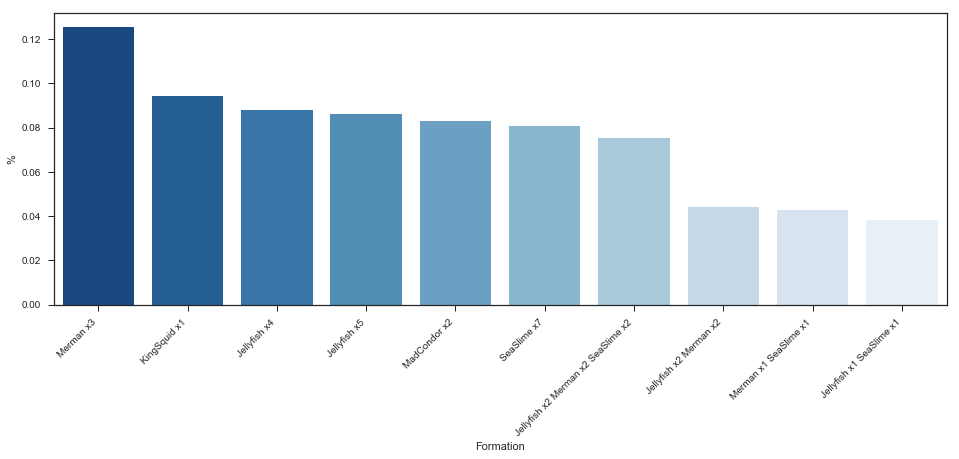

                                    Formation         %
Merman x3                                1255  0.125513
KingSquid x1                              943  0.094309
Jellyfish x4                              880  0.088009
Jellyfish x5                              862  0.086209
MadCondor x2                              829  0.082908
SeaSlime x7                               809  0.080908
Jellyfish x2 Merman x2 SeaSlime x2        754  0.075408
Jellyfish x2 Merman x2                    441  0.044104
Merman x1 SeaSlime x1                     427  0.042704
Jellyfish x1 SeaSlime x1                  383  0.038304
Jellyfish x1 Merman x1 SeaSlime x1        372  0.037204
Jellyfish x4 SeaSlime x4                  338  0.033803
Merman x2 SeaSlime x4                     331  0.033103
Jellyfish x1 Merman x1                    321  0.032103
Jellyfish x2 SeaSlime x2                  254  0.025403
Merman x2 SeaSlime x2                     235  0.023502
Jellyfish x3 SeaSlime x3                  175  0

**To Necrogond**

-----


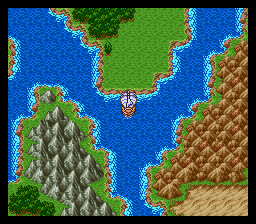

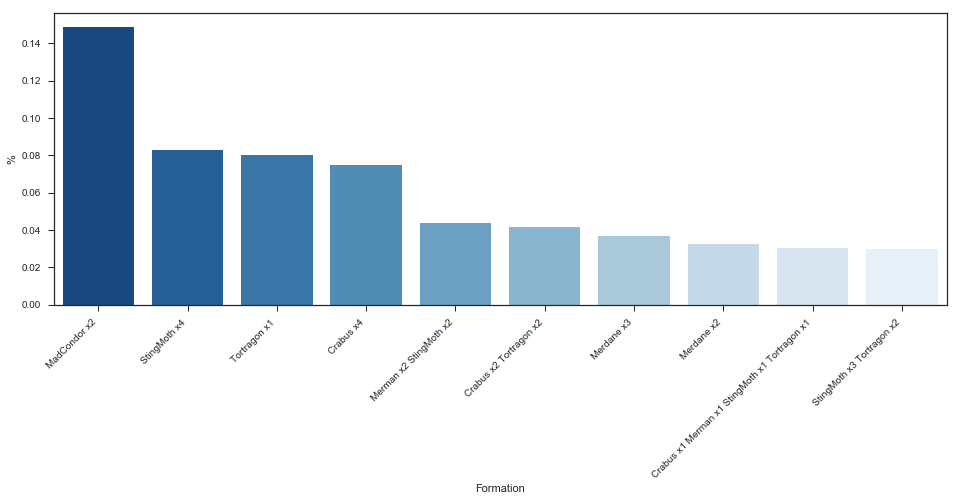

                                               Formation         %
MadCondor x2                                        1488  0.148815
StingMoth x4                                         827  0.082708
Tortragon x1                                         804  0.080408
Crabus x4                                            750  0.075008
Merman x2 StingMoth x2                               439  0.043904
Crabus x2 Tortragon x2                               418  0.041804
Merdane x3                                           370  0.037004
Merdane x2                                           327  0.032703
Crabus x1 Merman x1 StingMoth x1 Tortragon x1        303  0.030303
StingMoth x3 Tortragon x2                            296  0.029603
Merman x1 Tortragon x2                               264  0.026403
Merman x1 Tortragon x1                               261  0.026103
Crabus x2 StingMoth x2                               258  0.025803
Crabus x1 Merman x1 Tortragon x1                     251  0.02

**To Lamia Shrine**

-----


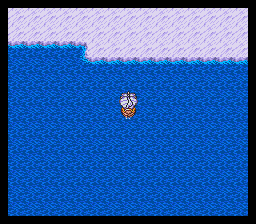

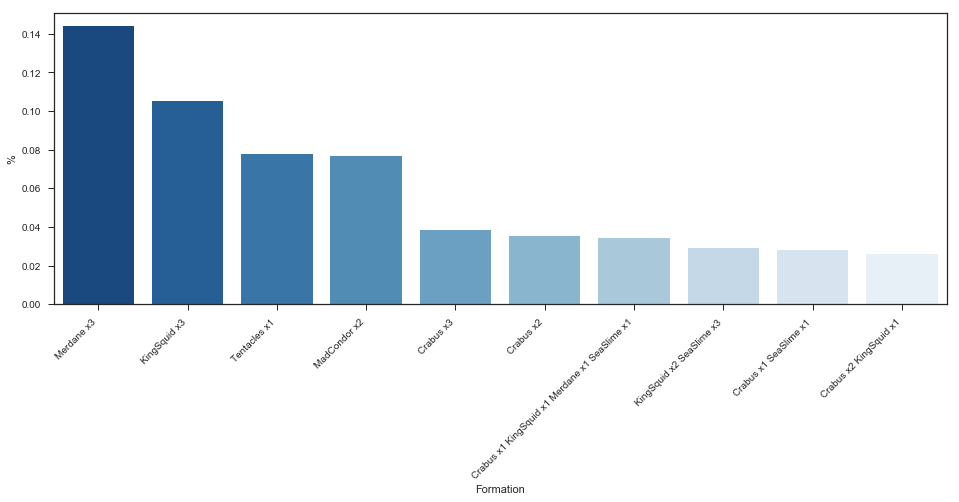

                                               Formation         %
Merdane x3                                          1438  0.143814
KingSquid x3                                        1050  0.105011
Tentacles x1                                         776  0.077608
MadCondor x2                                         768  0.076808
Crabus x3                                            383  0.038304
Crabus x2                                            355  0.035504
Crabus x1 KingSquid x1 Merdane x1 SeaSlime x1        343  0.034303
KingSquid x2 SeaSlime x3                             290  0.029003
Crabus x1 SeaSlime x1                                282  0.028203
Crabus x2 KingSquid x1                               259  0.025903
Crabus x1 KingSquid x1 Merdane x1                    247  0.024702
Crabus x2 Merdane x1                                 247  0.024702
Merdane x1 SeaSlime x1                               226  0.022602
Crabus x1 Merdane x1                                 218  0.02

**Dark World (1)**

-----


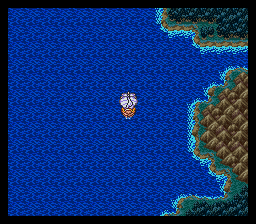

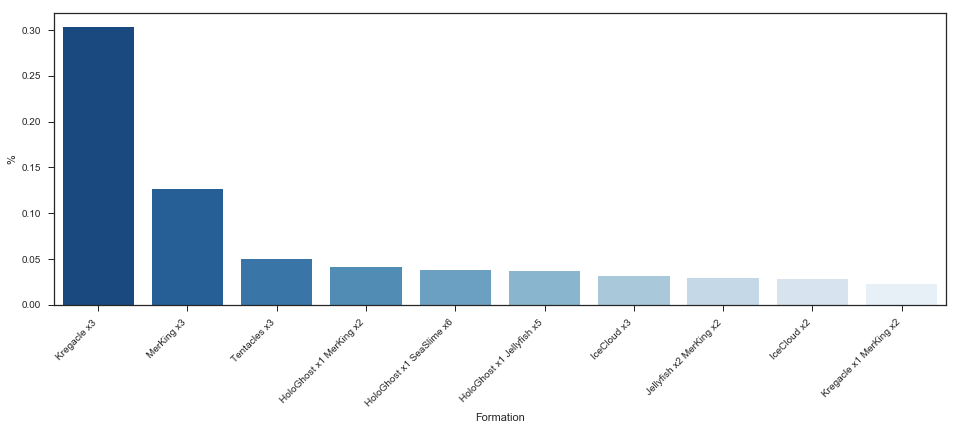

                                                 Formation         %
Kregacle x3                                           3034  0.303430
MerKing x3                                            1264  0.126413
Tentacles x3                                           502  0.050205
HoloGhost x1 MerKing x2                                413  0.041304
HoloGhost x1 SeaSlime x6                               384  0.038404
HoloGhost x1 Jellyfish x5                              369  0.036904
IceCloud x3                                            318  0.031803
Jellyfish x2 MerKing x2                                295  0.029503
IceCloud x2                                            280  0.028003
Kregacle x1 MerKing x2                                 232  0.023202
Jellyfish x1 MerKing x1                                214  0.021402
MerKing x1 SeaSlime x1                                 178  0.017802
MerKing x2 SeaSlime x4                                 166  0.016602
Jellyfish x1 SeaSlime x1          

**Dark World (2)**

-----


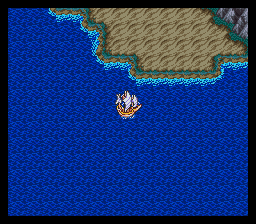

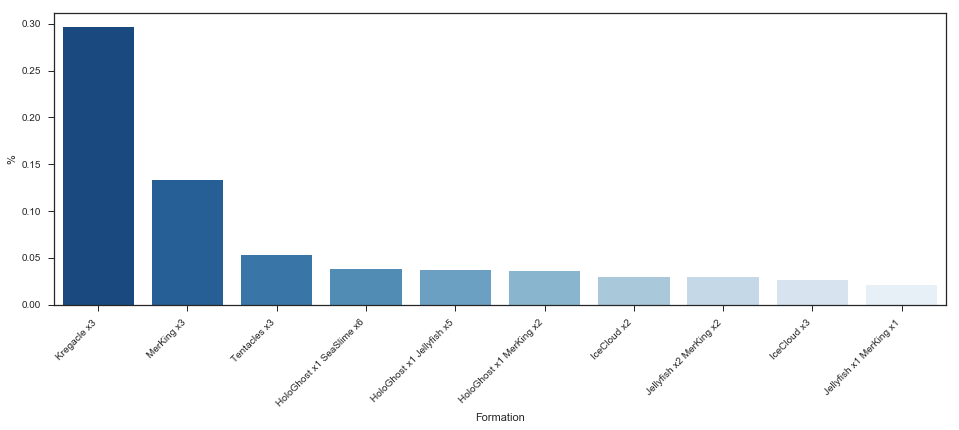

                                                 Formation         %
Kregacle x3                                           2965  0.296530
MerKing x3                                            1329  0.132913
Tentacles x3                                           536  0.053605
HoloGhost x1 SeaSlime x6                               377  0.037704
HoloGhost x1 Jellyfish x5                              375  0.037504
HoloGhost x1 MerKing x2                                361  0.036104
IceCloud x2                                            297  0.029703
Jellyfish x2 MerKing x2                                295  0.029503
IceCloud x3                                            264  0.026403
Jellyfish x1 MerKing x1                                206  0.020602
Kregacle x1 MerKing x2                                 204  0.020402
Jellyfish x1 SeaSlime x1                               190  0.019002
MerKing x1 SeaSlime x1                                 187  0.018702
MerKing x2 SeaSlime x4            

In [30]:
def call_all_plots(df, maptypes_list, language):
    for maptype in maptypes_list:
        display(Markdown(('**Map Type: '+maptype+'**')))

        df1 = df.loc[(df['Map Type'] == maptype)]

        zones_list = df1['Zone'].unique().tolist()
        areacode_list = df1['Area Code'].unique().tolist()
        zonedict = dict(zip(areacode_list,zones_list))
        for areacode in sorted(areacode_list):
            zone = zonedict[areacode]
            df2 = df1.loc[(df1['Map Type'] == maptype) & (df1['Zone'] == zone)]
            print('-----')
            display(Markdown(('**'+zone+'**')))
            print('-----')
            display(fetch_img(maptype,areacode))
            try:
                if zone in daynightlist:
                    df_day, df_night = return_daynight(df2,maptype,zone)
                    plot_two(df_day,df_night,maptype,zone, language)
                    call_fullchart_dn(df_day,df_night,language)
                else:
                    df_query = return_df(df2, maptype,zone)
                    plot_one(df_query, maptype, zone, language)
                    call_fullchart(df2,language)

            except:
                print("Error on "+maptype+" : "+zone+"!")
                
call_all_plots(df, maptypes_list, 'en')
#call_all_plots(df, maptypes_list, 'jp')